# Advanced Methods for Data Science
## Peter M N Hull

# Introduction

## Summary

This piece of work is concerned with the exploration of two very different high-dimensional data sets - a dataset of text documents, and a collection of images. The four main overarching methods used come under graph analytics, supervised classification, unsupervised learning, and dimensionality reduction.

## Packages and Data

In [0]:
# Pandas for data handling
import pandas as pd

# Numpy
import numpy as np

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

# Seaborn for making plotting nicer
import seaborn as sns
sns.set()
sns.set_style('ticks')

# Itemgetter
from operator import itemgetter

# Stats
from scipy import stats
from scipy.optimize import linear_sum_assignment

# Set a seed
seed = 0
np.random.seed(seed)

In [0]:
# Methods for pre-processing the data
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# KNN
from sklearn.neighbors import KNeighborsClassifier

# Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

# Model Selection
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# Decomposition
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation

In [0]:
# Graph analysis
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

In [0]:
# Import packages from Facebook's Neural Network package, PyTorch
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torch import cuda

# Set seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [0]:
# Table printing
from prettytable import PrettyTable

In [6]:
#  Mount my drive
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Import matrices
adj = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data Science Coursework 3/adjacency_matrix.csv", header = None)
ftr = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data Science Coursework 3/feature_matrix.csv", header = None)

In [0]:
# Import fashion mnist data sets
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data Science Coursework 3/fashion-mnist_train.csv")
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data Science Coursework 3/fashion-mnist_test.csv")

In [0]:
# Target names from the ground truths of the fashion mnist data sets
target_names = [
                'Top',
                'Trousers',
                'Pullover',
                'Dress',
                'Coat',
                'Sandal',
                'Shirt',
                'Sneaker',
                'Bag',
                'Ankle Boots'
                ]

In [0]:
# Range of k values
k_values = range(2, 31)

# Task 1: Unsupervised learning - text documents with an associated citation graph

This task focuses on applying unsupervised learning techniques and graph analytics to the dataset of text documents. We have a feature matrix, which details the text in each of 2485 document with 1433 features, and an adjacency matrix which describes undirected citations between documents.

The structures of these datasets are explored using graph analytics and unsupervised learning.

## Preparation of the Data

Firstly, the feature matrix needs to be scaled before any clustering methods are applied.

In [0]:
# Define the scaler
scaler = MinMaxScaler(feature_range = (0, 1))

# Apply the scaler to the test and train data
ftr = scaler.fit_transform(ftr)

## Task 1.1 - Clustering of the feature matrix

The feature matrix, detailing the content of the documents, gives us a way to perform unsupervised learning. In particular, we're concerned with trying to find groups that we can put different papers into to try and demonstrate some order and structure to the entire dataset.

We attempt to find these groups, or clusters, by using the k-means algorithm. This algorithm attempts to find a fixed number (k) of seperate groups in a dataset. It works by randomly choosing k centroids to define centres of clusters, and then assigning each data point a cluster by determining which centroid it is closest to using the Euclidean metric.

The centroids are then updated iteratively by calculating the mean of the points that belong to it, and then assigning the mean value as the new centroid. The data points are reassigned to the new centroids, and we continue iteratively until there is no change in centroid values or we reach a maximum number of iterations.

### Finding optimal clustering using Calinski-Harabasz

When trying to cluster the points in our dataset, we need to explore the question of how many clusters, k, should be used. Finding the exact optimal k value is an open problem, but we can use various scoring mechanisms to try and optimise cluster fitness. As we don't have ground truths to compare the predicted clusters to, we use internal clustering criteria.

We start by using Calinksi-Harabasz (CH) scoring to evalute quality of clusterings when we try out k=2 up to k=30.

There's no cut-off value to look for with CH, so instead we look for a peak or an sudden *elbow* in the CH curve when we increase number of clusters.

In [0]:
# Get fitted k-means model for given number of clusters
def get_km_model(n_clusters, X = ftr, seed = seed, verbose = None, n_init = 10):
    km_model = KMeans(
        n_clusters = n_clusters,
        random_state = seed,
        verbose = verbose,
        n_jobs = -1,
        n_init = n_init
        ).fit(X)
    return km_model

In [0]:
# Function for computing score given the number of clusters and a feature matrix.
# - Default scoring is set to calinski-harabasz.
# - This function is useful for quickly calculating a score for a wide range of number of clusters

def km_score(k = 2, scoring_fct = calinski_harabasz_score, X = ftr, seed = seed, model = None):

    # If we don't already have a model to get a score from
    if model == None:
        model = get_km_model(k, X, seed)

    labels = model.labels_
        
    score = scoring_fct(X, labels)
    return score

In [0]:
# Define a range of k values to iterate over
k_values = range(2, 31)

In [0]:
%%time
# Calculate CH scores for the range of k values
ch_scores = [km_score(k) for k in k_values]

CPU times: user 3.2 s, sys: 476 ms, total: 3.68 s
Wall time: 4min 5s


Now that we've calculated the CH scores for our given range, we'll observe how CH score varies as the number of clusters varies.

In [0]:
# Range of colours for scoring function
colours = ['blue', 'green', 'red']

# Function for plotting scores
def plot_scores(
    values,
    scores_list,
    labels,
    title = 'Variation of CH Score against Number of Clusters',
    xlabel = 'Number of Clusters, K',
    ylabel = 'Score',
    colours = colours,
    boundary = None
):

    for index in range(len(scores_list)):
        # Plot values against scores
        plt.plot(values, scores_list[index], 'o-', c = colours[index], label = labels[index])

    if boundary != None:
        # Plot boundary for choosing optimal clustering
        plt.hlines(boundary, xmin = min(values), xmax = max(values), colors = 'r', linestyles='dashed')

    # Figure
    fig = plt.gcf()
    fig.set_size_inches(12, 8)

    # Labelling
    plt.xticks(k_values)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

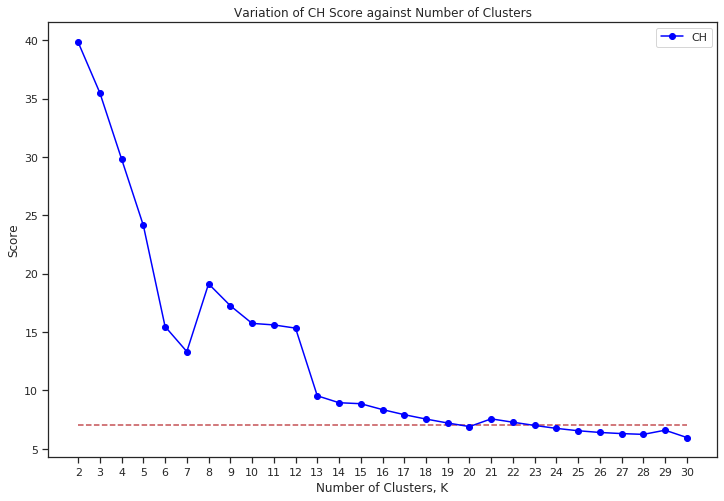

In [0]:
# Plot CH scores against number of clusters
plot_scores(k_values, [ch_scores], ['CH'], boundary = 7)

We use the boundary line of CH=7 to choose our 'optimal' clustering, which we will evaluate the usefulness of in the following analysis. This corresponds to an optimal number of clusters of 20, judging by the diagram.

In general for internal clustering criteria plots, we look for a point in the curve where a change in number of clusters stop leading to significant improvements, usually signified by an *elbow*. The above plot alone doesn't clearly show us which number of clusters is most effective, but we do see that after 20 clusters the CH score does jump back up before no further significant improvements.

If we only consider k=2 to k=13, this would lead us to a different conclusion, with k=7 and k=13 both being potential candidates for optimal clustering due to significantly better performance compared to results for number of clusters surrounding it. For example, k=7 may be an optimal number of clusterings as it's the lowest score up until that point, with all high values of k immediately afterwards leading to higher scores.

In [0]:
# Find the first k value such that the corresponding CH score is below 7
index = 0
while ch_scores[index] >= 7:
    index += 1

# Choose this clustering as our optimal clustering
k_optimal = k_values[index]
ch_optimal = ch_scores[index]

In [0]:
# Print optimal number of clusters and corresponding CH score
print('Optimal Number of Clusters: %.d \nCorresponding CH Score: %.3f' %(k_optimal, ch_optimal))

Optimal Number of Clusters: 20 
Corresponding CH Score: 6.897


Now that we have an 'optimal' number of clusters, we can define our K-Means model and begin evaluating it's performance

In [0]:
# Define optimal k means model
km_optimal = get_km_model(k_optimal)

### Evaluating the optimal clustering

To evaluate performance, we'll consider three internal clustering indexes (CH, Silhouette, Davies-Bouldin), look at the distribution of cluster sizes, and average distances to centroids. Here I include a brief summary of these results:

* Looking at **average distances of points to centroids gives strong evidence for an optimal k value of either 13 or 20**.
* CH and DB scores give some evidence of an optimal k value of 7, 13, and 20.
* Silhouette scores reveal nothing meaningful about the dataset.

The CH score for the 'optimal' model is 6.897. In general, if we have a smooth descending or increasing curve when we plot CH curve against number of clusters, a higher score indicates a better solution. This isn't the case in our plot, with adrupt spikes that disrupt the smooth decline in CH value. So this is why we looked for an elbow at the boundary line, where a solution is near a peak or subtle change in the way the curve descends. CH scoring is also most suitable in the case when clusters are spherical and tightly distributed in the middle close to the centroids, and CH prefers having roughly equally sized clusters.

#### Cluster Size

First, we consider the sizes of the clusters. The visualisation uses a log scale on the y-axis to emphasise clusters that have one datapoint as well as clearly showing the clusters with 10 to over 100 datapoints.

In [0]:
# Get predicted labels
cluster_labels = km_optimal.labels_

# Obtain cluster sizes
cluster_sizes = np.bincount(cluster_labels)

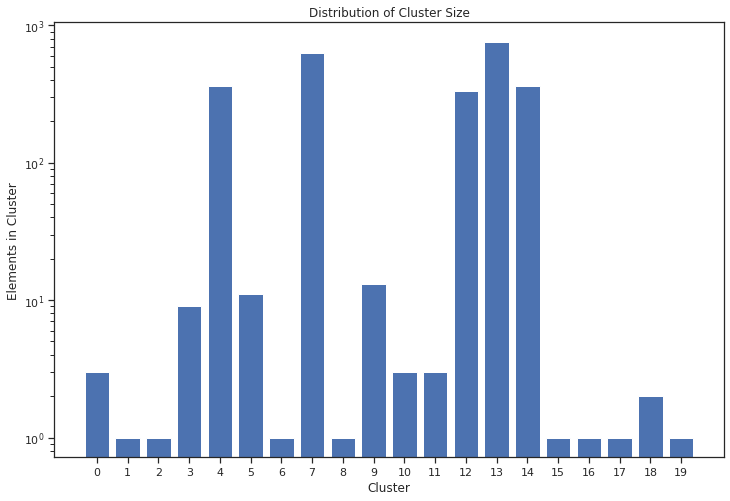

In [0]:
# Bar plot for distribution of cluster sizes
plt.bar(range(k_optimal), cluster_sizes)

# Figure
fig = plt.gcf()
fig.set_size_inches(12, 8)

# Use log scale on y axis
plt.yscale('log')

# Labelling
plt.xticks(range(k_optimal))
plt.xlabel('Cluster')
plt.ylabel('Elements in Cluster')
plt.title('Distribution of Cluster Size')
plt.show()


With 20 clusters, we see a wide variation in the cluster sizes. In particular, there are 7 clusters that have 1 member, and 7 clusters with over 100 members. The remaining clusters have between 1 and 10 members.

This may give some insight into why the CH score didn't give an obvious result for the number of clusters, as CH usually prefers more evenly distributed cluster sizes - it may be the case that the documents naturally form uneven sizes of groups.

#### Distances to Centroids

Given that K-Means models use distances to centroids in their training process, it is sensible to look at how the points in the optimal data set vary in distance to their own centroid and to centroids not belong to their cluster.

For each cluster, we average the distances of all data points to all of the cluster centroids. This gives us an average distance to centroid for a representative data point for each cluster.

In [0]:
# Reduce a distance to centroid dataframe into an average distance to centroid dataframe
def avg_dsts(df, num_clusters):
    summary_df = pd.DataFrame()
    for i in range(num_clusters):
        column = 'Distance to Centroid %.d' %(i)
        # Get the mean value for each dimension for each class
        summary_df[column] = df.loc[df['cluster'] == i].mean().drop('cluster')
    return summary_df

In [0]:
def get_avg_dsts_df(k, X, mini_batch = False):

    if mini_batch:
        model = MiniBatchKMeans(k, random_state = seed, n_init = 50).fit(X)
    else:
        # Get trained km model
        model = get_km_model(k, X)

    # Get labels and distances to centroids
    labels = model.predict(X)
    dsts = model.transform(X)

    # Structure the distances into a data frame
    dsts_df = pd.DataFrame(dsts)
    dsts_df['cluster'] = labels

    # Get the distances to centroids for the average point of each cluster
    distances = avg_dsts(dsts_df, k)

    return distances

In [0]:
# General function for a confusion matrix heatmap
def plot_avg_dsts_heatmap(df, title = '', cmap = 'GnBu', vmin = None, vmax = None):
    plt.figure(figsize = (20, 8))
    plt.title(title)
    sns.heatmap(df, annot = True, cmap = cmap, vmin = vmin, vmax = vmax)
    plt.xlabel('Average Distance to Centroid')
    plt.ylabel('Average Data Point of Each Cluster')
    plt.show()

In [0]:
# Get average distances to centroid
dsts_avg_df = get_avg_dsts_df(k_optimal, ftr)

Now we visualise the averages distances through a heatmap.

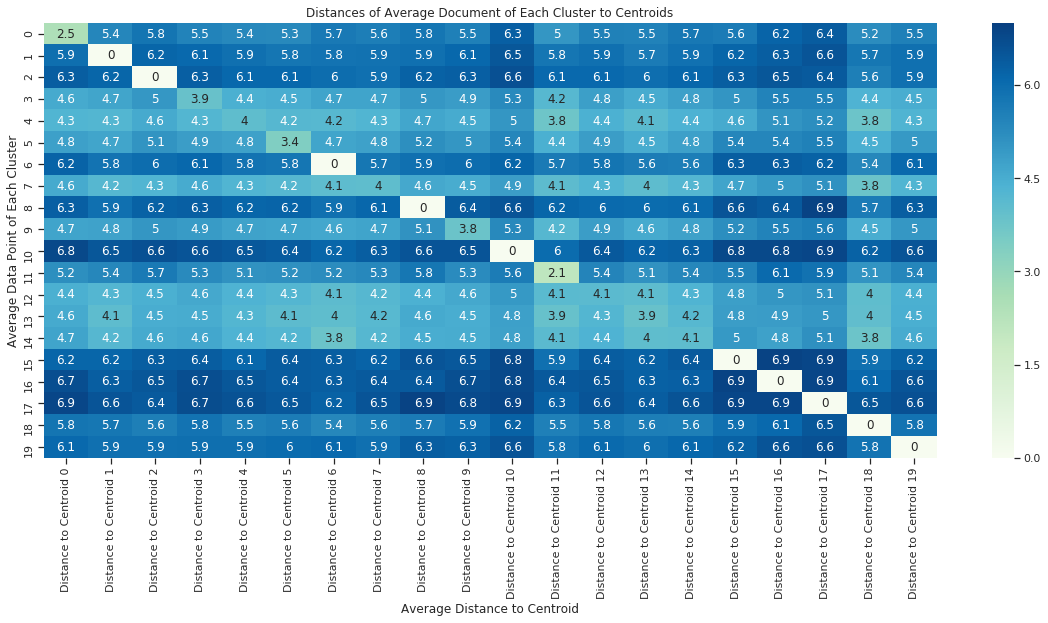

In [0]:
# Plot average distances
plot_avg_dsts_heatmap(dsts_avg_df, 'Distances of Average Document of Each Cluster to Centroids', vmin = 0, vmax = 7)

The above heatmap shows the average distance to each centroid - on the y-axis we have a representative point in each cluster, and on the x-axis we have centroids, and in the heatmap we have the distance of that representative point to the given centroid.

A perfect clustering would display an obvious diagonal line, with each representative point having low distance to its own centroid and high distances to all others. This would indicate well-seperatedness and denseness of cluster.

For k=20, **there are some clusters which are perfectly dense, indicated by a score of 0 for average distance to own cluster**. This is obviously the case for all clusters with 1 or 2 members, and this is also the case for one of two clusters with 3 members.

**Other clusters show some degree of well-seperatedness**, for example Cluster 0, with an average distance of 2.5 to Centroid 0 and distances of 4.3-6.9 to other clusters.

Some clusters show little evidence of well-seperatedness. For example, **Clusters 3, 4, 12, 13, and 14 are clearly not well seperated, with the average point in each one having similar distances to their own centroid and to the centroid of the others**. This shows that for k=20, there is still not perfect clustering occuring.

In further comparision, we will compare the average scores of internal and external centroid distances across different numbers of clusters to evaluate if k=20 was the optimal number of clusters. It may be that the seperations achieved here are as good as the model will allow.

#### Inertia

Inertia is a measurement that incorporates the sums of squares of distances to cluster centres. This is the metric that the K-Means algorithm aims to minimise, and we can have a look at how inertia varies in order to see how internally coherent the groupings are.

We plot the inertia against number of clusters to deduce whether we have the appropriate number of clusters when we define our model to have 25 individual clusters.

In [0]:
# Calculate inertia for a variety of number of clusters
inertias = []
for k in k_values:
    model = KMeans(n_clusters = k, random_state = seed, n_jobs = -1).fit(ftr)
    inertias.append(model.inertia_)

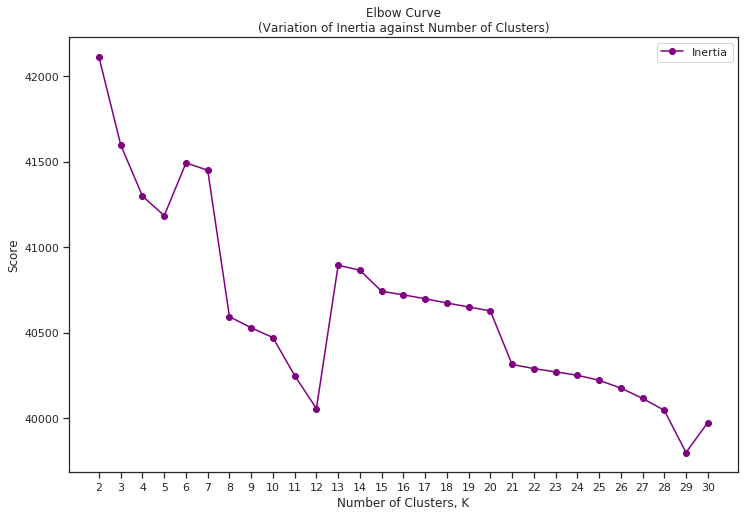

In [0]:
plot_scores(
    k_values,
    [inertias],
    labels = ['Inertia'],
    title = 'Elbow Curve\n(Variation of Inertia against Number of Clusters)',
    colours = ['purple']
    )

As expected, there is no smooth decline in inertia due to the complexity of the dataset.

As before, we look for *elbow*s in the curve to see at which point we see less improvement if we add more clusters. There are several points where the ascension or descension of the inertia is disrupted - at k=13 and k=21 in particular. At these two points, further increases in number of clusters doesn't appear to improve the model significantly immediately afterwards.

This appears to give stronger evidence for having 12 or 21 clusters instead of 20, as there is a drop off in ertia at these points after which there is not significant improvement. The lowest point of inertia is at 29, but this may lead to having too many classes in the dataset - we want to derive relationships by grouping documents together, and it's evident that the lowest inertia will come from a very high number of groups but this doesn't let us derive meaningful relationships about the similarities between datapoints.

#### Silhouette Coefficient

The Silhouette Coefficient is a statistic that we can used to measure the 'well-seperatedness' of our chosen clustering, as well as how dense the clusters are. It considers the distances between individual points, their centroid, and the closest centroid that they don't belong to. This is perhaps the most commonly used score in the literature, but it wont be appropriate for all datasets. We start with this score first due to its common usage.

For this statistic, the lowest possible value is -1 indicating completely incorrect clustering, and 1 being the highest possible value for highly dense clustering. A score near 0 means that there are overlapping clusters.

In [0]:
# Calculate Silhouette Score
sil_score = silhouette_score(ftr, cluster_labels)

# Print silhouette score
print('Silhouette Score: %.3f' %(sil_score))

Silhouette Score: 0.001


The silhouette score for the 'optimal' number of clusters does not give us much evidence for well chosen clusters, as we have a score that is effectively 0. This indiciates overlapping clusters.

We're not using a density based clustering method, such as DBSCAN, and so we expect the Silhouette Score to be lower than if we were using a density based cluster. This statistic may not be a useful one to observe to evaluate the quality of this clustering.

#### Davies-Bouldin Score

Similarly to the Silhouette Coefficient, the Davies-Bouldin (DB) Score can also be used to measure how well the clusters are seperated. It evaluates similarities between clusters, and differences within clusters.

For this statistic the minimum score is 0, and lower values indicate better clustering. However, this index isn't normalised so it's difficult to compare DB scores for different datasets.

In [0]:
# Calculate Silhoette Coefficient
db_score = davies_bouldin_score(ftr, cluster_labels)

print('Davies-Bouldin Score: %.3f' %(db_score))

Davies-Bouldin Score: 3.221


As previously stated, this index isn't normalised, and so it's not particularly helpful to just look at the DB score for the 'optimal' clustering. In further comparison, we'll see how DB score changes as the number of clusters is increased.

#### Further Comparison of Internal Clustering Scores

Now we look at how our various indexes change with different cluster sizes, as done previously with CH scoring.

We start with one plot with all the indexes mapped onto to observe general trends.

In [0]:
# Calculate silhouette scores for a variety of number of clusters
silhouette_scores = [km_score(k, scoring_fct = silhouette_score) for k in k_values]

In [0]:
# Calculate davies-bouldin scores for a variety of number of clusters
db_scores = [km_score(k, scoring_fct = davies_bouldin_score) for k in k_values]

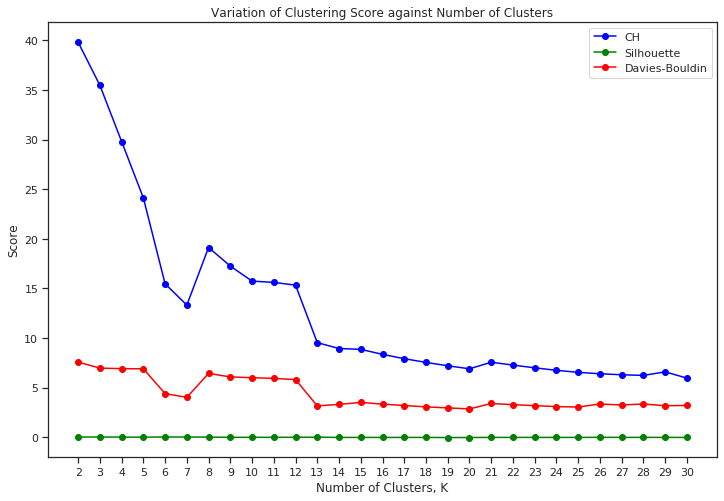

In [0]:
# Plot scores
plot_scores(
    k_values,
    [ch_scores, silhouette_scores, db_scores],
    labels = ['CH', 'Silhouette', 'Davies-Bouldin'],
    title = 'Variation of Clustering Score against Number of Clusters',
    )

The variation in the DB score does appear to follow a similar trend to the CH score, with elbows appearing in the same place. The DB appears to have less variation, particularly for smaller numbers of clusters, and an additional small peak at k=26 where the CH does not have one.

As expected due to the fact that the silhouette score varies between 1 and -1, this plot does not reveal the trends properly, so now we plot just the silhouette score.

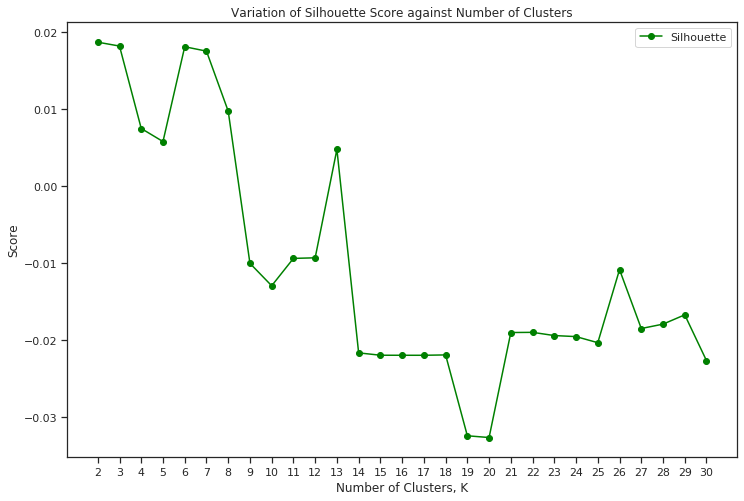

In [0]:
# Plot silhouette scores
plot_scores(
    k_values,
    [silhouette_scores],
    labels = ['Silhouette'],
    title = 'Variation of Silhouette Score against Number of Clusters',
    colours = ['green']
    )

There is very little variation in the silhouette score, varying between ~-0.04 and ~0.02. Due to this we can conclude that the silhouette score is not useful for this dataset.

However, the lowest silhouette score happens to be at the 'optimal' number of clusters. Though this indicates poor clustering for this index.

#### Further Analysis of Centroid Distances

Previously we analysed the average distances to centroid for just our 'optimal' number of clusters. Now, we average out the distances of all 'external' centroids to get two scores for each value for k in our K-Means algorithm:
* **Internal distance**: Average distance to own centroid.
* **External distance**: Average distance to other centroids.

These are calculated in the functions below by first calculating the distance to all centroids for the average data point in each cluster. The internal distance is then calculated by the distance of the average data point to its own cluster, and the external distance is calculated by the average distance of the average data point to centroids that aren't its own.

This will help us summarise the well-seperatedness and density of clusterings for a variety of values of k.

In [0]:
# Get average internal and external distances for a value of k
def get_avg_dst_in_out(k, X, mini_batch = False):

    # Get distance averages
    avg_dsts = get_avg_dsts_df(k, X, mini_batch)

    # Get average distance to own cluster
    inter_dsts = sum([avg_dsts.iloc[i][i] for i in range(k)]) / k

    # Get average distance to other clusters
    avgs = []
    for i in range(k):
        # Initialise
        dsts = 0
        for j in range(k):
            if i != j:
                # Sum all distances for a given average data point not including distance to own centroid
                dsts += avg_dsts.iloc[j][i]
        # Average out distances
        avg = dsts / (k - 1)
        avgs.append(avg)
    # Calculate external distance
    outer_dsts = sum(avgs) / k

    return inter_dsts, outer_dsts

In [0]:
# Get average distances to own and other centroids for range of number of clusters
def get_avg_dsts_in_out_range(X, k_range = k_values, mini_batch = False, print_progress = True):

    # Initialise lists
    ins = []
    outs = []

    for k in k_range:
        # Get average distances to own and other centroids
        value_in, value_out = get_avg_dst_in_out(k, X, mini_batch)

        # Add values to list
        ins.append(value_in)
        outs.append(value_out)

        if print_progress:
            # Print progress
            print('k = %.d complete' %(k))
    
    return ins, outs

In [0]:
%%time
# Get average distances to own and other centroids for range of number of clusters
avg_dst_to_ctr_in, avg_dst_to_ctr_out = get_avg_dsts_in_out_range(ftr)

k = 2 complete
k = 3 complete
k = 4 complete
k = 5 complete
k = 6 complete
k = 7 complete
k = 8 complete
k = 9 complete
k = 10 complete
k = 11 complete
k = 12 complete
k = 13 complete
k = 14 complete
k = 15 complete
k = 16 complete
k = 17 complete
k = 18 complete
k = 19 complete
k = 20 complete
k = 21 complete
k = 22 complete
k = 23 complete
k = 24 complete
k = 25 complete
k = 26 complete
k = 27 complete
k = 28 complete
k = 29 complete
k = 30 complete
CPU times: user 7.32 s, sys: 3.75 s, total: 11.1 s
Wall time: 4min 8s


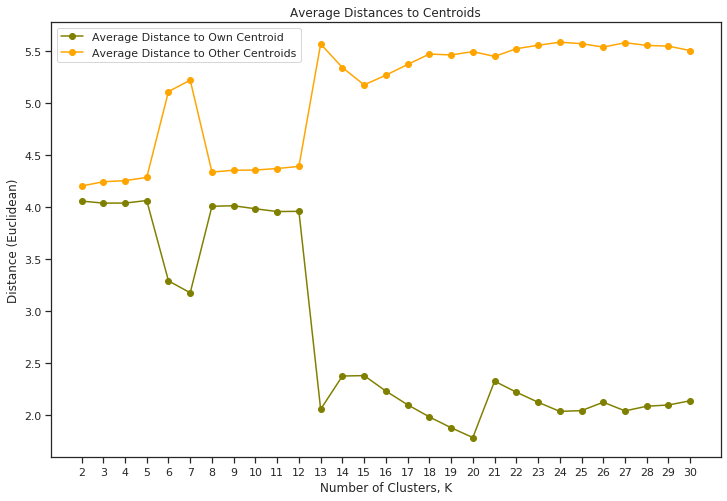

In [0]:
# Plot average distances
plot_scores(
    k_values,
    [avg_dst_to_ctr_in, avg_dst_to_ctr_out],
    ['Average Distance to Own Centroid', 'Average Distance to Other Centroids'],
    title = 'Average Distances to Centroids',
    ylabel = 'Distance (Euclidean)',
    colours = ['olive', 'orange']
    )

Finally, this plot gives us **clear evidence for an optimal number of clusters of 13 or 20**.

At k=13, we see a considerable drop off in internal distance and a sharp rise in external distance compared to previous values of k, with higher values of k immediately afterwards going in the opposite directions without leading to significant improvements. This indicates that **at k=13, clusters are suddenly much more dense and more seperated to other clusters**.

The above behaviour occurs again, on a smaller scale, at k=20.

This provides much clearer evidence for optimal number of clusters than our internal clustering criteria looked at previously.

### Robustness of Results

Randomness has a large affect on the k-means algorithm due to how the centroids are randomly assigned in the first round. In the above we counteracted this by setting the number of times the k-means algorithm runs with different initial centroids as 10, with the final output corresponding to the best of these 10 when considering inertia.

This is necessary, as if the algorithm is just ran one time then it may be the case that two initial centroids are placed next to eachother in a part of the dataset that only requires one cluster to be formed.

This repetition means that we increase the robustness of the results, as it's more likely that within the 10 runs of the algorithm one of the initial centroid seeds leads to the optimal selection of clusters. In order to increase robustness and reliability, the number of runs should be increased to as a far as is computationally possible.

Other algorithms, such as Mini Batch K-Means Clustering, would permit us to increase the number of initial runs further. This was deemed unnecessary for Task 1.1, but this method is utilised in Task 2.1 where the dimensionality of the data causes the standard K-Means Clustering algorithm to be computationally expensive.

## Task 1.2 - Analysis of the citation graph

As well as the feature matrix detailing the text within documents, we have an adjacency matrix which describes a network relating the documents - two documents are connected in the network if there is an undirected ditation that connects them.

In this task we use the NetworkX package to visualise this network of citations, and then we use graph analytical tools to study how central documents are in the network.

In [0]:
# Convert adjacency matrix to NetworkX format
A = nx.from_numpy_matrix(adj.values)

In [0]:
%%time
# Generate a standard positioning for all graphs
standard_pos = nx.kamada_kawai_layout(A)

CPU times: user 2min 15s, sys: 464 ms, total: 2min 16s
Wall time: 2min 16s


In [0]:
# Function for plotting a given network
def plot_network(
    graph = A,
    title = '',
    node_colors = 'green',
    edge_transparency = 0.2,
    node_transparency = 0.5,
    node_size = 4,
    pos = standard_pos,
    cmap = None
    ):

    if pos != standard_pos:
        pos = nx.spring_layout(graph)

    # Plot network from adjacency matrix of citation graph
    nx.draw_networkx_nodes(
        graph,
        pos,
        node_size = node_size,
        alpha = node_transparency,
        with_labels = False,
        node_color = node_colors,
        cmap = cmap
        )
    
    # Edges
    nx.draw_networkx_edges(graph, pos, alpha = edge_transparency)

    # Figure
    fig = plt.gcf()
    fig.set_size_inches(18, 10)
    plt.title(title)
    plt.axis('off')

    if cmap != None:

        # Colour bar

        min_c = min(node_colors)
        max_c = max(node_colors)

        cmap = plt.cm.get_cmap(cmap, max_c - min_c + 1)

        sm = plt.cm.ScalarMappable(cmap = cmap, norm = plt.Normalize(vmin = min_c, vmax = max_c))
        sm.set_array([])
        cbar = plt.colorbar(sm)
        
        cbar.set_ticks(range(max_c + 1))
        cbar.set_ticklabels(range(max_c + 1))
        cbar.set_label('Group')


    plt.show()

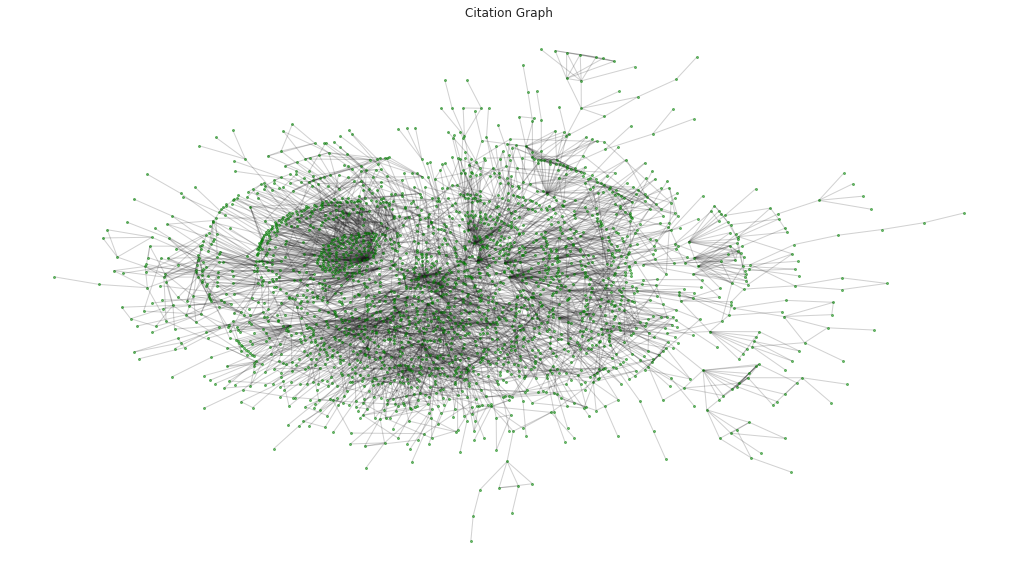

In [0]:
# Plot the citation graph
plot_network(A, 'Citation Graph')

Here we have a visualisation of the entire network. Each node corresponds to a paper, and each arc corresponds to a citation.

The most dense section of the graph appears to be just to the left of the centre, where there are two clear rows of nodes that connect inwards. If we could label each node, we'd be able to clearly see what groups of papers are related to each other, and find which are the most important by seeing which are the most central to this dense grouping of nodes.

Firstly, in order to understand this graph better we start by observing the distribution of degrees of nodes within the graph.

In [0]:
# Calculate degrees of nodes in A
A_deg = [degree for (node, degree) in A.degree()]

In all plots in this section, below we use a log scale on the y axis for the frequency

Below, this scale clearly emphasises nodes that have a degree of one as well as nodes that have degrees that go into the hundreds.

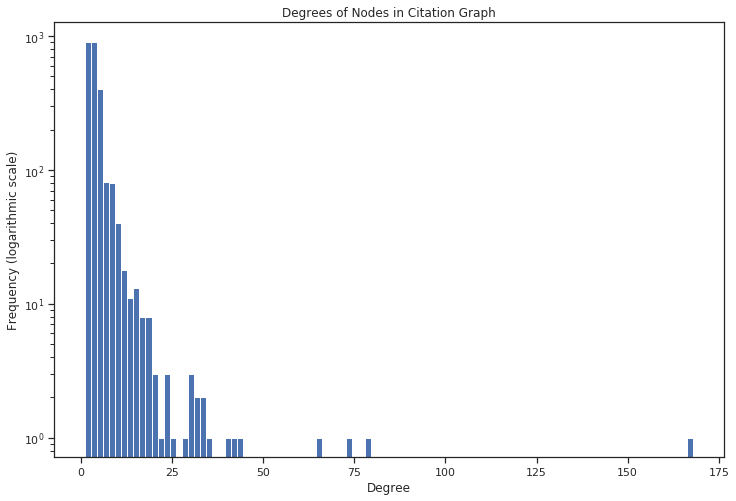

In [0]:
# Histogram of degress in adjacency graph
plt.hist(A_deg, bins = 100)
fig = plt.gcf()
fig.set_size_inches(12, 8)

# Use log scale on frequency
plt.yscale('log')

# Labelling
plt.xlabel('Degree')
plt.ylabel('Frequency (logarithmic scale)')
plt.title('Degrees of Nodes in Citation Graph')
plt.show()

There are no nodes with a degree of 0 - this means that all the papers have at least one of paper that have a citation between them.

There are 4 nodes that have a very high degree of over 50. There is one node with a very high degree of over 150, with the second highest degree trailing behind it with around half this number. This indicates that **there are a small number of papers that are cited particularly frequently** by other papers, with one paper in particular being very highly cited.

This assumes a direction to the citation, it could also be the case that these papers are citing a very large number of other papers despite not being cited much themselves, but this seems less intuitive in context.

The paper with the highest degree in the network is likely to be a very important, perhaps fundamental or introductory, paper in the field of research that the papers are concerned with.

### Centrality Measurements

Now we concern ourselves with indicators of centrality to find the most important papers in the network. The measurements we use will attempt to assign a score to each node to determine how central, or how important, it is within the graph.

After calculating the centralities and observing the distribution plots for all three measurement types, we will find out which nodes are highly central in one comparison table, and whether these nodes are the same across different measurements.

#### Degree

We start with degree centrality, which is simply the degree of each node divided by the number of nodes in the graph.

In [0]:
%%time
# Compute centrality using degree as the measurement
ctr_deg = nx.degree_centrality(A)

CPU times: user 2.25 ms, sys: 3 µs, total: 2.25 ms
Wall time: 2.27 ms


In [0]:
# Histogram showing distribution of centrality measurements
def plot_ctr_distribution(centrality, measurement):
    plt.hist(list(centrality.values()), bins = 100)
    fig = plt.gcf()
    fig.set_size_inches(12, 8)

    # Use log scale on frequency
    plt.yscale('log')

    # Labelling
    plt.xlabel('Centrality (' + measurement + ')')
    plt.ylabel('Frequency')
    plt.title('Distribution of Centrality Measurement')
    plt.show()

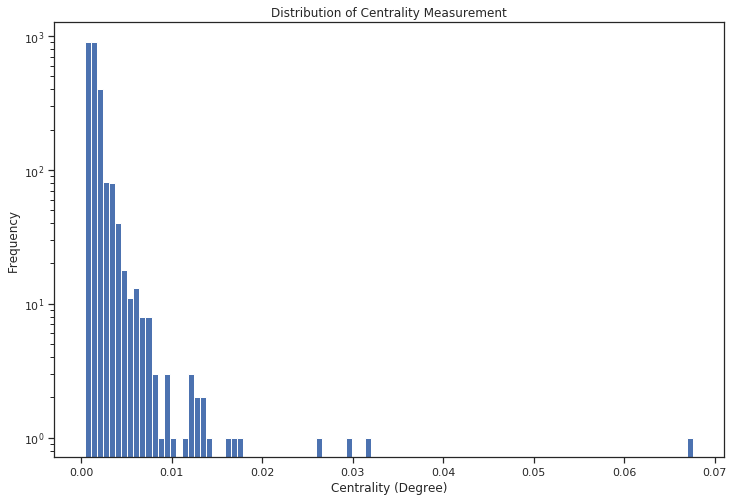

In [0]:
plot_ctr_distribution(ctr_deg, 'Degree')

Due to the definition of this centrality measurement, this plot has the same exact shape as the plot for degree distribution.

Once again, there are no plots with a centrality measurement of 0, and four nodes with comparitively higher measurements than all others.

#### Betweenness

Betweenness determines how many times each vertex acts as a connecting node in the shortest path between two other vertices. Simply put, we compute all the shortest paths for all pairs of vertices, and then betweeness for a node N is computed by determining the fraction of total shortest paths paths passing through N.

In [0]:
%%time
# Compute centrality using betweenness as the measurement
ctr_btw = nx.betweenness_centrality(A)

CPU times: user 28.1 s, sys: 9.45 ms, total: 28.1 s
Wall time: 28.2 s


In [0]:
plot_ctr_distribution(ctr_btw, 'Betweenness')

Centrality is generally higher here, with the most highly central node having a betweenness measurement of over 0.25 and a degree measurement of just over 0.06. The importance of the one highly central node is being inflated in this measurement, meaning that it's likely to be in a high number of shortest paths between vertices instead of simply having a high number of citations.

This time there are many, in fact the plurality of, nodes with a 0 measurement. This is evident, as all nodes on the outskirt of the graph will have a betweenness centrality of 0. Such nodes can be observed on the diagram above.

This measurement took significantly longer to compute, which is down to having to compute all possible shortest paths first before calculating the centrality. Calculating shortest paths is not a trivial computation, whereas counting degrees of nodes is computationally simple.

Betweenness centrality also reveals a higher number of highly central nodes, with 7 nodes having a score above ~0.075. This measurement also clearly differentiates the second most central node from the rest below it.

#### PageRank

PageRank is similar to the other measurements in that it uses the arcs between nodes to measure importance, with scores being assigned by the number of arcs connected to a node. However, each of these individual connections is weighted by the score of the node on the other side. Therefore it's not as simple as the degree centrality where we simply count the number of connections.

In [0]:
%%time
# Compute centrality using pagerank as the measurement
ctr_pgr = nx.pagerank(A)

CPU times: user 437 ms, sys: 1.99 ms, total: 439 ms
Wall time: 447 ms


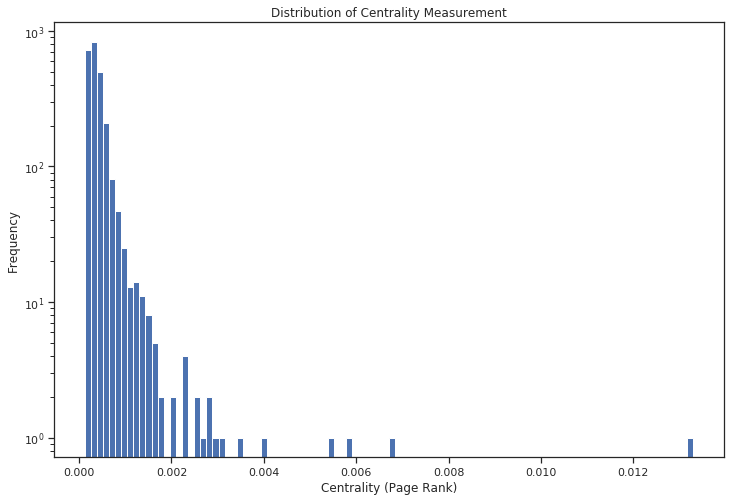

In [0]:
plot_ctr_distribution(ctr_pgr, 'Page Rank')

Interestingly, this plot produces a very similar shape to that of the degree centrality, but with much lower scores in general - the most central node has a score of just over 0.012 instead of just under 0.07.

Again, there are no nodes with a score of 0, as all nodes have at least one connection and this connection can't be given a weighting of 0. There appear to be four nodes that are significantly more central to the rest.

In further comparison, we'll study whether the highly central nodes in question are similar between the different measurements.

#### Comparison of Rankings - Rank Coefficients

In the above, there is an implicit ranking of nodes dependant on how central they are according to each measurement. In the following, we aim to deduce if these rankings are similar, to see if each centrality measurement produces similar nodes as being highly central.

We will study these ranks first by considering measurements of rank correlation such as Spearman's Rank Correlation Coefficient, and by observing a correlation plot.

First we compute a list that tells us the ranking of nodes.

In [0]:
# General function for sorting dictionaries by value into a list
def sort_dict_items(dict):
    return sorted(dict.items(), key = itemgetter(1), reverse = True)

In [0]:
# Get lists of nodes sorted by centrality.
ctr_deg_s = sort_dict_items(ctr_deg)
ctr_btw_s = sort_dict_items(ctr_btw)
ctr_pgr_s = sort_dict_items(ctr_pgr)

In [0]:
# Function for printing centralities from highest to lowest
def print_centrality_rankings(rows = 10, print_info = True):
    print('-- Ranking of nodes by centrality measurement --')
    
    t = PrettyTable(['Centrality Ranking', 'Degree', 'Betweenness', 'Page Rank'])
    for i in range(rows):

        if print_info:
            # Print the centrality measurement as well as the node
            t.add_row([
                      i + 1,
                      'Node %.d (Centrality: %.3f)' %(ctr_deg_s[i][0], ctr_deg_s[i][1]),
                      'Node %.d (Centrality: %.3f)' %(ctr_btw_s[i][0], ctr_btw_s[i][1]),
                      'Node %.d (Centrality: %.3f)' %(ctr_pgr_s[i][0], ctr_pgr_s[i][1])
                      ])
        
        else:
            # Only print the nodes for each ranking
            t.add_row([
                      i + 1,
                      ctr_deg_s[i][0],
                      ctr_btw_s[i][0],
                      ctr_pgr_s[i][0]
                      ])
    print(t)

In [0]:
# Detailed observation of centrality ranking
print_centrality_rankings()

-- Ranking of nodes by centrality measurement --
+--------------------+-------------------------------+-------------------------------+-------------------------------+
| Centrality Ranking |             Degree            |          Betweenness          |           Page Rank           |
+--------------------+-------------------------------+-------------------------------+-------------------------------+
|         1          | Node 1245 (Centrality: 0.068) | Node 1245 (Centrality: 0.276) | Node 1245 (Centrality: 0.013) |
|         2          |  Node 271 (Centrality: 0.031) | Node 1846 (Centrality: 0.150) | Node 1563 (Centrality: 0.007) |
|         3          | Node 1563 (Centrality: 0.030) | Node 1894 (Centrality: 0.106) | Node 1846 (Centrality: 0.006) |
|         4          | Node 1846 (Centrality: 0.026) | Node 1563 (Centrality: 0.101) |  Node 271 (Centrality: 0.006) |
|         5          | Node 1672 (Centrality: 0.018) |  Node 271 (Centrality: 0.091) | Node 1672 (Centrality: 0.004) |

The printed table above clearly describes the ranking of nodes according to there measurements - I've included the centrality measurement in parenthesis for comparison.

As our centrality histograms indicated, **there is one paper - Node 1245 - which is the most central** for all three measurements. As previously indicated, the importance of this node is boosted in the betweenness measurement with a score of 0.276 compared to 0.068 and 0.013 for the other two.

After the top rank, the rankings start to differentiate more. However we can see that Nodes 1846, 271 and 1563 all consistently occupy top spots. This is **strong evidence that there are four papers that are very important** when considering citations between papers.

Now we'll try to evaluate the similarity of these rankings more generally with ranking coefficients.

In [0]:
# Calculate node rankings for each of the centrality measurements
ctr_deg_s_node = [node for (node, measurement) in ctr_deg_s]
ctr_btw_s_node = [node for (node, measurement) in ctr_btw_s]
ctr_pgr_s_node = [node for (node, measurement) in ctr_pgr_s]

In [0]:
# General function for getting a list of rankings indexed by nodes
def get_ranking_indexed_by_node(nodes_indexed_by_rank):
    ranking_idx_by_node = [0]*len(nodes_indexed_by_rank)

    for i in range(len(nodes_indexed_by_rank)):
        node = nodes_indexed_by_rank[i]
        ranking_idx_by_node[node] = i

    return ranking_idx_by_node

In [0]:
# Get rankings indexed by node
ctr_deg_ranking_idx_by_node = get_ranking_indexed_by_node(ctr_deg_s_node)
ctr_btw_ranking_idx_by_node = get_ranking_indexed_by_node(ctr_btw_s_node)
ctr_pgr_ranking_idx_by_node = get_ranking_indexed_by_node(ctr_pgr_s_node)

Kendall's Weighted Tau correlation coefficient measures the similarity in rankings of two lists, placing more emphasis on the head of the list than the tail.

In [0]:
# Calculate weighted tau coefficients
tau_12, _ = stats.weightedtau(ctr_deg_ranking_idx_by_node, ctr_btw_ranking_idx_by_node)
tau_13, _ = stats.weightedtau(ctr_deg_ranking_idx_by_node, ctr_pgr_ranking_idx_by_node)
tau_23, _ = stats.weightedtau(ctr_btw_ranking_idx_by_node, ctr_pgr_ranking_idx_by_node)

Spearman's Rank Correlation Coefficient also measures similarity in rankings of two lists, but doesn't have additional weighting for the head of the list.

In [0]:
# Calculate spearman rank-order coefficients.
spr_12, _ = stats.spearmanr(ctr_deg_ranking_idx_by_node, ctr_btw_ranking_idx_by_node)
spr_13, _ = stats.spearmanr(ctr_deg_ranking_idx_by_node, ctr_pgr_ranking_idx_by_node)
spr_23, _ = stats.spearmanr(ctr_btw_ranking_idx_by_node, ctr_pgr_ranking_idx_by_node)

In [0]:
# Print the correlation coefficient values
ranking_comp = PrettyTable(['Measurement 1', 'Measurement 2', 'Ranking Similarity (Weighted Tau)', 'Ranking Similarity (Spearman)'])
ranking_comp.add_row(['Degree', 'Betweenness', '%.3f' %(tau_12), '%.3f' %(spr_12)])
ranking_comp.add_row(['Degree', 'Page Rank', '%.3f' %(tau_13), '%.3f' %(spr_13)])
ranking_comp.add_row(['Betweenness', 'Page Rank', '%.3f' %(tau_23), '%.3f' %(spr_23)])
print('-- Similarity of Node Rankings of Centrality Measurements --')
print(ranking_comp)

-- Similarity of Node Rankings of Centrality Measurements --
+---------------+---------------+-----------------------------------+-------------------------------+
| Measurement 1 | Measurement 2 | Ranking Similarity (Weighted Tau) | Ranking Similarity (Spearman) |
+---------------+---------------+-----------------------------------+-------------------------------+
|     Degree    |  Betweenness  |               0.820               |             0.739             |
|     Degree    |   Page Rank   |               0.792               |             0.934             |
|  Betweenness  |   Page Rank   |               0.654               |             0.771             |
+---------------+---------------+-----------------------------------+-------------------------------+


Both ranking coefficients provide **strong evidence for similarity between the rankings** according to the three measurements.

In particular, the Spearman's Rank Correlation Coefficient for degree and PageRank is comparitively very high at 0.934, indicating near-perfect similarity in their rankings. This is likely due to the similar approach that they take when assigning centralities.

Interestingly, if we use Weighted Tau, where the elements at the top of the list are given more weight, degree and betweenness have the highest similarity. This may be due to the fact that for highly central nodes that are ranked highly, having a high degree will make it more likely that the node is in a shortest path and vice-versa. This will lead to a higher similarity in rankings between degree and betweenness.

#### Comparison of Rankings - Correlation Plot

Now we will visualise these rankings in correlation plots to observe how similar.

In [0]:
# Calculate node rankings for each of the centrality measurements
ctr_deg_s_measurement = [measurement for (node, measurement) in ctr_deg_s]
ctr_btw_s_measurement = [measurement for (node, measurement) in ctr_btw_s]
ctr_pgr_s_measurement = [measurement for (node, measurement) in ctr_pgr_s]

# Format the rankings into a dataframe
centrality_rankings = pd.DataFrame(
    {'Degree': ctr_deg_s_measurement,
     'Betweenness': ctr_btw_s_measurement,
     'Page Rank': ctr_pgr_s_measurement
    })

In [0]:
# Observe the dataframe to see exactly what it's showing
centrality_rankings.head()

Degree  Betweenness  Page Rank
0  0.067633     0.276114   0.013302
1  0.031401     0.149763   0.006811
2  0.029791     0.106109   0.005833
3  0.026167     0.101355   0.005511
4  0.017713     0.090707   0.003957

The centrality measurements are indexed by their rank.

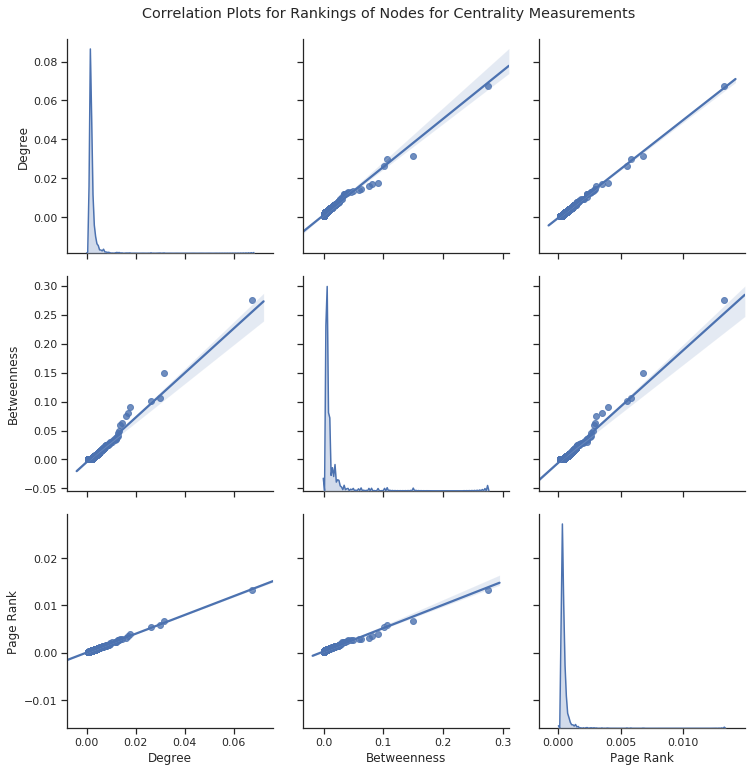

In [0]:
# Pair plot for correlations
sns.pairplot(
    centrality_rankings,
    height = 3.5,
    diag_kind = 'kde',
    kind = 'reg',
)
plt.suptitle('Correlation Plots for Rankings of Nodes for Centrality Measurements', y = 1.02)
plt.show()

The plots appear to show strong degrees of correlation between rankings, particularly between degree and PageRank. This is consistent with our rank correlation coefficients above. We can see the lower amount of agreement in degree and betweenness, and PageRank and betweenness.

Now we take out the one highly central node to see if we can get more clarity in the rest of the network.

In [0]:
# Pair plot for correlations, removing the outlying highly central node
sns.pairplot(
    centrality_rankings[1:],
    height = 3.5,
    diag_kind = 'kde',
    kind = 'reg',
)
plt.suptitle('Correlation Plots for Rankings of Nodes for Centrality Measurements\n(Outlying Highly Central Node Removed)', y = 1.05)
plt.show()

The above pair plot shows the rest of the highly central nodes more clearly. We can see that there is a high degree of agreement in ranking for degree and betweenness for the highly central nodes, and there is again high levels of correlations for all rankings.

Again, the variation in rankings for degree and betweenness, and betweenness and PageRank, is clear.

#### Further Comparison

For final visual comparison, we will plot the citation graph again but only for the 200 most central nodes - we repeat this in Task 1.3 for just PageRank and Degree, so I will only briefly discuss this here.

In [0]:
# General function for getting a subgraph from sorted nodes of a graph
def get_subgraph(sorted_nodes, number, graph = A):
    selected_nodes = sorted_nodes[:number]
    subgraph = nx.subgraph(A, selected_nodes)
    return selected_nodes, subgraph

In [0]:
# Define subgraphs of the citation graph for only the highest ranked notes
_, subgraph_top_deg = get_subgraph(ctr_deg_s_node, 200)
_, subgraph_top_btw = get_subgraph(ctr_btw_s_node, 200)
_, subgraph_top_pgr = get_subgraph(ctr_pgr_s_node, 200)

In [0]:
# Plot subgraph for highest ranked nodes according to degree measurement
plot_network(
    subgraph_top_deg,
    'Limited Citation Graph (Highest Ranked Nodes according to Degree)',
    edge_transparency = 0.3,
    node_transparency = 1,
    node_size = 15,
    pos = nx.kamada_kawai_layout
)

In [0]:
# Plot subgraph for highest ranked nodes according to betweenness measurement
plot_network(
    subgraph_top_btw,
    'Limited Citation Graph (Highest Ranked Nodes according to Betweenness)',
    edge_transparency = 0.3,
    node_transparency = 1,
    node_size = 15,
    pos = nx.kamada_kawai_layout
)

As expected, the subgraph for highly central nodes according to Betweenness does not produce a high number of nodes unconnected on the outskirts - nodes that are in many shortest paths are likely to be connected to other such nodes.

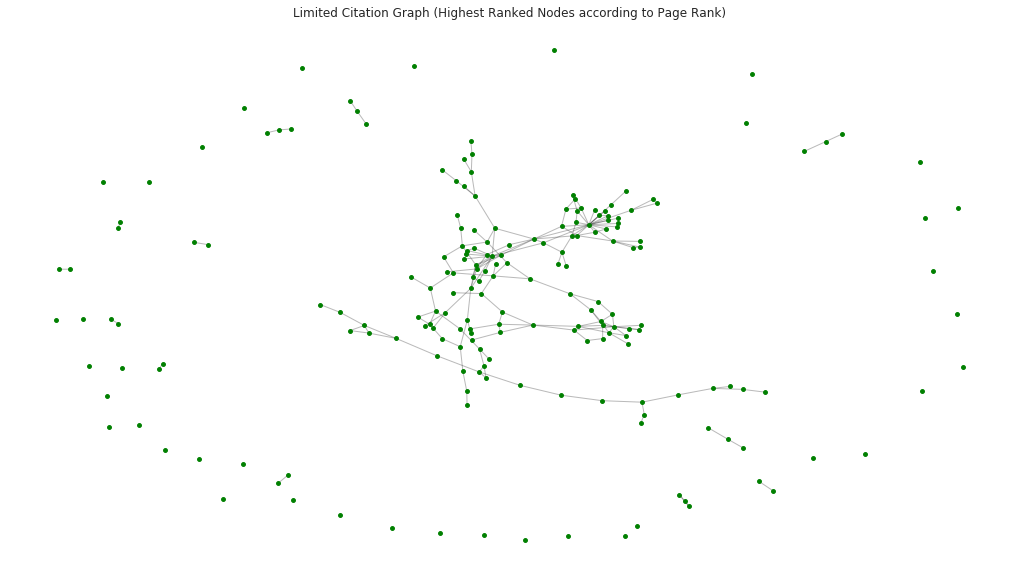

In [0]:
# Plot subgraph for highest ranked nodes according to page rank measurement
plot_network(
    subgraph_top_pgr,
    'Limited Citation Graph (Highest Ranked Nodes according to Page Rank)',
    edge_transparency = 0.3,
    node_transparency = 1,
    node_size = 15,
    pos = nx.kamada_kawai_layout
)

The subgraph using PageRank is similar in shape to that of Degree, with many nodes lying on the outskirts  as well as in the centre - this is mirrored by the fact that no nodes will get a measurement of 0 for PageRank or Degree, which isn't the case for Betweenness.

## Task 1.3 - Community detection on the citation graph

The citation graph can also be analysed to see if there any communities of nodes. This is the study of community structure, where we try to find communities of nodes to split up the network into, where nodes in a community are densely connected to eachother and sparsely connected to nodes outside of the community.

We'll attempt to find the optimal number of communities using modularity maximisation. After this we'll visualise the communities using the NetworkX package, and study how to highly central nodes are distributed within these communities.

### Clauset-Newman-Moore Greedy Modularity Maximisation

We use Clauset-Newman-Moore's Greedy Modularity Maximisation algorithm  to split the network into communities. Modularity maximisation detects communities by calculating the modularity, being used as a cost function, for many possible divisions of the network. The resulting communities are that which give the highest possible modularity. [1]

Searching over all possible communities is computationally prohibitive, which is why we use this greedy algorithm that balances accuracy with computational cost and speed.

In this algorithm, the nodes are partitioned so that they belong to exactly one community.

In [0]:
# Get communities using Clauset-Newman-Moore greedy modularity maximisation.
c = list(greedy_modularity_communities(A))

In [0]:
# Print optimal number of communities
print('Optimal Number of Communities, k* : %.d' %(len(c)))

Optimal Number of Communities, k* : 29


The algorithm tells us that the optimal number of communities for our citation graph is 29. Now we can observe these communities.

In [0]:
# Format communities into arrays
c_arr = [np.ravel(sorted(community)) for community in c]

In [0]:
# Create a dictionary for getting the community of a node
c_dict = {}

for c_index in range(len(c_arr)):
    for node in c_arr[c_index]:
        c_dict[node] = c_index

This dictionary gives us the partitioning of the citation graph by providing the community for a given node.

We can visualise these communities by colouring nodes accordingly.

In [0]:
# A list such that index is node, and entry is the corresponding community.
# - This is done to convert the dictionary into a list format for use with NetworkX
c_by_node = [community for (node, community) in sorted(list(c_dict.items()))]

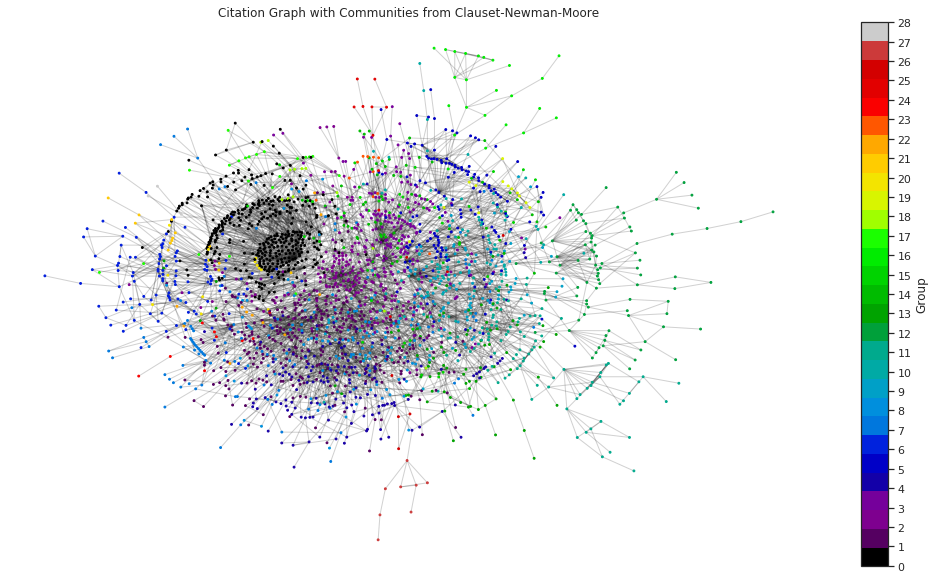

In [0]:
# Plot citation graph with communities from Clauset-Newman-Moore coloured.
def plot_citation_graph_cnm():
    plot_network(
        A,
        'Citation Graph with Communities from Clauset-Newman-Moore',
        node_colors = c_by_node,
        edge_transparency = 0.2,
        node_transparency = 1,
        node_size = 3.5,
        cmap = 'nipy_spectral'
        )
    
plot_citation_graph_cnm()

The above plot is our original diagram for the full citation graph, but this time the nodes are coloured according to which community they belong to.

Due to how it is difficult to distinguish some of the colours for such a high number of nodes, this colouring is used to show general trends of how the communities are being distributed, particularly for the most important communities, instead of as a direct reference for each node.

We can see a large block of black nodes, indicating a large community to which the most highly central node belongs. Interestingly, this block is surrounded by yellow/orange nodes, indicating communities 18 to 20.

The remainder of the larger communities are located more centrally in the graph.

#### Community Sizes

Previously, we knew that as the index for our community increased the size of the community decreased, simply from the working of the NetworkX package when calculating the communities.

To further examine the community sizes we plot the following histogram.

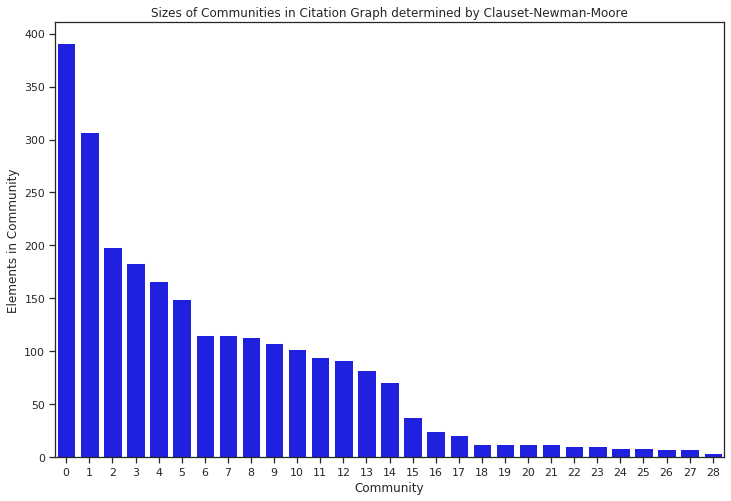

In [0]:
# Bar plot
sns.countplot(x = c_by_node, color = 'blue')

# Figure
fig = plt.gcf()
fig.set_size_inches(12, 8)

# Labelling
plt.xticks(range(max(c_by_node) + 1))
plt.xlabel('Community')
plt.ylabel('Elements in Community')
plt.title('Sizes of Communities in Citation Graph determined by Clauset-Newman-Moore')
plt.show()

This shows what we can see in the above network diagram - there are two communities that have a very high number - over 300 - of nodes. Communities 18 to 28 have very few nodes between them.

Modularity optimisation often can't detect communities smaller than some size, with this depending on how big the graph is. This is refered to as resolution limit. 

### Exploration of Highly Central Nodes

Now, we repeat the same method carried out at the end of Task 1.2, where we limit the citation graph to highly central nodes, this time to see how these nodes are distributed within the communities.

#### Get Rankings

First we get the communities and the rankings for the top 30 ranked nodes according to PageRank and Degree centralities.

In [0]:
def get_communities_for_nodes(c_dictionary, nodes):
    communities = [c_dictionary[node] for node in nodes]
    return communities

In [0]:
# Get highly central nodes according to degree and page rank and corresponding subgraph
nodes_top30_deg, subgraph_top30_deg = get_subgraph(ctr_deg_s_node, 30)
nodes_top30_pgr, subgraph_top30_pgr = get_subgraph(ctr_pgr_s_node, 30)

In [0]:
# Get communities of highly central nodes
comms_top30_deg = get_communities_for_nodes(c_dict, nodes_top30_deg)
comms_top30_pgr = get_communities_for_nodes(c_dict, nodes_top30_pgr)

#### Distribution of Nodes within Communities
We plot a histogram for the number of nodes in each community as before, but only for the top 30 most central nodes according to degree and page rank.

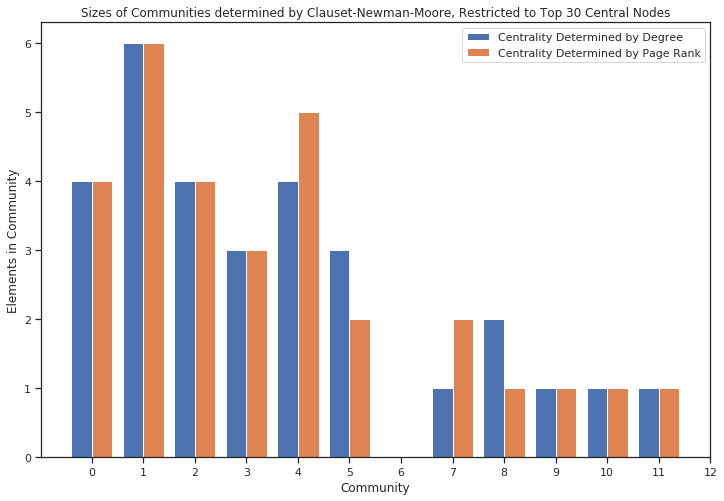

In [0]:
# Get maximum number of communities for x axis labelling
max_comms = max(max(comms_top30_deg), max(comms_top30_pgr)) + 2
bins = np.arange(max_comms) - 0.5

# Plot count plot for number of nodes in each community
plt.hist([comms_top30_deg, comms_top30_pgr], label = ['Centrality Determined by Degree', 'Centrality Determined by Page Rank'], bins = bins)

# Figure
fig = plt.gcf()
fig.set_size_inches(12, 8)

# Labelling
plt.xticks(range(max_comms))
plt.xlabel('Community')
plt.ylabel('Elements in Community')
plt.legend()
plt.title('Sizes of Communities determined by Clauset-Newman-Moore, Restricted to Top 30 Central Nodes')
plt.show()

The histogram shows that the top 30 most central nodes according to both algorithms are very similarly distributed, with the only differences occuring in the number of elements in communities 4, 5, and 7.

As expected, the top 30 most central nodes are contained within the first 11 communities - interestingly, none of the most central nodes according to either measurement are contained in the community 6.

Our previous analysis showed some similarity in the rankings of the nodes particularly for the top end of the list, so it makes sense that the distribution of community size is fairly consistent in this analysis.

#### Nodes in Common

We can also look at the nodes that the two rankings have in common.

In [0]:
nodes_in_common = list(set.intersection(set(nodes_top30_deg), set(nodes_top30_pgr)))
print('Number of nodes in common in both limited subgraphs: %.d' %(len(nodes_in_common)))

Number of nodes in common in both limited subgraphs: 28


We can see that both lists have 28 nodes in common, leaving only 4 nodes that don't appear in both rankings for the top 30 most central nodes.

In [0]:
# Get nodes not in degree ranking
uncommon_nodes = set.symmetric_difference(set(nodes_top30_deg), set(nodes_top30_pgr))

print('Nodes not in common: ', list(uncommon_nodes))

Nodes not in common:  [393, 1295, 1298, 600]


#### Ranking List Comparison

As before, we can also print a list to precisely look at how the ranking is similar for the top 30 nodes.

In [0]:
# Function for printing centralities from highest to lowest
def print_centrality_rankings_degpgr(rows = 30, print_info = True):
    print('-- Ranking of nodes by centrality measurement --')
    
    t = PrettyTable(['Centrality Ranking', 'Degree', 'Page Rank'])
    for i in range(rows):

        if print_info:
            # Print the centrality measurement as well as the node
            t.add_row([
                      i + 1,
                      'Node %.d (Centrality: %.3f)' %(ctr_deg_s[i][0], ctr_deg_s[i][1]),
                      'Node %.d (Centrality: %.3f)' %(ctr_pgr_s[i][0], ctr_pgr_s[i][1])
                      ])
        
        else:
            # Only print the nodes for each ranking
            t.add_row([
                      i + 1,
                      ctr_deg_s[i][0],
                      ctr_pgr_s[i][0]
                      ])
    print(t)

In [0]:
print_centrality_rankings_degpgr(print_info = False)

-- Ranking of nodes by centrality measurement --
+--------------------+--------+-----------+
| Centrality Ranking | Degree | Page Rank |
+--------------------+--------+-----------+
|         1          |  1245  |    1245   |
|         2          |  271   |    1563   |
|         3          |  1563  |    1846   |
|         4          |  1846  |    271    |
|         5          |  1672  |    1672   |
|         6          |  1491  |    1894   |
|         7          |  1894  |    1491   |
|         8          |   78   |     78    |
|         9          |  926   |    542    |
|         10         |  542   |    926    |
|         11         |   95   |    1774   |
|         12         |  1905  |    1321   |
|         13         |  1774  |    666    |
|         14         |  977   |    1905   |
|         15         |  1418  |     95    |
|         16         |  666   |    1418   |
|         17         |  1122  |    977    |
|         18         |  951   |    1122   |
|         19         |  107

The above summary table demonstrates the similarity in the rankings of the nodes according to Degree and PageRank for the top 30 nodes. The top 10 of each list contains the same nodes with differences in rank positioning only differing by 1 for all but one node (271, which differs by two).

#### Correlation Coefficients
We can also look at the correlation coefficients for these nodes.

This is requires a few steps to get our lists into the right format before computing coefficients.

In [0]:
# Takes in lists and relabels
def swap_index(arr, index):

    # Set up a dataframe
    df = pd.DataFrame(arr)

    # Now change the text labels into the new indexes
    # Assumes no repetitions
    for i in range(len(new_index)):
        df = df.replace(to_replace = index[i][1], value = -1*index[i][0])
    
    for i in range(len(new_index)):
        df = df.replace(to_replace = -1*index[i][0], value = index[i][0])

    # Return the dataframe into an array
    arr_new = np.asarray([i[0] for i in np.asarray(df)])

    return arr_new

We get a new labelling system for our nodes so that we have ordered lists from 0 to 31 - this is the required number of labels so that each node that appears in either of the two lists is labelled correctly.

In [0]:
# Get a new indexing so that we can effectively do rank coefficients
# - nodes 600 and 1298 added to end of list as they appear only in PageRank list
new_index = list(zip(range(32), nodes_top30_deg + [600, 1298]))

Now we relabel the nodes based on this new labelling.

In [0]:
# Get relabels of nodes
nodes_top30_deg_ridx = swap_index(nodes_top30_deg, new_index)
nodes_top30_pgr_ridx = swap_index(nodes_top30_pgr, new_index)

We also need to add the label of the nodes not in a list to the end of ranking - this ensures that we have a complete list of 32 nodes to compare in both lists, labeled from 0 to 31.

After this, as before, we get the ranking of the nodes, where the index gives the node labelling and the entry gives the rank.

In [0]:
# Add nodes not in one ranking to the other to complete lists
nodes_top30_deg_ridx = np.append(nodes_top30_deg_ridx, np.array([30, 31]))
nodes_top30_pgr_ridx = np.append(nodes_top30_pgr_ridx, np.array([26, 29]))

# Get rankings indexed by node
ctr_deg_top30_idx_by_node_ridx = get_ranking_indexed_by_node(nodes_top30_deg_ridx)
ctr_pgr_top30_idx_by_node_ridx = get_ranking_indexed_by_node(nodes_top30_pgr_ridx)

Finally, we calculate both coefficients as before.

Note that we include Weighted Tau here for completeness, but that this metric is less useful for comparison in this context.

In [0]:
# Calculate correlation coefficients
tau_13_n, _ = stats.weightedtau(ctr_deg_top30_idx_by_node_ridx, ctr_pgr_top30_idx_by_node_ridx)
spr_13_n, _ = stats.spearmanr(ctr_deg_top30_idx_by_node_ridx, ctr_pgr_top30_idx_by_node_ridx)

In [0]:
# Print the correlation coefficient values
ranking_comp_n = PrettyTable(['Ranking Similarity (Weighted Tau)', 'Ranking Similarity (Spearman)'])
ranking_comp_n.add_row(['%.3f' %(tau_13_n), '%.3f' %(spr_13_n)])
print('-- Similarity of Node Rankings of Degree and PageRank Centralities, for 30 Most Central Nodes--')
print(ranking_comp_n)

-- Similarity of Node Rankings of Degree and PageRank Centralities, for 30 Most Central Nodes--
+-----------------------------------+-------------------------------+
| Ranking Similarity (Weighted Tau) | Ranking Similarity (Spearman) |
+-----------------------------------+-------------------------------+
|               0.760               |             0.936             |
+-----------------------------------+-------------------------------+


As we can see, there is a **very high correlation in the rankings between Degree and PageRank centralities**, particularly for Spearman's Rank Correlation Coefficient without additional weighting given to the head of the list.

There is no statistically significant difference between Spearman's for the whole list given earlier at 0.934 and for the top 30 given above at 0.936.

However, the ranking similarity according to Weighted Tau for the top 30 is 0.760 whereas for the whole list it was 0.792, but this metric isn't useful to compare between these two different sized lists.

#### Further Visualisation

Finally, we can take a look at how the subgraphs of the top 30 nodes look.

For succinctness, we just plot the nodes with respective communities for the highly central nodes as determined by Degree - as each ranking has two nodes not contained in the other list, both graphs look identical with identical colourings excluding the addition of these two nodes for each ranking.

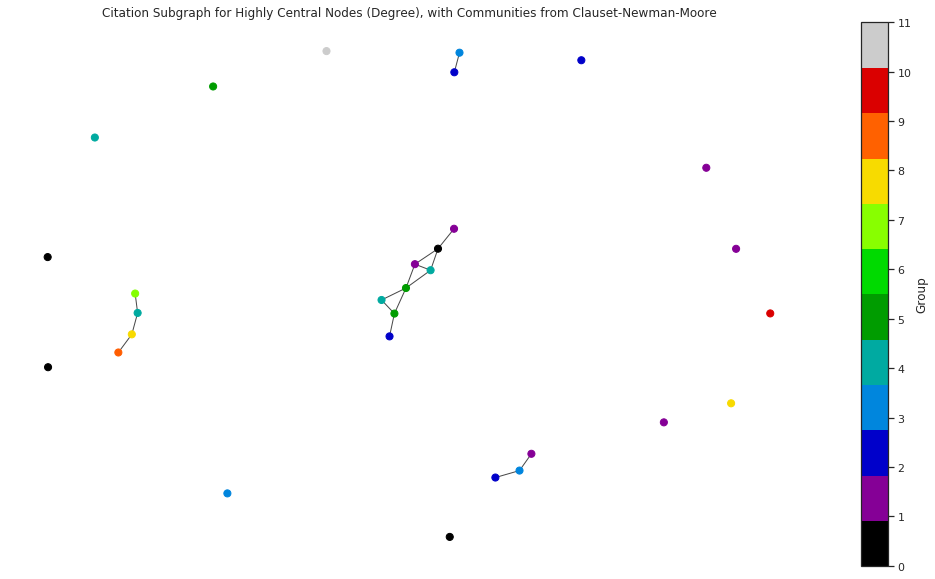

In [0]:
# Plot subgraph for highest ranked nodes according to degree measurement
# Plot citation graph with communities from Clauset-Newman-Moore coloured.
plot_network(
    subgraph_top30_deg,
    'Citation Subgraph for Highly Central Nodes (Degree), with Communities from Clauset-Newman-Moore',
    node_colors = comms_top30_deg,
    edge_transparency = 0.8,
    node_transparency = 1,
    node_size = 50,
    cmap = 'nipy_spectral',
    pos = nx.kamada_kawai_layout
)

The above diagram shows the 30 most central nodes according to degree, with communities coloured. We can see the highly central nodes contained in the centre, with Node 1245 in commmunity 0 in the centre connected to three other nodes, two of which from community 1 and one from community 4. All these central nodes belong to both ranked lists.

## Task 1.4: Compare feature and graph clusterings

In Parts 1.1 and 1.3, we obtained to different clusterings of the documents - the first was clustered according to the k-means algorithm applied to the features of the papers, and the second clustered according to community detection on the citation graph. These are two different considerations for grouping papers together, so now we need to see if this produced similar groupings.

Due to the different parameters that are being examined to determine the communities, we don't expect to find the exact same clusters. However, in context, it might make sense to see groupings that aren't entirely different. Papers that have similar text content are more likely to be closely related, and may be more likely to cite each other due to the similarities in the topics they discuss - this would imply that similar groupings might be produced when considering either the content or the citations.

However, papers that are similar in content may not necessarily be more likely to cite eachother. For example, papers that are highly central - or very frequently cited - may cover more fundamental or basic concepts in text that that of papers that are not as highly central. So, it's possible that two papers connected by a citation may not be connected by the actual content they discuss - this could lead to the two papers being in the same community when considering citations, but in different clusters when considering the feature matrix.

### Adjusted Mutual Information Score and Adjusted Rand Index

In order to examine the similarity in our two optimal clusterings, determined from the feature matrix in Part 1.1 and the communities in Part 1.3, we use two scores: Adjusted Mutual Information Score (AMI Score) and Adjusted Rand Index (ARI).

The Mutual Information (MI) determines the similarity between two labellings of the same dataset - in this context, it will measure how similar the two cluster labels are for the same citation network.

Adjusted Mutual Information (AMI) slightly changes MI so that luck is taken into account. For clustering, it takes into account the fact that MI will be higher for two clusterings that have a higher number of groups, whether or not more information is actually shared between the two.

Adjusted Rand Index (ARI) also measures the similarities between two labellings, and it also takes normalisation into account to reduce the effect of chance.

In general, ARI is slightly better for when the ground truth clustering has clusters of fairly equal size that are large, and AMI is preferable for when the clustering is unbalanced with the presence of small clusters.

In [0]:
# Get the clusterings for both methods in 1.1 and 1.3
clusterings_feature = list(kmeans_optimal.labels_)
clusterings_graph = c_by_node

In [0]:
# Calculate adjusted mutual information score and adjusted rand index
ami_score = adjusted_mutual_info_score(clusterings_feature, clusterings_graph, average_method = 'arithmetic')
ari_score = adjusted_rand_score(clusterings_feature, clusterings_graph)

In [0]:
# Print scores
print('Adjusted Mutual Information Score: %.3f' %(ami_score))
print('Adjusted Rand Index: %.3f' %(ari_score))

Adjusted Mutual Information Score: 0.149
Adjusted Rand Index: 0.067


For both, a score of 0 indicates completely different cluster splits, or if the labelling is incomplete, and a score of 1 indicates perfect agreement.

The AMI score is higher than the ARI, which is expected due to the fact that both clusterings have small clusters, with unbalanced cluster sizes. Compared to the ARI, the AMI seems to indicate some agreement in the labelling of clusterings.

However, both scores are close to 0, showing that the two different methods do produce largely different communities. This may be due to what we discussed previously - just because two papers cite each other, this might not necessarily mean they have the same written content.

### Visual Comparison

In order to see how the different grouping methods produce different relationships for the citation graph, see below the clustering from the feature matrix on the graph we generated in Task 1.2.

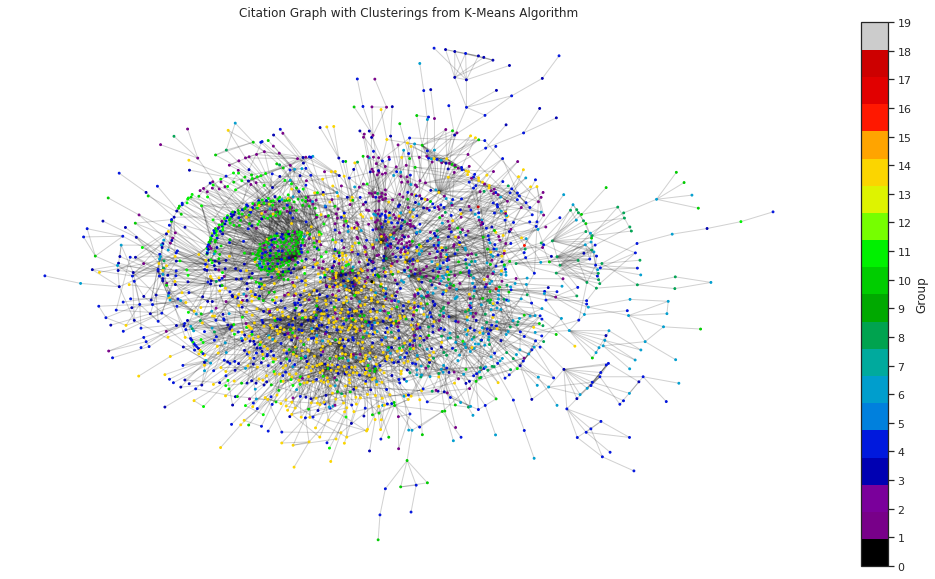

In [0]:
# Plot citation graph with clusterings from 1.1
plot_network(
    A,
    'Citation Graph with Clusterings from K-Means Algorithm',
    node_colors = clusterings_feature,
    edge_transparency = 0.2,
    node_transparency = 1,
    node_size = 3.5,
    cmap = 'nipy_spectral'
    )

For comparison, we plot the citation graph with communities coloured that we generated in Task 1.3 again below.

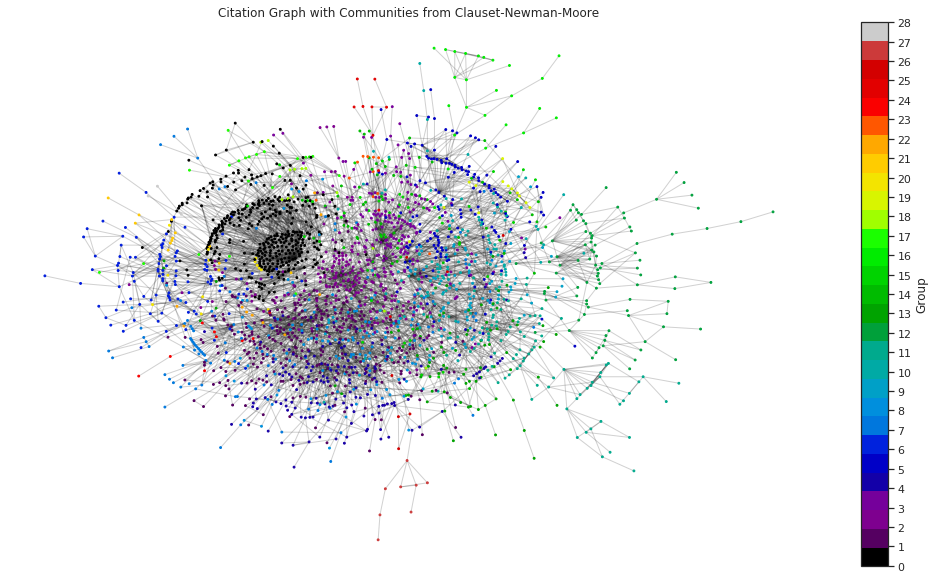

In [0]:
# Redisplay citation graph with communities from Clauset-Newman-Moore
plot_citation_graph_cnm()

The key difference we can see from the above visualisation is that the large community of nodes coloured black in the Clauset-Newman-Moore coloured citation graph isn't present in the clusterings graph. Remember that the most highly central node belongs to this community.

Building upon what we discussed previously, this may be **evidence for the fact that the most central node represents a fundamental or foundational paper that provides the ground work for a lot of other papers, but that those papers go off in a wide variety of directions thematically** which leads to differences in their content. This is backed up by the variation in clusterings that the nodes belong to in the portion of the graph where the nodes belong to the same Clauset-Newman-Moore community.

There are some similarities. For example in the north-north-east out portion of the graph, there are ~30 nodes that all belong to the same cluster who also belong to the same Clauset-Newman-Moore determined community. This may represent an area of research where there is no one paper that provides foundation, but rather there is a **group of papers that all rely on each other and cite each other in order to carry out similar work**, or to verify each-other's work.

### Further Comparison

Below, we plot the citation graph for the largest clusterings determined by our 'optimal' k-means clustering.

In [0]:
# Get a list of all nodes in all clusters as determined by the optimal k-means clustering
clusters_kmeans = []
for cluster_index in range(k_optimal):
    new_cluster = []
    for node in range(len(clusterings_feature)):
        if clusterings_feature[node] == cluster_index:
            new_cluster.append(node)
    clusters_kmeans.append(new_cluster)

In [0]:
# Get a list of subgraphs for each cluster 
subgraphs_clusters = []
for cluster_index in range(k_optimal):
    subgraphs_clusters.append(A.subgraph(clusters_kmeans[cluster_index]))

In [0]:
# Function for plotting a cluster as found by k-means algorithm
def plot_cluster(cluster):
    plot_network(
        subgraphs_clusters[cluster],
        'Limited Citation Graph, Cluster %.d' %(cluster),
        node_colors = [cluster]*len(clusters_kmeans[cluster]),
        edge_transparency = 0.2,
        node_transparency = 1,
        node_size = 3.5
        )

In Task 1.1 we determined that Cluster 14 was the largest cluster, so we'll visualise the citation graph but only for nodes in this cluster, using the same layout as we've used for the whole citation graph but zoomed in.

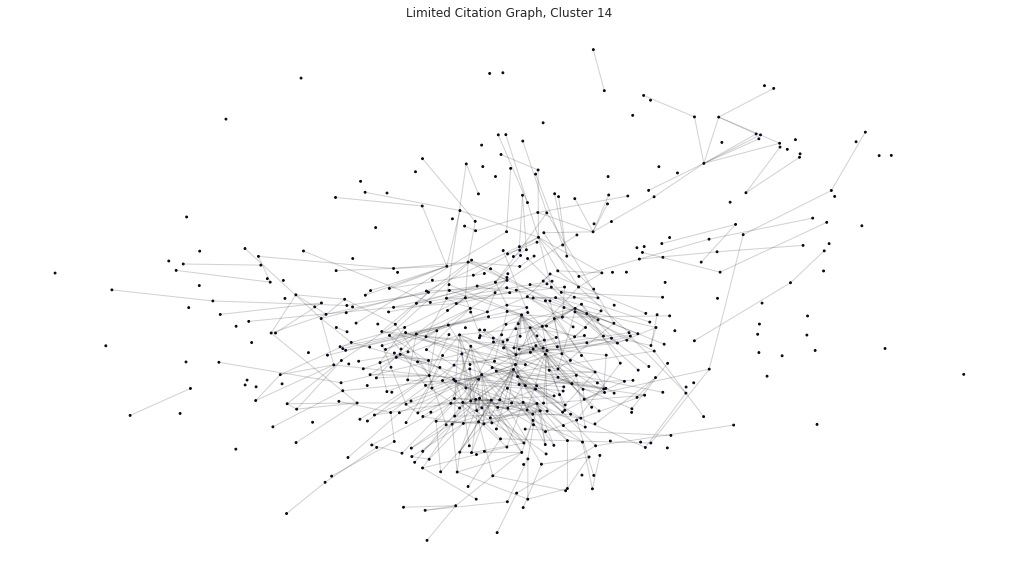

In [0]:
# Plot largest cluster
plot_cluster(14)

In [0]:
# Get a list of subgraphs for each community
subgraphs_comms = []
for c_index in range(len(c_arr)):
    subgraphs_comms.append(A.subgraph(list(c_arr[c_index])))

In [0]:
# Function for plotting communities
def plot_community(c):
    plot_network(
        subgraphs_comms[c],
        'Limited Citation Graph, Community %.d' %(c),
        node_colors = [c]*len(subgraphs_comms[c]),
        edge_transparency = 0.2,
        node_transparency = 1,
        node_size = 3.5
        )

In Task 1.3, we determined that the largest community was Community 0.

In [0]:
# Plot largest community
plot_community(0)

The above plots show a key difference in the largest cluster and the largest community. The largest community, which was initially clearly visible from the coloured citation graph, appears to have much more structure. We can clearly see the most central node to which all the other nodes have a connection.

The largest cluster as determined by the k-means algorithm, cluster 14, has less structure when viewed through the citation graph. There are many nodes that have a degree of 0, in other words there are papers within this cluster that don't cite any other papers. In there are no obvious important or central nodes.

This analysis clearly displays the difference between the two grouping methods.

# Task 2: Classification of a set of images

This task focuses on applying supervised learning to a dataset of images of fashion items sold by Zalando. We have 70,000 samples which consist of 28*28 pixels coloured in greyscale with values from 0 to 1.

This data is analysed in two ways. First we analyse the images in an unsupervised manner to evaluate how seperated the classes (i.e. the articles of clothing) are using techniques from Task 1.1. Secondly we use supervised learning of the ground truth labels, training neural networks for classification of the images.

#### Preparation of Data

As usual, we pre-process the dataset to a standard 0-1 scale just in case - this has been applied just in case, and to make this process more repeatable for other datasets in case they aren't already standardised. Below I repeat my justification for this that's in the introduction of my submission for Coursework 1:

"In data science methods and data mining approaches, such as artificial neural networks, inputs of the **data set need to be normalized to avoid ill-conditioning**. This is done to achieve the same range of values for each of the inputs to the model we choose to use, which makes having **stable convergence of weights and biases** more likely."

In [0]:
# Standardize the data by scaling the descriptors (i.e. the pixels) to a continuous 0-1 scale.

# Define the scaler
scaler = MinMaxScaler(feature_range = (0, 1))

# Apply the scaler to the test and train data
descriptors_train = scaler.fit_transform(train.drop('label', 1))
descriptors_test = scaler.fit_transform(test.drop('label', 1))

# Convert the target variables into arrays for easier use in the following classification tasks
target_train = np.array(train[['label']]).ravel()
target_test = np.array(test[['label']]).ravel()

# Convert target data to the correct data type
target_train = target_train.astype(int)
target_test = target_test.astype(int)

This is a known data set which has 6000 of each clothing item in the training set and 1000 of each item in the testing set, and so this is a perfectly balanced data set - no further processing such as boot-strapping is required.

## Task 2.1: Unsupervised clustering of the image dataset

In this task, we follow a similar approach to the one in Task 1.1. The K-Means algorithm is used in an unsupervised manner without ground truth labels to cluster the dataset into k different classes, where we vary k between 2 and 30.

The goal of this section is to attempt to determine how well seperated the ground truth labels are in the dataset.

### Computing K-Means Models

The sheer size of the dataset doesn't permit us to use the standard KMeans clustering algorithm with a sufficiently high number of initial states. This means that we have to have a very low number of initial guesses for centroid positions, making our model much more reliant on chance and less reliable.

To counteract this and to deal with the inherent randomness of the data, we need to have a high number of initial guesses for centroids. In order to make this computationally doable, we'll use mini-batch K Means clustering, a slight alteration of K Means that runs much faster and that produces almost identical results.

Below, I store the K-Means models in a list so that I can more efficiently calculate CH scores and DB scores later on.

In [0]:
%%time
# Get kmeans models for the specified number of clusters
inertias_2 = []
models_2 = []

for k in k_values:
    # Get the model
    model = MiniBatchKMeans(k, random_state = seed, n_init = 50).fit(descriptors_train)

    # Append the new values.
    models_2.append(model)
    inertias_2.append(model.inertia_)

CPU times: user 1min 23s, sys: 44.7 s, total: 2min 7s
Wall time: 1min 6s


### Evaluating the Clustering of the Images into 10 Classes

In this section we look at different ways to evaluate how well clustered the dataset is into the 10 ground truth labels.

#### Inertia

As in Task 2.1, we plot the inertia against number of clusters to deduce how costly each value of k is with regards to sums of squares of distances to cluster centres.

In [0]:
# Plot inertia
plot_scores(
    k_values,
    [inertias_2],
    labels = ['Inertia'],
    title = 'Elbow Curve\n(Variation of Inertia against Number of Clusters)',
    colours = ['purple']
    )

The above curve shows some slight deviations to the smooth descent, with a sharp rise at k=19 and k=29.

With a mainly smooth curve, we see no significant elbow or indication that there is a point at which additional clusters lead to less improvement. However, there is some change in behaviour at k=12 with a slightly faster decrease in inertia, and there is some indication for k=18 producing the optimal number of clusters due to the sharp increase in inertia afterwards.

There is no evidence for the dataset being well seperated into the 10 classes according to this plot.

#### Internal Clustering Scores

In this section I will examine how the scoring varies for number of clusters for the two indexes that produced meaningful results in Task 1.1: CH and DB. First we get the predicted labels from the K-Means models, then using the labels we evaluate the scores across k=2 to k=30.

In [0]:
# Initialise labels list
labels_list = []

# Get labels for each model
for model in models_2:
    labels_list.append(model.labels_)

In [0]:
# Function for getting scoring from labels
def get_scores_from_labels(X = descriptors_train, labels_list = labels_list, scoring_fct = calinski_harabasz_score):

  	# Initialisation
    scores = []

    # Get score for each set of model and labels
    for labels in labels_list:
        # Get score
        score = scoring_fct(X, labels)
        
        # Append score
        scores.append(score)
    return scores

In [0]:
%%time
# Get CH scores for models
ch_scores_2 = get_scores_from_labels()

Wall time: 57.3 s


In [0]:
%%time
# Get Davies-Bouldin scores for models
db_scores_2 = get_scores_from_labels(scoring_fct = davies_bouldin_score)

Wall time: 37.5 s


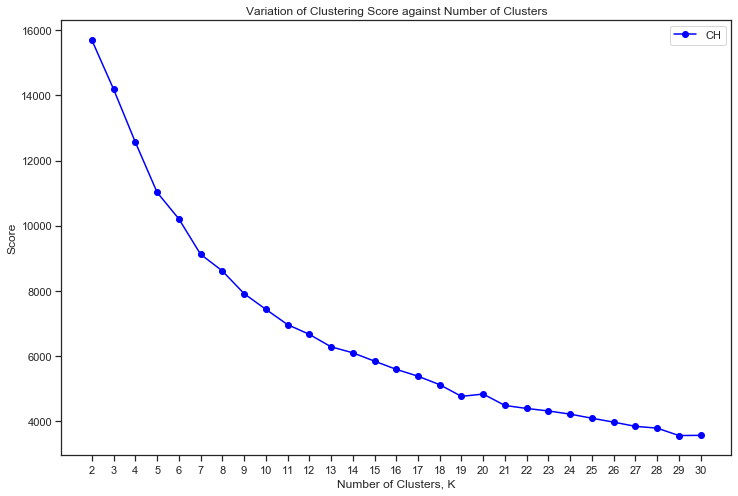

In [0]:
# Plot scores
plot_scores(
    k_values,
    [ch_scores_2],
    labels = ['CH'],
    title = 'Variation of Clustering Score against Number of Clusters',
    )

There is no evidence for the dataset being well seperated into the 10 classes according to this plot. The only significant change in behaviour occurs at k=20.



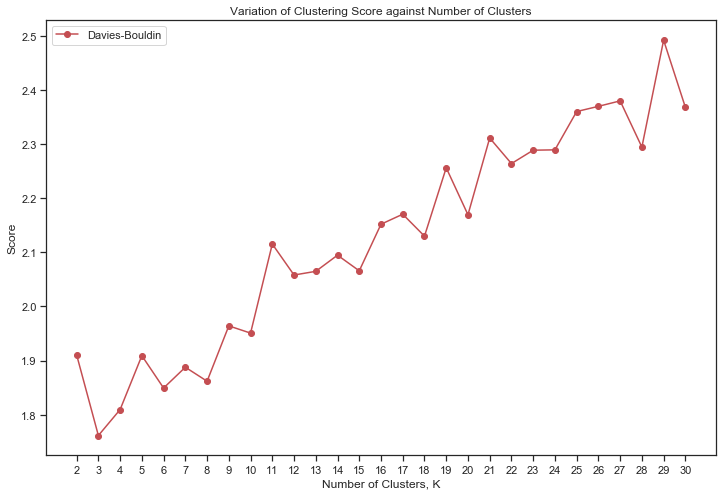

In [0]:
# Plot scores
plot_scores(
    k_values,
    [db_scores_2],
    labels = ['Davies-Bouldin'],
    title = 'Variation of Clustering Score against Number of Clusters',
    colours = 'red'
    )

There is no evidence for the dataset being well seperated into the 10 classes according to this plot, and DB seems to be less useful for this dataset as there is an upwards trend in score with erratic changes.

The only indication that 10 may be the optimal number of clusters for the dataset is the sharp increase in DB score at k=11.

#### Distances to Centroids

In this section we manually observe how the average internal and external centroid distances vary as k changes.



In [0]:
%%time
# Get average distances to own and other centroids for range of number of clusters
dst_ctr_km_in, dst_ctr_km_out = get_avg_dsts_in_out_range(descriptors_train, k_values, mini_batch = True)

k = 2 complete
k = 3 complete
k = 4 complete
k = 5 complete
k = 6 complete
k = 7 complete
k = 8 complete
k = 9 complete
k = 10 complete
k = 11 complete
k = 12 complete
k = 13 complete
k = 14 complete
k = 15 complete
k = 16 complete
k = 17 complete
k = 18 complete
k = 19 complete
k = 20 complete
k = 21 complete
k = 22 complete
k = 23 complete
k = 24 complete
k = 25 complete
k = 26 complete
k = 27 complete
k = 28 complete
k = 29 complete
k = 30 complete
CPU times: user 2min 10s, sys: 1min 4s, total: 3min 15s
Wall time: 1min 42s


In [0]:
# Plot average distances
plot_scores(
    k_values,
    [dst_ctr_km_in, dst_ctr_km_out],
    ['Average Distance to Own Centroid', 'Average Distance to Other Centroids'],
    title = 'Average Distances to Centroids',
    ylabel = 'Distance (Euclidean)',
    colours = ['olive', 'orange']
    )

Again, there is no evidence for the dataset being well seperated into the 10 classes according to this plot.

Interestingly, the average distance from data points to external centroids stays relatively stable with only a slight increase, indicating that number of clusters has no little effect on the well-separatedness of clusters.

The average distance from data points to their own centroid however does decrease, with increasing the number of clusters from 2 to 6 clearly resulting in denser clusters, with a slower increase in density until k=16.

Therefore, this plot shows that there is no real difference in the clustering for all k values from 16 to 30.

#### Summary

There is no strong evidence that the dataset is seperated into the 10 classes, with some evidence that there are 12 to 16 clusters as determined by the KMeans algorithm. This was particularly demonstrated by examining the inertia and the distances to centroids.

### Visualising the Centroids

Given that we actually do have 10 distinct classes that we want to seperate the dataset into, we define a KMeans clustering model using k=10.

Then, we visualise the centroids that this model produces. We expect that the centroids align with the 10 classes, meaning that each centroid will be the average article of clothing in each fashion item.

In [0]:
%%time
# Get the fitted model for 10 clusters.
km_10 = MiniBatchKMeans(10, random_state = seed, n_init = 50).fit(descriptors_train)

CPU times: user 1.9 s, sys: 950 ms, total: 2.85 s
Wall time: 1.55 s


In [0]:
# Centroids from kmeans clustering
centroids_km = km_10.cluster_centers_

# Reshape for visualisation
centroids_km_plotting = [centroid.reshape(28, 28) for centroid in centroids_km]

In [0]:
# Function for plotting components
def plot_components(components = centroids_km_plotting, title = '', component_name = '', remove_cb = True, cmap = 'gray_r', vmin = None, vmax = None):
    fig, axes = plt.subplots(2, 5)
    fig.set_size_inches(23, 8)
    coordinates = [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4)]
    for i in range(len(coordinates)):
        # Get ax
        ax = axes[coordinates[i]]

        # Plot component
        sns.heatmap(components[i], cmap = cmap, ax = ax, vmin = vmin, vmax = vmax)

        if remove_cb:
            # Remove colour bar
            cb = ax.collections[-1].colorbar   
            cb.remove()

        ax.title.set_text(component_name + ' ' + str(i))

    # remove the x and y ticks
    plt.setp(axes, xticks=[], yticks=[])

    # Labelling
    plt.suptitle(title, y = 0.95)
    plt.show()

Finally we can plot the 10 centroids. For clarity, axes and colourbars have been removed.

In [0]:
# Plot components
plot_components(centroids_km_plotting, 'Centroids from K-Means Clustering', 'Centroid')

As expected, we see that most of the clusters clearly correspond to a distinct article of clothing. For example, Cluster 6 contains datapoints corresponding to trousers.

However, as expected, the clustering does not produce perfect results. It is unclear which of Clusters 5 and 9 contain sandals and ankle boots. Similarly, from inspection, tops, coats and pullovers could be in any of Clusters 1, 2, 8 and 4. Cluster 3 is also unclear.

### Distances to Centroids

We more closely examine the quality of the model by looking at the distances of average images of each cluster to their centroids and to other centroids.

In [0]:
# Get average distances to centroids
dsts_10_avg_df = get_avg_dsts_df(10, descriptors_train, mini_batch = True)

# Plot average distances
plot_avg_dsts_heatmap(dsts_10_avg_df, 'Distances of Average Image of Each Cluster to Centroids', vmin = 0, vmax = 15)

This plot clarifies how the clusters are seperated.

We see that the average data point in Cluster 4 has a particularly low distance to its own centroid compared to others - Centroid 4 is the pullover. This means that pullovers are likely to be well defined in this model. Images classed as pullovers are also particularly far away from Centroid 3, indicating that these two classes are very well seperated.

Clusters 2 and 3 are close together, indicated by their distances to Centroids 2 and 3 compared to distances to all other Centroids. These are likely shirts and tops judging by the visualisation.

### Using the K-Means Clustering as a K-Nearest Neighbours Classifier

K-Nearest Neighbours (KNN) is a machine learning technique used for both classification and regression.

Given a value of k and a labeled dataset, KNN assigns new labels to points in the dataset. It does this in the following way:
* For each point X in the dataset, calculate the k points that are closest to X by some metric.
* Call the k points closest to X the neighbourhood of X.
* Assign X the label that occurs the most often out of the labels in the neighbourhood.

KNN is a very simple algorithm, and we apply it now to the labels predicted by the K-Means algorithm in the previous section for 10 clusters.

#### Reorganising Labels

First, we need to check that the labels determined in the k-means model align with our ground truths, as the model is unaware of the ground truths due to our unsupervised approach.

Below we have the ground truth labels indexed in order.

In [0]:
# Use the model to get labels from the training data
y_pred_km = km_10.predict(descriptors_train)

In [0]:
# Target names from the ground truths, in order
target_names = [
                'Top',
                'Trousers',
                'Pullover',
                'Dress',
                'Coat',
                'Sandal',
                'Shirt',
                'Sneaker',
                'Bag',
                'Ankle Boots'
                ]

For example, the Cluster 6 clearly contains data points labeled as Trousers, judging by the visualisation of the centroids above. However, the target label for Trousers is indexed by 1 in our original dataset.

Therefore we define a function that can swap labels based on these indexes.



In [0]:
# The label indices, in the order given by the ground truths
target_names_idx_gt = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Takes in predicted target variables, the new labelling, and returns the predicted target variables with the new labelling
def swap_labels(y_pred, lbls_new, lbls_old = target_names_idx_gt, target_names = target_names):

    # Actual target names, in order given by the centroids in the diagram above
    target_names_txt = []
    for i in lbls_new:
        target_names_txt.append(target_names[i])

    # Set up a dataframe for predicted values
    df = pd.DataFrame(y_pred)

    # Change indexes into text labels
    for i in lbls_old:
        df = df.replace(to_replace = i, value = target_names_txt[i])

    # Now change the text labels into the new indexes
    for i in range(len(target_names_txt)):
        df = df.replace(to_replace = target_names_txt[i], value = lbls_new[i])

    # Return the dataframe into an array
    y_pred_new = np.asarray([i[0] for i in np.asarray(df)])

    return y_pred_new

Now that we can re-index the predicted labels we take a methodical approach.

We optimise the confusion matrix produced by the training data by maximising its trace. Simply, this ensures that the columns of the confusion matrix are sorted properly, ensuring we have as high a possible value on the diagonal to maximise recall.

This will give us the best reindexing as it will maximise accuracy on the training data. Then we'll use this relabelling on the testing data. This preserves 1-1 relabelling.

In [0]:
# Compute optimal labels by optimising the confusion matrix on the training data
def compute_optimal_labels(y_true, y_pred):

      # Get a fresh confusion matrix from unchanged labellings
      cm = confusion_matrix(y_true = y_true, y_pred = y_pred)

      # Calculate the optimal relabelling that maximises the trace of the confusion matrix
      _, labels_new = linear_sum_assignment(-cm.T)

      return labels_new

In [0]:
target_names_idx_km = compute_optimal_labels(target_train, y_pred_km)

In [0]:
print('New indexing for labels:', target_names_idx_km)

New indexing for labels: [8 0 3 5 4 6 1 7 2 9]


Now we can get a new labelling for the predicted labels of the training data.

In [0]:
# Swap labels
y_pred_km_n = swap_labels(y_pred = y_pred_km, lbls_new = target_names_idx_km)

#### Setting up a KNN Classifier

Now we need to use the properly indexed K-Means clustering labels obtained in a KNN classifier.

First we fit the KNN classifier to the training data and the labels given by the clustering algorithm.

In [0]:
%%time
# Fit kNN model
knn = KNeighborsClassifier(n_jobs = -1).fit(descriptors_train, y_pred_km_n)

Wall time: 33.2 s


Now, we get new labels based on the KNN algorithm set to default settings at k=5 neighbours.

*Note: The cell below takes prohibitively long to run in Google Colab with 2 cores. This cell was ran locally using Jupyter Notebooks using 8 cores.*

In [0]:
%%time
# Get predictions from kNN
y_pred_knn = knn.predict(descriptors_test)

Wall time: 4min 22s


#### Evaluating the Classifier

Now that we have predicted labels from the KNN classifier for the test set, we can use the ground truth labels for the test set to report acccuracy and other quality measures of its performance.

In [0]:
# Get classification report and confusion matrix
class_report_knn = classification_report(y_true = target_test, y_pred = y_pred_knn, target_names = target_names)
conf_matrix_knn = confusion_matrix(y_true = target_test, y_pred = y_pred_knn)

In [0]:
# Print classification report
print('-- Classification Report: K-Means Clustering as a kNN Classifier --')
print(class_report_knn)

-- Classification Report: K-Means Clustering as a kNN Classifier --
              precision    recall  f1-score   support

         Top       0.51      0.59      0.55      1000
    Trousers       0.55      0.82      0.66      1000
    Pullover       0.25      0.27      0.26      1000
       Dress       0.27      0.25      0.26      1000
        Coat       0.38      0.61      0.47      1000
      Sandal       0.66      0.75      0.70      1000
       Shirt       0.00      0.00      0.00      1000
     Sneaker       0.73      0.75      0.74      1000
         Bag       0.95      0.48      0.64      1000
 Ankle Boots       0.77      0.52      0.62      1000

    accuracy                           0.50     10000
   macro avg       0.51      0.50      0.49     10000
weighted avg       0.51      0.50      0.49     10000



In [0]:
# General function for a confusion matrix heatmap
def conf_matrix_heatmap(conf_matrix, title, target_names = None):
    plt.figure(figsize = (20, 8))
    plt.title(title)
    if target_names != None:
        sns.heatmap(conf_matrix, annot = True, cmap = 'GnBu_r', xticklabels = target_names, yticklabels = target_names, fmt = 'd')

    else:
        sns.heatmap(conf_matrix, annot = True, cmap = 'GnBu_r', fmt = 'd')

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

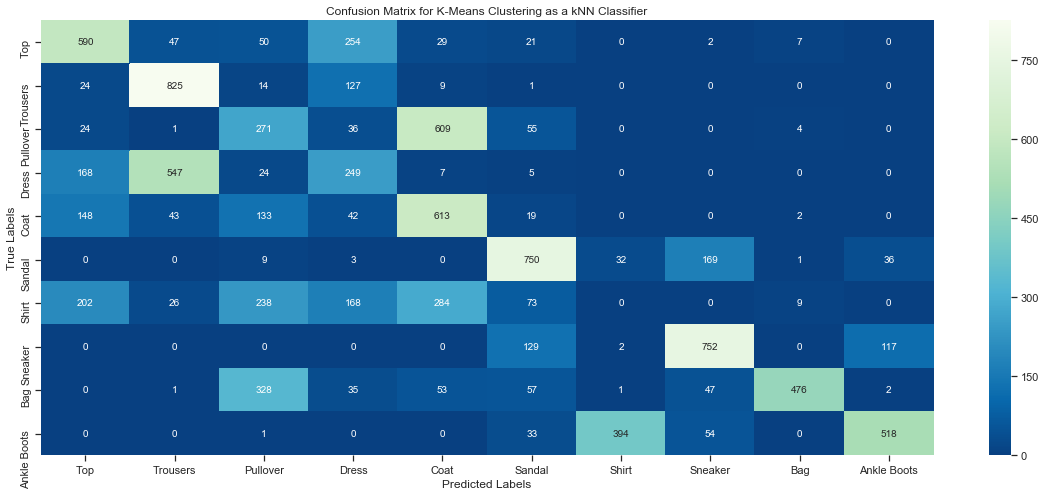

In [0]:
# Plot confusion matrix
conf_matrix_heatmap(conf_matrix_knn, 'Confusion Matrix for K-Means Clustering as a kNN Classifier', target_names = target_names)

Overall, the **KNN classifier performs relatively poorly in classifying the entire data set**. With an accuracy of 0.50, given an image the classifier will predict the correct label half of the time.

However for specific classes, the KNN classifier is very accurate at classifying. In particular, the **classifier is very accurate predicting sneakers and sandals** with accuracy scores of over 0.70, and to a lesser extent the classifier is accurate in predicting trousers, bags and boots with accuracy scores between 0.62 and 0.66. This is reflected in the confusion matrix with bright colours on the diagonal for these classes.

However, **the accuracy score for sandals is being dragged down by the precision**, as a considerable number of sneakers, shirts and pullovers getting the label of sandal. This is true to a lesser extent for sneakers with a lot of sandals being labeled as sneakers. This is intuitive, as sandals and sneakers share a lot of features and so clusters corresponding to these classes will be situated close together.

To further analyse the performance in the KNN classifier, it's important to note classes that have significantly different precision and recall scores.

For example, even though bags have a high accuracy score of 0.64, this is entirely reliant on its precision of over 0.90 as its recall is 0.48. **The classifier will practically never label images as bags if their true label isn't a bag, but it still can't pick out a large amount of the true bags in the dataset**. In particular, 328 bags are given the label of pullover compared to 476 being correctly labeled. This indicates the cluster given the label bag, which from the centroid visualisation appears to be Cluster 0, is very dense but with many bags being outside the cluster closer to other centroids.

Upon observing the dataset with ground truth labels, bags often don't have a clear handle and so take on a much more uniform rectangular shape, meaning that these are likely being grouped together with pullovers away from the bags with handles as visualised by Centroid 0.

The **classifier gives an accuracy score of 0 for classifying shirts**, showing that the above process has completely failed for this class. The confusion matrix reveals this is because **almost all 'Shirt' labellings are actually going to bags**, with true shirts never being labelled as shirt. If we consider the centroids, it is clear that the process never captured a seperated shirt clustering, with shirts actually being contained in the other clusterings. This indicates that there may a limit to using KMeans and KNN to classify this dataset due to how the inherent characteristics of images of shirts compared to the other fashion items, as getting an accuracy of 0 given that we've accounted for randomness sufficiently is unusual.

The class 'Pullover' also performs very poorly with an F1 score of 0.26. This is because **the majority of pullovers are being labeled as coats**, which is why the precision score for 'Coat' is relatively low despite a high recall.



#### Improving the Classifier

Due to how the clustering algorithm worked, one of the predicted labels is being used for the wrong class - the column predicted label 'Shirt' is going to ankle boots.

This is because when we swapped labels, we assumed a 1-1 relabelling where exactly one cluster corresponds to exactly one predicted label. If instead we don't assume 1-1 relabelling, and give all images in two different clusters the same ground truth label, then we will increase the accuracy of the model.

More concretely, instead of labelling data points closest to the centroid 5 as 'Shirt', we label them as 'Ankle Boot'. Therefore, we have two different centroids that will assign points to the label 'Ankle Boot', and none to the label 'Shirt. This may seem arbitrary, but using intuition from our previous results this should increase the accuracy of the classifier. The classifier becomes less useful depending on it's use case, however, and we lose a lot of information distinguishing shirts from other classes.

To further improve the classifier, we would vary the number of neighbours k in the KNN algorithm to see if accuracy increases. However, the requirements for tuning this parameter are computationally prohibitive which is why we use the default value.

In [0]:
# Manually change the ground truth label that one of the clusters belongs to
target_names_idx_km2 = target_names_idx_km
target_names_idx_km2[5] = 9

In [0]:
# Swap labels
y_pred_km_n2 = swap_labels(y_pred = y_pred_km, lbls_new = target_names_idx_km2)

In [0]:
%%time
# Fit kNN model
knn2 = KNeighborsClassifier(n_jobs = -1).fit(descriptors_train, y_pred_km_n2)

Wall time: 32.9 s


In [0]:
%%time
# Get predictions from kNN
y_pred_knn2 = knn2.predict(descriptors_test)

Wall time: 4min 27s


In [0]:
# Get classification report and confusion matrix
class_report_knn2 = classification_report(y_true = target_test, y_pred = y_pred_knn2, target_names = target_names)
conf_matrix_knn2 = confusion_matrix(y_true = target_test, y_pred = y_pred_knn2)

C:\Users\Peter\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
# Print classification report
print('-- Classification Report: K-Means Clustering as a kNN Classifier --')
print(class_report_knn2)

-- Classification Report: K-Means Clustering as a kNN Classifier --
              precision    recall  f1-score   support

         Top       0.51      0.59      0.55      1000
    Trousers       0.55      0.82      0.66      1000
    Pullover       0.25      0.27      0.26      1000
       Dress       0.27      0.25      0.26      1000
        Coat       0.38      0.61      0.47      1000
      Sandal       0.66      0.75      0.70      1000
       Shirt       0.00      0.00      0.00      1000
     Sneaker       0.73      0.75      0.74      1000
         Bag       0.95      0.48      0.64      1000
 Ankle Boots       0.83      0.92      0.87      1000

    accuracy                           0.54     10000
   macro avg       0.51      0.54      0.51     10000
weighted avg       0.51      0.54      0.51     10000



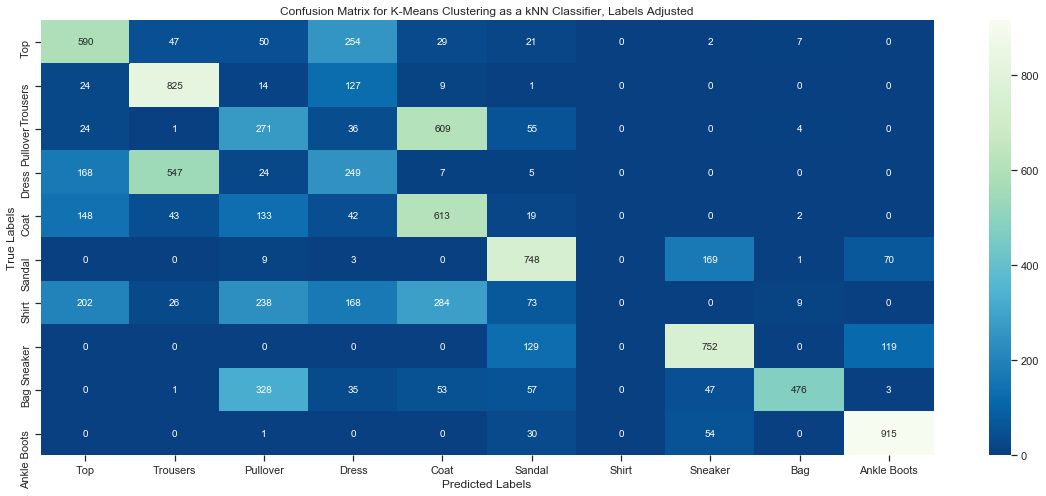

In [0]:
# Plot confusion matrix
conf_matrix_heatmap(conf_matrix_knn2, 'Confusion Matrix for K-Means Clustering as a kNN Classifier, Labels Adjusted', target_names = target_names)

The overall accuracy of the classifier has increased from 0.50 to 0.54, a significant improvement. This is entirely due to the fact that now no images are being given the label 'Shirt', as all images previously labeled as 'Shirt' have been reassigned to the label 'Ankle Boot'. This is shown in the confusion matrix by how the column for ankle boots is now the sum of the two columns in the previous confusion matrix with the column for shirt being set to 0.

This has **greatly increased the recall of ankle boots, going from 0.52 to 0.92**.

## Task 2.2: Supervised classification of the training set

In this task, we carry out two different methods for supervised classification of a set of images of fashion items: multi-layer perceptron neural networks and convolutional neural networks.

We build these models, train them, observe their accuracies on out-of-sample data, and compare them to the k-NN classifier in Task 2.1. Finally, we use 5-fold cross validation to improve the CNN.

### Task 2.2.1: MLP neural network supervised classification

Note that this task requires similar functions that I wrote and submitted for Methods for Data Science Coursework 2, Task 3. I have readapted the relevant work from there in this Task, including both code and explanations.

Neural Networks are designed to recognise patterns, and make predictions based on a number of algorithms and linear algebra. Neural Networks predict mainly using a method called **backpropagation**, which is basically a mechanism through which the network learns about errors that it's making when making predictions. When a network is first created it has no knowledge and so makes guesses randomly, but then these guesses become more finely tuned as the network is trained on data.

When a data instance is passed through the network, or propagated forward, a prediction is made, and then the error can be measured and passed backwards. The network then uses this error to reset its weights and parameters, in the direction of where there is less error using gradient descent.

We then train our network over a series of epochs to increase the likelihood of an unseen bit of data getting assigned to the correct classification.

In context, the network we build here will be used to make predictions on a dataset of images of fashion items, referred to as Fashion-MNIST. In particular, the network we train has the goal of predicting the fashion item in an image it is given.

The data that we pass into the model will therefore be 28x28 pixels, which we represent as one single vector of length 28*28. Each image belongs to one of ten classes.

In [0]:
# Initialise variables - these are fixed by the data set
input_size = descriptors_train[0].size
num_classes = 10

# Initialise variables - these determine the MLP classifier
batch_size = 128
learning_rate = 0.005
hidden_size = 100
num_epochs = 30

#### Hyperparameters for the Neural Network

Before starting, let's consider the hyperparameters of the neural network that we'll build.

`input_size`: # nodes per input layer of the neural network. In our case this will correspond to the number of pixels in each image.

`num_classes`: # of classes in the target variable. In our case this will be 10 as we have 10 different articles of clothing.

`hidden_size`: # neurons per hidden layer.

`num_epochs`: # epochs for training.

`batch_size`: # examples that network observes before updating weights. This controls the number of training samples that the model considers before changing weights.

`learning_rate`: backpropagation learning rate. This is the amount of change that the model makes during each step of the training process. For example, if the learning rate is 0.1, then weights are updated by 10% of the estimated weight error each time weights are updated.

We'll set up all these parameters below.

#### Preparation of the Data

Before continuing we need to prepare the data sets for the neural network.

We need to define a tensor data set and a loader for the data. The tensor data set turns the data into a tensor, and the data loader splits it up into batches. These batches then go into the neural network one at a time.

In [0]:
# Everything in PyTorch is done using tensors, which is why we convert them to this format here to then use tensors afterwards

def load_data(descriptors_input, target_input):
    # Convert the raw numpy data into a format that can be used by PyTorch
    descriptors = torch.from_numpy(descriptors_input).float()
    target = torch.from_numpy(target_input)
    return descriptors, target

def load_tensors(descriptors_input, target_input):
    # Convert to the tensor format
    data = torch.utils.data.TensorDataset(descriptors_input, target_input)
    return data

def load_data_and_tensors(descriptors_input, target_input):
    # Complete the complete loading of data process
    descriptors, target = load_data(descriptors_input, target_input)
    data = load_tensors(descriptors, target)
    return data

# Define a function for setting up the loaders for the data sets
def get_loaders(batch_size_input, train_input, test_input):
    train_loader = torch.utils.data.DataLoader(train_input, batch_size = batch_size_input)
    test_loader = torch.utils.data.DataLoader(test_input, batch_size = batch_size_input)
    return train_loader, test_loader

# A function specifically for converting arrays for descriptor and target data into a test loader.
# This provides a nice short cut for one of our testing functions later on.
def get_test_loader_from_arrays(batch_size, descriptors_test, target_test):
    test_data = load_data_and_tensors(descriptors_test, target_test)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size)
    return test_loader

#### Using the GPU

It can be advantageous to use the GPU when training the neural network, so here we define the device to be used in the training.

In [0]:
# Set up the device to be used in the neural network training
# If it's available, the GPU will be used
dev = 'cuda' if cuda.is_available() else 'cpu'

####Set up the Neural Network
Here we define a general class for a neural network. The network has 3 hidden layers each with 100 nodes, and output layer with 10 nodes corresponding to each of the 10 fashion items. ReLU is used for activation functions.

In [0]:
# Define the MLP neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()

        self.start = nn.Linear(input_size, hidden_size)
        self.middle = nn.Linear(hidden_size, hidden_size)
        self.end = nn.Linear(hidden_size, num_classes)

        self.to(dev)
    
    def forward(self, x):

        # Use ReLU as the activation function
        x = F.relu(self.start(x))

        x = F.relu(self.middle(x))  
        x = F.relu(self.middle(x))  

        x = self.end(x)

        x = F.softmax(x, dim = 1)

        return x

#### Criterion and Optimiser

For our model we need a loss function to estimate the performance of our classification model, and an optimisation method to use in the back-propagation.

Here we use negative log likelihood loss, and our optimisation is stochastic gradient descent which is an iterative method for finding the minimisation of the loss function.

Note that stochastic gradient descent can be noisy, but it's easy to compute.

In [0]:
# A function for defining a stochastic gradient descent optimiser
def optimiser_SGD(network, learning_rate):
    optimiser_SGD = torch.optim.SGD(network.parameters(), lr = learning_rate) 
    return optimiser_SGD

# Define the loss function, in this case negative log likelihood loss
loss_fct = nn.NLLLoss()

####Testing a Neural Network
We'll define a function which takes in a neural network and it's test loader, and it'll return the accuracy of the network.

Note that we're defining testing functions here first, and below we'll define a training function afterwards.

In [0]:
# Given a neural network and a test loader, compute the predicted values
def neural_network_predict(network, test_loader, conv_net = False):

    # Put the network into evaluation mode
    network.eval()

    # Initialize the prediction and label lists into tensors
    y_preds = torch.zeros(0, dtype = torch.long, device = dev)
    y_true = torch.zeros(0, dtype = torch.long, device = dev)

    for (x, y) in test_loader:
        # Use the GPU if it's available
        x = x.to(dev)
        y = y.to(dev)

        if conv_net:
                x = x.unsqueeze(0)
                x = x.transpose(0, 1)

        # Use the network to predict target variables
        y_pred = network(x)
        _, predicted = torch.max(y_pred.data, 1)

        # Add on results from batch prediction
        y_preds = torch.cat([y_preds, predicted.view(-1).to(dev)])
        y_true = torch.cat([y_true, y.view(-1).to(dev)])

    # y values into numpy format
    y_pred_output = y_preds.cpu().numpy()
    y_true_output = y_true.cpu().numpy()

    return y_pred_output, y_true_output

In [0]:
def neural_network_accuracy(network, test_loader, conv_net = False):
    y_pred, y_true = neural_network_predict(network, test_loader, conv_net)
    accuracy = accuracy_score(y_pred, y_true)
    return accuracy

####Training a General Neural Network¶
Below is a process for training a general neural network.

In [0]:
def neural_network_training(
        network,
        descriptors = descriptors_train,
        targets = target_train,
        epochs = num_epochs,
        learning_rate = learning_rate,
        batch_size = batch_size,
        criterion = loss_fct,
        optimiser_fct = optimiser_SGD,
        print_loss_values = True,
        print_intermediate_loss_values = False,
        print_iteration_interval = 1,
        split_and_test = False,
        conv_net = False,
        seed = seed
    ):

    # Set aside a portion of the data to use for in-sample testing
    if split_and_test:
        X_train, X_test, y_train, y_test = train_test_split(descriptors, targets, test_size = 0.2, random_state = seed)
    else:
        X_train = descriptors
        y_train = targets
        X_test = np.array([])
        y_test = np.array([])

    # Load our entire data set into the correct format
    train = load_data_and_tensors(X_train, y_train)
    test = load_data_and_tensors(X_test, y_test)

    # Set up initial loaders
    train_loader, test_loader = get_loaders(batch_size, train, test)

    # Optimiser
    optimiser = optimiser_fct(network, learning_rate)

    total_step = len(train_loader)
    num_elements = len(X_train)

    loss_values = []

    accuracies = []

    for epoch in range(epochs + 1):

        network.train()

        train_loss = 0

        for index, (x, y) in enumerate(train_loader):

            # Use the GPU if it's available
            x = x.to(dev)
            y = y.to(dev)

            if conv_net:
                x = x.unsqueeze(0)
                x = x.transpose(0, 1)

            # Forward pass
            y_pred = network(x)
            loss = criterion(y_pred, y)

            # Backward pass and optimisation
            optimiser.zero_grad()
            loss.backward()

            # Update weights
            optimiser.step()

            # Update the loss
            train_loss += (loss.item() * len(y)) / num_elements

            # Print out statistics within the epoch
            if index % print_iteration_interval == 0 and print_loss_values and print_intermediate_loss_values:
                print('Epoch [%.d / %.d] - Iteration [%.d / %.d] - Training Loss: %.3f'%(epoch, epochs, index, total_step, train_loss))

        if print_loss_values:
            # Print out the statistics for each epoch
            print('EPOCH COMPLETE - EPOCH [%.d / %.d] - TRAINING LOSS FOR EPOCH: %.3f'%(epoch, epochs, train_loss))

        # Add training loss to list of training losses
        loss_values.append(train_loss)

        # Calculate accuracy of the model after this epoch using the in-sample data set aside
        if split_and_test:
            # Evaluate the accuracy of the network at the end of this epoch
            accuracy = neural_network_accuracy(network, test_loader, conv_net)
            accuracies.append(accuracy)

    if print_loss_values:
        print('Training completed!')

    return loss_values, accuracies, network

#### Testing a Neural Network with Cross Validation¶
Now we implement a more advanced method for testing a neural network, which incorporates stratified k-fold cross validation.



In [0]:
def neural_network_accuracy_cv(
        initialised_network,
        cv,
        descriptors = descriptors_train,
        target = target_train,
        batch_size = batch_size,
        learning_rate = learning_rate,
        conv_net = False,
        optimiser_fct = optimiser_SGD,
        criterion = loss_fct
    ):
  
    # Keep a list for testing accuracy of each fold
    split_accuracies = []

    for training_index, testing_index in cv.split(descriptors, target):

        descriptors_train_split = descriptors[training_index]
        target_train_split = target[training_index]

        descriptors_test_split = descriptors[testing_index]
        target_test_split = target[testing_index]

        network = initialised_network

        _, _, trained_network = neural_network_training(
            network,
            descriptors = descriptors_train_split,
            targets = target_train_split,
            learning_rate = learning_rate,
            batch_size = batch_size,
            print_loss_values = False,
            split_and_test = False,
            conv_net = conv_net,
            optimiser_fct = optimiser_fct,
            criterion = criterion
        )

        test_loader = get_test_loader_from_arrays(batch_size, descriptors_test_split, target_test_split)
        
        accuracy = neural_network_accuracy(trained_network, test_loader, conv_net = conv_net)

        split_accuracies.append(accuracy)

    mean_accuracy = np.mean(split_accuracies)

    return mean_accuracy

#### Plotting Statistics of a Neural Network

We also define a general plotting function to observe the loss or the accuracy of a neural network over the course of it's training period.

In [0]:
# General plotting function
def plot_stats(data, labels, title, ylabel):
    plt.figure(figsize = (18, 6))
    plt.autoscale(True, axis = 'both')
    plt.ylabel(ylabel, fontsize = 15)
    plt.xlabel('Epoch', fontsize = 15)
    plt.title(title, fontsize = 17)
    for i in range(len(data)):
        plt.plot(data[i])
    plt.legend(labels)
    plt.show()

#### Train Multi-Layer Perceptron Neural Network

We now train the neural network over 30 epochs.

In [0]:
# Set up MLP neural network
network_mlp = NeuralNet(input_size, hidden_size, num_classes)

# Calculate losses, accuracies and return the trained network
loss_mlp, accuracies_mlp, network_mlp = neural_network_training(
    network_mlp,
    batch_size = batch_size,
    learning_rate = 0.005,
    print_loss_values = True,
    split_and_test = True
    )

EPOCH COMPLETE - EPOCH [0 / 30] - TRAINING LOSS FOR EPOCH: -0.100
EPOCH COMPLETE - EPOCH [1 / 30] - TRAINING LOSS FOR EPOCH: -0.100
EPOCH COMPLETE - EPOCH [2 / 30] - TRAINING LOSS FOR EPOCH: -0.101
EPOCH COMPLETE - EPOCH [3 / 30] - TRAINING LOSS FOR EPOCH: -0.101
EPOCH COMPLETE - EPOCH [4 / 30] - TRAINING LOSS FOR EPOCH: -0.101
EPOCH COMPLETE - EPOCH [5 / 30] - TRAINING LOSS FOR EPOCH: -0.101
EPOCH COMPLETE - EPOCH [6 / 30] - TRAINING LOSS FOR EPOCH: -0.102
EPOCH COMPLETE - EPOCH [7 / 30] - TRAINING LOSS FOR EPOCH: -0.102
EPOCH COMPLETE - EPOCH [8 / 30] - TRAINING LOSS FOR EPOCH: -0.103
EPOCH COMPLETE - EPOCH [9 / 30] - TRAINING LOSS FOR EPOCH: -0.103
EPOCH COMPLETE - EPOCH [10 / 30] - TRAINING LOSS FOR EPOCH: -0.103
EPOCH COMPLETE - EPOCH [11 / 30] - TRAINING LOSS FOR EPOCH: -0.104
EPOCH COMPLETE - EPOCH [12 / 30] - TRAINING LOSS FOR EPOCH: -0.105
EPOCH COMPLETE - EPOCH [13 / 30] - TRAINING LOSS FOR EPOCH: -0.105
EPOCH COMPLETE - EPOCH [14 / 30] - TRAINING LOSS FOR EPOCH: -0.106
EPOCH

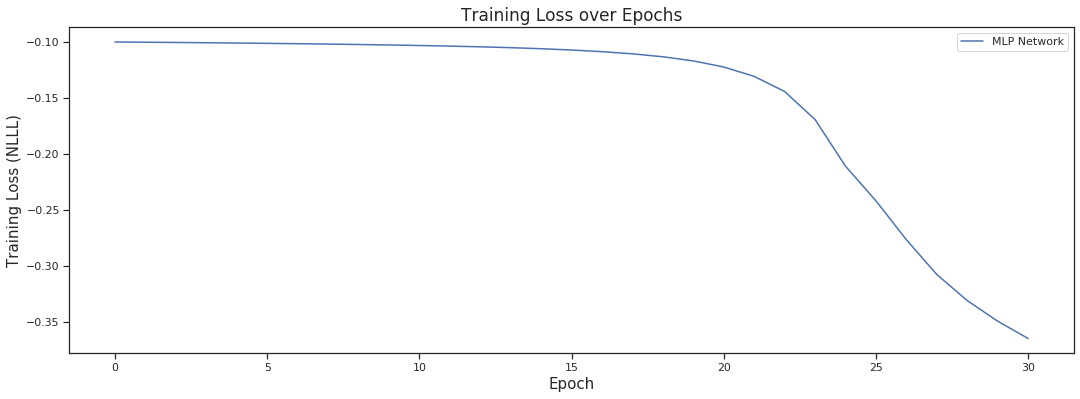

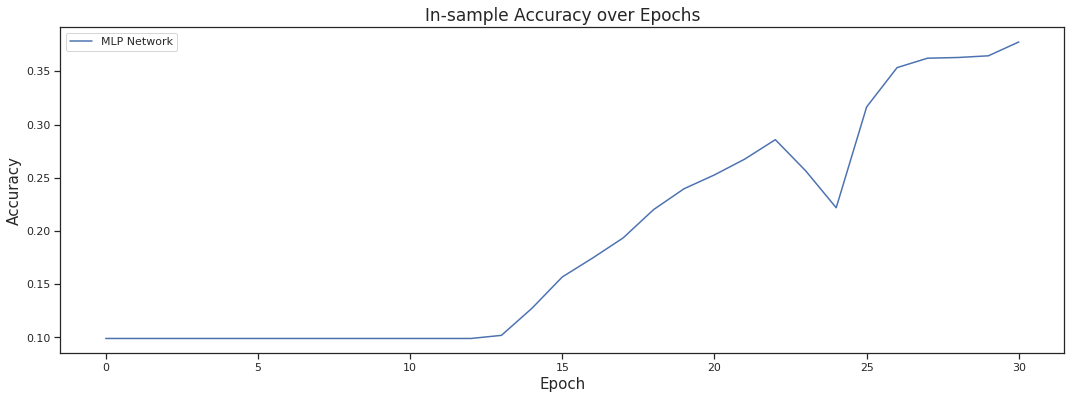

In [0]:
# Plot training loss
plot_stats([loss_mlp], ['MLP Network'], 'Training Loss over Epochs', 'Training Loss (NLLL)')

# Plot in-sample accuracy
plot_stats([accuracies_mlp], ['MLP Network'], 'In-sample Accuracy over Epochs', 'Accuracy')

The MLP has a slow convergence, with negligible improvement in in-sample accuracy up until around the 13th epoch. After this point we see a steady improvement up to around 0.40, with some noise affecting the improvement between the 20th and 25th epochs.

The training loss steadily decreases, with a faster decline seen after 20 epochs. This indicates steady improvement in the functioning of the model on the training data, unless if overfitting becomes an issue.

#### Evaluation of MLP Classifier

Now we use the testing set to evaluate the performance of the MLP classifier we trained above. We use the testing set of 10,000 images we set aside and don't use at all the training process.

This will determine the generalisability of the model, to see if we've overfitted to the training data, and to evaluate the best uses of the model that we've trained.

In [0]:
# Target names from the ground truths, in order
target_names = [
                'Top',
                'Trousers',
                'Pullover',
                'Dress',
                'Coat',
                'Sandal',
                'Shirt',
                'Sneaker',
                'Bag',
                'Ankle Boots'
                ]

In [0]:
%%time
test_loader_mlp = get_test_loader_from_arrays(batch_size, descriptors_test, target_test)
y_pred_mlp, _ = neural_network_predict(network_mlp, test_loader_mlp)
class_report_mlp = classification_report(y_true = target_test, y_pred = y_pred_mlp, target_names = target_names)
conf_matrix_mlp = confusion_matrix(y_true = target_test, y_pred = y_pred_mlp)

CPU times: user 189 ms, sys: 3.05 ms, total: 193 ms
Wall time: 203 ms


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
print('-- Classification Report: MLP Neural Network --')
print(class_report_mlp)

-- Classification Report: MLP Neural Network --
              precision    recall  f1-score   support

         Top       0.43      0.89      0.58      1000
    Trousers       0.70      0.94      0.80      1000
    Pullover       0.00      0.00      0.00      1000
       Dress       0.00      0.00      0.00      1000
        Coat       0.27      0.85      0.41      1000
      Sandal       0.00      0.00      0.00      1000
       Shirt       0.00      0.00      0.00      1000
     Sneaker       0.44      0.11      0.18      1000
         Bag       0.00      0.00      0.00      1000
 Ankle Boots       0.31      0.99      0.47      1000

    accuracy                           0.38     10000
   macro avg       0.21      0.38      0.24     10000
weighted avg       0.21      0.38      0.24     10000



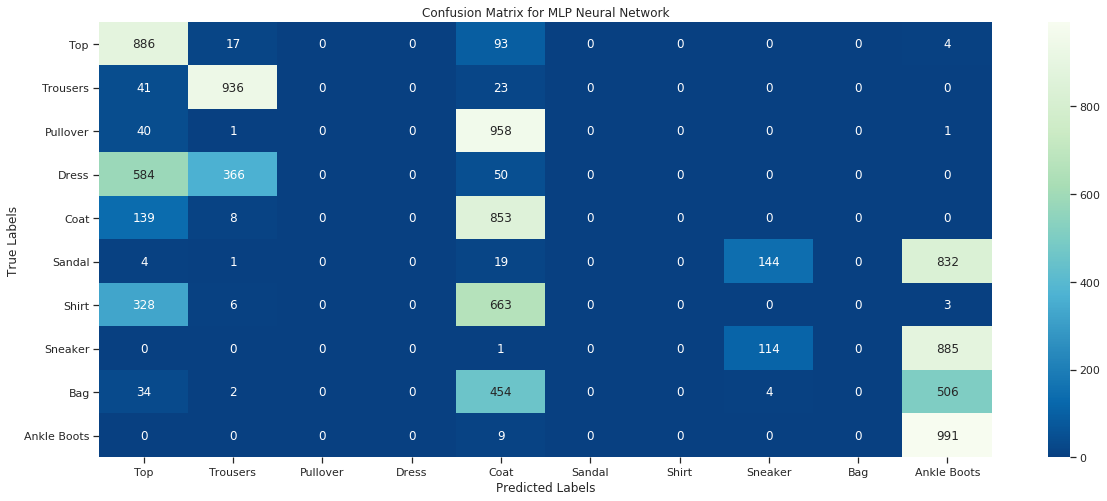

In [0]:
# Plot confusion matrix of MLP Neural Network
conf_matrix_heatmap(conf_matrix_mlp, 'Confusion Matrix for MLP Neural Network', target_names = target_names)

With an overall accuracy of 0.38, the **MLP has poor accuracy**. This is likely due to a low training rate and short training period. The in-sample accuracy and training loss is relatively stable for almost half of the total training period, meaning that the **model hasn't had the time to optimise weights effectively**.

The confusion matrix shows that the **model never assigns half of the labels available**, with no images in the testing set receiving the label pullover, dress, sandal, shirt, and bag. This may be because these images have subtler features distinguishing them, and given the low training time the model has yet to identify these classes.

The one area in which the model performs well is for trousers - the model is very accurate for classifying trousers, with an F1-Score of 0.80. Unlike the other classes with high recall rates such as tops, coats, and ankle boots, the **model is remarkably precise when labelling trousers**, with a precision of 0.70. This is a very high precision given that the next highest precision is 0.44.

It may be that the model has quickly picked up on the obvious characteristics that distinguish trousers from other classes, optimising weights for these particular characteristics.

The other classes for which images often get their true labelling are not precise. For example, this can be seen in the coat column of confusion matrix. A model that labels many images as coats will produce a model that has a high recall rate for coats but very poor accuracy.

In the case of coats, the majority of pullovers and sandals, and a significant number of bags. are mislabeled as coats. The model has not been able to correctly distinguish between these classes, and has chosen coats as the catch-all label to give to them.

### Task 2.2.2: Convolutional neural network (CNN) supervised classification

We expand on Task 2.2.1 by building a small Convolutional Neural Network (CNN) to classify the images of the dataset into the 10 classes of fashion items.

CNNs are a type of neural network, and they have been shown to be very effective in image recognition. CNNs are built similarly to multi layer perceptrons, but with four main processes:

* Convolution
* Non Linearity
* Sub Sampling
* Classification

Convolution extracts features from the data, preserving the structure of the data. For example in images, it will preserve how the pixels are spatially related to eachother instead of considering a single vector of 28*28 inputs.

Non Linearity is introduced into the process, usually through ReLU (Rectified Linear Unit). This particular example simply replaces all negative values with 0. The purpose of this step is to introduce non-linearity after the linear convolution stage, as most data found in reality is not linear.

Sub Sampling simply decreases the dimensionality of the feature map that comes out of the non linearity step. The goal is to reduce the space of the inputs, making input representations easier to deal with. This also helps to reduce overfitting as there are a smaller number of free values to tune.

Finally the fully connected layers are applied, as in the multi layer perceptron, to arrive at our final classification.

#### Defining the Convolutional Neural Network

Below, we define the general class for a convolutional neural network that has the architecture given in the coursework rubric. The process is as follows:

* Inputs: 28*28 images
* Convolutional layer
* Sub sampling
* Convolutional layer
* Sub sampling
* Full connection
* Full connection
* Output: Classification into one of ten classes.

In [0]:
# Define the Convolutional Neural Network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutions
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = (5, 5), stride = 1, dilation = 1)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = (5, 5), stride = 1, dilation = 1)

        # Sub-sampling
        self.pool1 = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        self.pool2 = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)


        # Full connections
        self.fc1 = nn.Linear(in_features = 16 * 4 * 4, out_features = 120)
        self.fc2 = nn.Linear(in_features = 120, out_features = 84)

        # Final pass - 84 input features, 10 output features (the 10 defined classes)
        self.end = nn.Linear(in_features = 84, out_features = 10)
        
        # Device
        self.to(dev)
    
    def forward(self, x):

        # Use ReLU as the activation function

        # Convolution and sub-sampling
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        # Reshape into (1, 16*4*4)
        x = x.view(-1, 16 * 4 * 4)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.end(x)

        x = F.softmax(x, dim = 1)

        return x

#### Reshaping the Data

Before training our CNN we need to reshape the vectors for the inputs into their 28*28 matrices that we can feed into the convolutional layers in order to identify features in the dataset.

In [0]:
def reshape_input_array(array):

    array_new = []

    for i in range(len(array)):
        array_new.append(array[i].reshape(28, 28))

    array_new = np.array(array_new)
    return array_new

In [0]:
# Reshape input arrays
descriptors_train_n = reshape_input_array(descriptors_train)
descriptors_test_n = reshape_input_array(descriptors_test)

#### Train the Convolutional Neural Network

Finally, we train the CNN over 30 epochs with a batch size of 128 and a learning rate of 0.005, as for the MLP network. We set aside some of the training data so that we can measure in-sample accuracy as the CNN trains.

In [0]:
# Create an instance of the convolutional neural network
network_cnn = CNN()

# Calculate losses, accuracies and return the trained network
loss_cnn, accuracies_cnn, network_cnn = neural_network_training(
    network_cnn,
    descriptors = descriptors_train_n,
    batch_size = 128,
    learning_rate = 0.005,
    print_loss_values = True,
    split_and_test = True,
    conv_net = True
    )

EPOCH COMPLETE - EPOCH [0 / 30] - TRAINING LOSS FOR EPOCH: -0.100
EPOCH COMPLETE - EPOCH [1 / 30] - TRAINING LOSS FOR EPOCH: -0.100
EPOCH COMPLETE - EPOCH [2 / 30] - TRAINING LOSS FOR EPOCH: -0.100
EPOCH COMPLETE - EPOCH [3 / 30] - TRAINING LOSS FOR EPOCH: -0.100
EPOCH COMPLETE - EPOCH [4 / 30] - TRAINING LOSS FOR EPOCH: -0.100
EPOCH COMPLETE - EPOCH [5 / 30] - TRAINING LOSS FOR EPOCH: -0.101
EPOCH COMPLETE - EPOCH [6 / 30] - TRAINING LOSS FOR EPOCH: -0.101
EPOCH COMPLETE - EPOCH [7 / 30] - TRAINING LOSS FOR EPOCH: -0.101
EPOCH COMPLETE - EPOCH [8 / 30] - TRAINING LOSS FOR EPOCH: -0.101
EPOCH COMPLETE - EPOCH [9 / 30] - TRAINING LOSS FOR EPOCH: -0.101
EPOCH COMPLETE - EPOCH [10 / 30] - TRAINING LOSS FOR EPOCH: -0.101
EPOCH COMPLETE - EPOCH [11 / 30] - TRAINING LOSS FOR EPOCH: -0.101
EPOCH COMPLETE - EPOCH [12 / 30] - TRAINING LOSS FOR EPOCH: -0.102
EPOCH COMPLETE - EPOCH [13 / 30] - TRAINING LOSS FOR EPOCH: -0.102
EPOCH COMPLETE - EPOCH [14 / 30] - TRAINING LOSS FOR EPOCH: -0.102
EPOCH

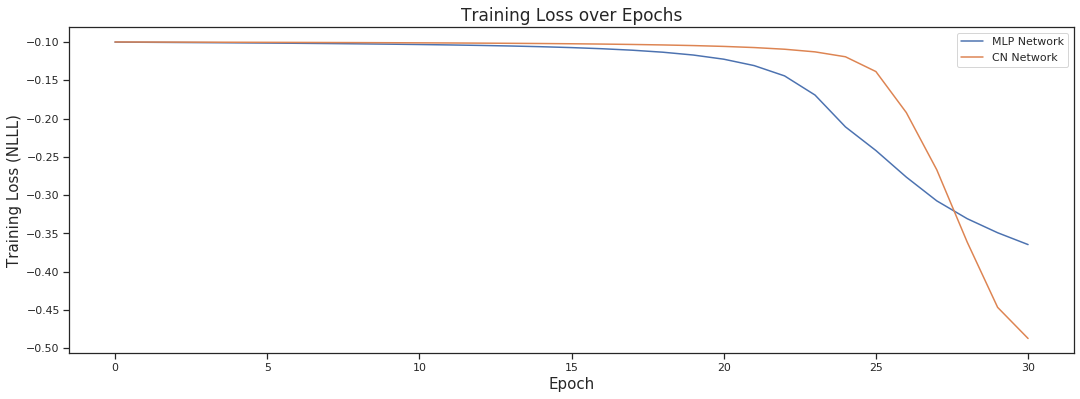

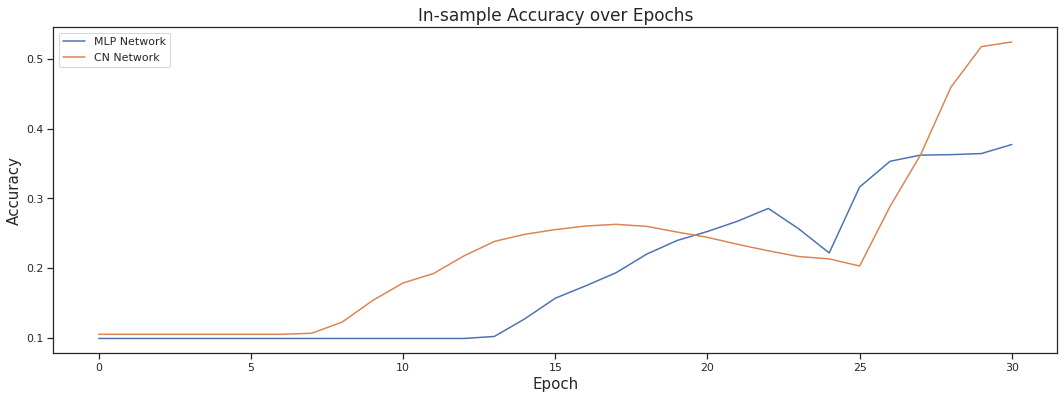

In [0]:
# Plot training loss
plot_stats([loss_mlp, loss_cnn], ['MLP Network', 'CN Network'], 'Training Loss over Epochs', 'Training Loss (NLLL)')

# Plot in-sample accuracy
plot_stats([accuracies_mlp, accuracies_cnn], ['MLP Network', 'CN Network'], 'In-sample Accuracy over Epochs', 'Accuracy')

The above plots show us the training loss and the accuracy over 30 epochs for the CNN, and of the MLP trained in Task 2.2.1 for comparison.

The CNN spends the majority of the training time slowly optimising weights before a sharp decline in training loss at 25 epochs. The CNN then achieves a lower final training loss than the MLP.

The CNN gains some accuracy earlier than the MLP at 6 epochs, arriving at a final higher in-sample accuracy of over 0.50 after some noise between epochs 15 to 25. The last 5 epochs of the train see the CNN converge very quickly, and this corresponds to the only notable sharp decline in training loss. The increase in accuracy before this point may be down to chance as training loss is relatively stable before 20 epochs.

The CNN is likely converging faster than the MLP in the last 5 epochs, and achieving a lower final training loss, as the **CNN is exploiting the spatial structure of the images** when classifying. 

#### Evaluation of Convolutional Neural Network

As before, we evaluate the performance of the CNN on the testing set to consider generalisability and accuracy.

In [0]:
%%time
test_loader_cnn = get_test_loader_from_arrays(batch_size, descriptors_test_n, target_test)
y_pred_cnn, _ = neural_network_predict(network_cnn, test_loader_cnn, conv_net = True)
class_report_cnn = classification_report(y_true = target_test, y_pred = y_pred_cnn, target_names = target_names)
conf_matrix_cnn = confusion_matrix(y_true = target_test, y_pred = y_pred_cnn)

CPU times: user 216 ms, sys: 8.04 ms, total: 224 ms
Wall time: 232 ms


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
print('-- Classification Report: Convolutional Neural Network --')
print(class_report_cnn)

-- Classification Report: Convolutional Neural Network --
              precision    recall  f1-score   support

         Top       0.00      0.00      0.00      1000
    Trousers       0.82      0.89      0.85      1000
    Pullover       0.26      0.94      0.41      1000
       Dress       0.59      0.79      0.67      1000
        Coat       0.00      0.00      0.00      1000
      Sandal       0.00      0.00      0.00      1000
       Shirt       0.00      0.00      0.00      1000
     Sneaker       0.61      0.85      0.71      1000
         Bag       0.78      0.80      0.79      1000
 Ankle Boots       0.61      0.93      0.74      1000

    accuracy                           0.52     10000
   macro avg       0.37      0.52      0.42     10000
weighted avg       0.37      0.52      0.42     10000



In [0]:
# Plot confusion matrix of MLP Neural Network
conf_matrix_heatmap(conf_matrix_cnn, 'Confusion Matrix for Convolutional Neural Network', target_names = target_names)

With an overall accuracy of 0.52, the **CNN has poor to moderate accuracy**. This is likely due to a low training rate and short training period. The in-sample accuracy and training loss is relatively stable for almost half of the total training period, and training for longer may show an even lower final training loss and higher in-sample accuracy.

The confusion matrix shows that the **model never assigns 4 of 10 labels available**, with no images in the testing set receiving the label top, coat, sandal and shirt. This may be because these images have subtler features distinguishing them, and given the low training time the model has yet to identify these classes.

The **model performs very well for classifying trousers**, with an F1 score of 0.85 and a remarkably high precision given the lower precision for other classes. The model has managed to pick out the characteristics that clearly individualise the trouser class, rarely not finding images labeled as trousers (high recall) and rarely mislabelling others as trousers (high precision). The bag sneakers is similar - the model performs well at classifiying bags with an F1 score of 0.79, but this accuracy is lower than the score for trousers due to higher numbers of mislabelling images as bag.

Similarly to the MLP, it appears that **the model has grouped the classes shirt, coat, pullover and top together into the label pullover**. This leads to an absurdly high recall score for pullovers but very low precision.

It appears to be the case that the architecture of the CNN has not been optimised to properly exploit the spatial characteristics of the images, in order to properly seperate the classes and precisely label pullovers.

### Task 2.2.3: Comparison of the classifiers

In this task we start by comparing the classifiers that we've defined, considering the parameters and operations that make them different and the difference in unsupervised and supervised approaches.

#### MLP and CNN Classifiers

First we'll look at how the two neural networks performed.

##### *Overall Accuracy*

The model accuracies are summarised in the table below.

|Model   |Overall F1 Score   | Average Precision | Average Recall|
|---|---|---|---|
|MLP|0.38|0.21|0.38|
|CNN|0.52|0.37|0.52|

By all of these measures, the CNN performed better than the MLP, with a 55% increase in precision and a 31% increase in recall.

##### *Accuracy for Particular Classes*

The **MLP could only precisely classify one class** - trousers had a precision 0.70 with the second best precision at 0.44. The CNN improved on this with four of the classes having precision scores of over 0.60, two of which were over 0.78.

The MLP was only assigning five of the 10 available layers, whilst the CNN improved on this by assigning six. The **CNN was able to pick out more seperations in the dataset** to labelling out-of-sample data.

##### *Analysis: Difference in Operations*

There are many reasons why the CNN performed better across most metrics than the standard MLP.
 
CNNs have the ability to exploit the spatial information gained by retaining the 28*28 pixel image as an input, instead of feeding it 784 unordered inputs. For example, retaining the shape of a handle or of the heel of a boot. This means there are far fewer operations needed to make sense of a single images, as trends are recognised more quickly by scanning through the image in patches in the convolutional layer.

For example, given a well chosen architecture, **a CNN will spot bags by simply scanning for the curve of a handle and giving less priority to other combinations and characteristics - the MLP will always give equal priority to all pixels**.

This also leads to better efficiency and less computational cost, which is why the CNN got to a higher accuracy in the same amount of time.

##### *Analysis: Difference in Parameters*

Through the use of sub-sampling in the Max Pooling layers of the CNN, where inputs are down-sized, the CNN has fewer weights to tune. Firstly, this lets the CNN assume certain characteristics about features not included in the sample. This means that **the architecture of the CNN will prevent overfitting to the degree of the MLP**. Having fewer parameters to tune also improves computationally efficency

#### MLP, CNN and KNN Classifiers

Now we compare the KNN classification performance to the neural networks.

##### *Overall Accuracy*

The model accuracies are summarised in the table below.

|Model   |Overall F1 Score   | Average Precision | Average Recall|
|---|---|---|---|
|K-Means with K-NN|0.54|0.51|0.54|
|MLP|0.38|0.21|0.38|
|CNN|0.52|0.37|0.52|

Overall, the **KNN classifier performed slightly better than the CNN** with an overall score of 0.54, and considerably better than the MLP. However, **overall the KNN was much more precise than the CNN**. The KNN was assigning 9 of the possible 10 labels, with only the class shirt having a precision and recall of 0.


##### *Accuracy for Particular Classes*

The **KNN was remarkably more precise in labelling bags, with a precision of 0.95** compared to 0 and 0.78 for the MLP and the CNN respectively. This precision was let down by recall - **KNN labeled 32.8% of bags as pullovers**. The CNN did not have this issue with a recall of 0.80 for this class, despite a lower precision. The other notable difference was that **KNN was 32% less precise in classifying trousers than the CNN**.

##### *Explanations: Differences in Approaches Used*

The KNN classifier was built by acquiring 'ground truth' labels through K-Means clustering, an unsupervised learning technique. These labels were based on raw image information to give labels instead of the human-chosen labels that the neural networks used.

The ground truth labels have many inconsistencies in them if us humans didn't understand them intuitively - many of the items are very clearly related visually as is the case for tops, pullovers and shirts. Items of the same class may look very different, which is the case for bags with large open handles and bags that look more like briefcases. It is pertinent to ask whether the ground truth labels are meaningful if they assign the same number to two objects that look very different and different numbers to two objects that look the same. **Are the human labels arbitrary, and is this why unsupervised learning works better in this case?**

The KNN classifier performed better overall in this task as instead of relying on human-labeled images, for which there is much natural inter-class variation and intra-class similarities due to the complexity of fashion item appearances, the **KNN Classifier relied on labels that were chosen according to pixel data. It is intuitive that the KNN was overall more precise than the neural networks at classifying pixel information, as the neural networks were working with labels generated by the inconsistent or unhelpful human labelling instead of labels determined by the pixel information itself.**

This is especially true for primitive and unoptimised neural networks, which can much more carefully pick out pixel information to seperate the classes (as we'll see at the end of this Task when we improve the CNN).

#### Improving the Convolutional Neural Network

The CNN did not perform very well as used in Task 2.2.2, so now we attempt to improve it to over 90% accuracy when testing on in-sample data using 5-Fold cross validation.

There are several different ideas that we can try to change to improve our model:
* Loss Function
* Optimiser
* Activation Functions
* Batch Norm Layers

In the following, I will assume these are independent and experiment with each one individually to improve the model. Given more time and computational cost, I would not assume independence, and I would use a Grid Search algorithm to optimise each of these hyperparameters.

##### Loss Function

The first key change I will make is to use Cross Entropy Loss directly as the cost function instead of negative log likelihood loss. This means we can take the soft max out of the classes defining the CNNs.

In [0]:
# Define the Convolutional Neural Network, with no softmax
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()

        # Convolutions
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = (5, 5), stride = 1, dilation = 1)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = (5, 5), stride = 1, dilation = 1)

        # Sub-sampling
        self.pool1 = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        self.pool2 = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)


        # Full connections
        self.fc1 = nn.Linear(in_features = 16 * 4 * 4, out_features = 120)
        self.fc2 = nn.Linear(in_features = 120, out_features = 84)

        # Final pass - 84 input features, 10 output features (the 10 defined classes)
        self.end = nn.Linear(in_features = 84, out_features = 10)
        
        # Device
        self.to(dev)
    
    def forward(self, x):

        # Use ReLU as the activation function

        # Convolution and sub-sampling
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        # Reshape into (1, 16*4*4)
        x = x.view(-1, 16 * 4 * 4)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.end(x)

        return x

In [0]:
# Redefine the loss function as Cross Entropy Loss
loss_fct_cep = nn.CrossEntropyLoss()

Before continuing, we'll use 5-Fold cross validation on the training set to see if the CNN architecture has been improved.

In [0]:
# Define the cross validation method
cv = KFold(n_splits = 5)

In [0]:
%%time
# Calculate accuracy of base CNN using 5-fold CV on the training set.
# - This is the original CNN with NLLLoss as the cost function
cnn_1_acc = neural_network_accuracy_cv(CNN(), cv, descriptors = descriptors_train_n, conv_net = True)

CPU times: user 3min 14s, sys: 7.67 s, total: 3min 21s
Wall time: 3min 24s


In [0]:
%%time
# Calculate accuracy of CNN2 using 5-fold CV on the training set
cnn_2_acc = neural_network_accuracy_cv(CNN2(), cv, descriptors = descriptors_train_n, conv_net = True, criterion = loss_fct_cep)

CPU times: user 3min 9s, sys: 7.95 s, total: 3min 17s
Wall time: 3min 19s


In [0]:
# Print the accuracies of the two CNNs
cnn_accs = PrettyTable(['Loss Function Used', 'Accuracy using 5-Fold CV on Training Set'])
cnn_accs.add_row(['Negative Log Likelihood Loss (Base Network)', '%.3f' %(cnn_1_acc)])
cnn_accs.add_row(['Cross Entropy Loss', '%.3f' %(cnn_2_acc)])

print('-- Accuracies of Alternate CNNs using 5-Fold CV --')
print(cnn_accs)

-- Accuracies of Alternate CNNs using 5-Fold CV --
+---------------------------------------------+------------------------------------------+
|              Loss Function Used             | Accuracy using 5-Fold CV on Training Set |
+---------------------------------------------+------------------------------------------+
| Negative Log Likelihood Loss (Base Network) |                  0.567                   |
|              Cross Entropy Loss             |                  0.866                   |
+---------------------------------------------+------------------------------------------+


As we can see, changing the loss function to Cross Entropy Loss and taking out the Soft Max from within the CNN class has greatly improved our in-sample accuracy on the training data.

In all our following analysis I will use Cross Entropy Loss.

##### Optimiser

We'll also explore, using the same cross-validation process, how the optimiser changes our neural network. The two optimisers I will compare to SGD are the Adam optimiser and the RMSprop optimiser.

I expect the Adam and RMSprop optimisers to improve the CNN as they converge to the minimum of the loss function through adaptive learning rates.

In [0]:
# Function for returning an Adam optimiser
def optimiser_adam(network, learning_rate):
    optimiser_adam = torch.optim.Adam(network.parameters(), lr = learning_rate) 
    return optimiser_adam

# Function for returning an RMSprop optimiser
def optimiser_rmsp(network, learning_rate):
    optimiser_rmsp = torch.optim.RMSprop(network.parameters(), lr = learning_rate) 
    return optimiser_rsmp

In [0]:
%%time
# Calculate accuracy of CNN2 using 5-fold CV on the training set, using Adam as the optimiser
cnn_3_acc = neural_network_accuracy_cv(CNN2(), cv, descriptors = descriptors_train_n, conv_net = True, criterion = loss_fct_cep, optimiser_fct = optimiser_adam)

CPU times: user 4min 51s, sys: 4.87 s, total: 4min 56s
Wall time: 4min 59s


In [0]:
%%time
# Calculate accuracy of CNN2 using 5-fold CV on the training set, using RMSprop as the optimiser
cnn_4_acc = neural_network_accuracy_cv(CNN2(), cv, descriptors = descriptors_train_n, conv_net = True, criterion = loss_fct_cep, optimiser_fct = optimiser_rmsp)

CPU times: user 4min 6s, sys: 5.1 s, total: 4min 11s
Wall time: 4min 14s


In [0]:
# Print the accuracies of the two CNNs
cnn_accs_2 = PrettyTable(['Optimiser Used', 'Accuracy using 5-Fold CV on Training Set'])
cnn_accs_2.add_row(['SGD', '%.3f' %(cnn_2_acc)])
cnn_accs_2.add_row(['Adam', '%.3f' %(cnn_3_acc)])
cnn_accs_2.add_row(['RMSprop', '%.3f' %(cnn_4_acc)])

print('-- Accuracies of Alternate CNNs using 5-Fold CV --')
print(cnn_accs_2)

-- Accuracies of Alternate CNNs using 5-Fold CV --
+----------------+------------------------------------------+
| Optimiser Used | Accuracy using 5-Fold CV on Training Set |
+----------------+------------------------------------------+
|      SGD       |                  0.866                   |
|      Adam      |                  0.900                   |
|    RMSprop     |                  0.894                   |
+----------------+------------------------------------------+


As expected, the use of the Adam optimiser has given us an accuracy of 0.9, which is higher than using SGD. RMSprop also gives a better result than SGD, only performing slightly worse than the Adam optimiser.

In all further analysis I will use the Adam optimiser.

##### Activation Functions

Another aspect to change is the activation functions that we use to introduce non-linearity into the CNN. In our base network we use ReLU, but there are many different functions we can use instead.

We will test out using Hard Tanh and Sigmoid as activation functions to compare to ReLU. These are chosen so that we're covering the three main types of activation function used: Sigmoid/Logistic, hyperbolic tangent, and ReLU.

We'll try out changing the activation functions for just the fully connected layers, and for both the fully connected layers and the convolutional layers.



In [0]:
# Define the Convolutional Neural Network.
# - Activation Functions on Convolutional Layers: ReLU
# - Activation Functions on Fully Connected Layers: HardTanh
class CNN31(nn.Module):
    def __init__(self):
        super(CNN31, self).__init__()

        # Convolutions
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = (5, 5), stride = 1, dilation = 1)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = (5, 5), stride = 1, dilation = 1)

        # Sub-sampling
        self.pool1 = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        self.pool2 = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)

        # Full connections
        self.fc1 = nn.Linear(in_features = 16 * 4 * 4, out_features = 120)
        self.fc2 = nn.Linear(in_features = 120, out_features = 84)

        # Final pass - 84 input features, 10 output features (the 10 defined classes)
        self.end = nn.Linear(in_features = 84, out_features = 10)
        
        # Device
        self.to(dev)
    
    def forward(self, x):

        # Convolution and sub-sampling
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        # Reshape into (1, 16*4*4)
        x = x.view(-1, 16 * 4 * 4)

        # Fully connected layers
        x = F.hardtanh(self.fc1(x))
        x = F.hardtanh(self.fc2(x))
        x = self.end(x)

        return x

In [0]:
# Define the Convolutional Neural Network
# - Activation Functions on Convolutional Layers: HardTanh
# - Activation Functions on Fully Connected Layers: HardTanh
class CNN32(nn.Module):
    def __init__(self):
        super(CNN32, self).__init__()

        # Convolutions
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = (5, 5), stride = 1, dilation = 1)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = (5, 5), stride = 1, dilation = 1)

        # Sub-sampling
        self.pool1 = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        self.pool2 = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)

        # Full connections
        self.fc1 = nn.Linear(in_features = 16 * 4 * 4, out_features = 120)
        self.fc2 = nn.Linear(in_features = 120, out_features = 84)

        # Final pass - 84 input features, 10 output features (the 10 defined classes)
        self.end = nn.Linear(in_features = 84, out_features = 10)
        
        # Device
        self.to(dev)
    
    def forward(self, x):

        # Convolution and sub-sampling
        x = F.hardtanh(self.conv1(x))
        x = self.pool1(x)
        x = F.hardtanh(self.conv2(x))
        x = self.pool2(x)

        # Reshape into (1, 16*4*4)
        x = x.view(-1, 16 * 4 * 4)

        # Fully connected layers
        x = F.hardtanh(self.fc1(x))
        x = F.hardtanh(self.fc2(x))
        x = self.end(x)

        return x

In [0]:
# Define the Convolutional Neural Network
# - Activation Functions on Convolutional Layers: ReLU
# - Activation Functions on Fully Connected Layers: Sigmoid
class CNN41(nn.Module):
    def __init__(self):
        super(CNN41, self).__init__()

        # Convolutions
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = (5, 5), stride = 1, dilation = 1)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = (5, 5), stride = 1, dilation = 1)

        # Sub-sampling
        self.pool1 = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        self.pool2 = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)

        # Full connections
        self.fc1 = nn.Linear(in_features = 16 * 4 * 4, out_features = 120)
        self.fc2 = nn.Linear(in_features = 120, out_features = 84)

        # Final pass - 84 input features, 10 output features (the 10 defined classes)
        self.end = nn.Linear(in_features = 84, out_features = 10)
        
        # Device
        self.to(dev)
    
    def forward(self, x):

        # Convolution and sub-sampling
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        # Reshape into (1, 16*4*4)
        x = x.view(-1, 16 * 4 * 4)

        # Fully connected layers
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.end(x)

        return x

In [0]:
# Define the Convolutional Neural Network
# - Activation Functions on Convolutional Layers: Sigmoid
# - Activation Functions on Fully Connected Layers: Sigmoid
class CNN42(nn.Module):
    def __init__(self):
        super(CNN42, self).__init__()

        # Convolutions
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = (5, 5), stride = 1, dilation = 1)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = (5, 5), stride = 1, dilation = 1)

        # Sub-sampling
        self.pool1 = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        self.pool2 = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)

        # Full connections
        self.fc1 = nn.Linear(in_features = 16 * 4 * 4, out_features = 120)
        self.fc2 = nn.Linear(in_features = 120, out_features = 84)

        # Final pass - 84 input features, 10 output features (the 10 defined classes)
        self.end = nn.Linear(in_features = 84, out_features = 10)
        
        # Device
        self.to(dev)
    
    def forward(self, x):

        # Convolution and sub-sampling
        x = torch.sigmoid(self.conv1(x))
        x = self.pool1(x)
        x = torch.sigmoid(self.conv2(x))
        x = self.pool2(x)

        # Reshape into (1, 16*4*4)
        x = x.view(-1, 16 * 4 * 4)

        # Fully connected layers
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.end(x)

        return x

Now that we've defined the classes, we can test out the networks as before.

In [0]:
%%time
# Calculate accuracy of CNN31 using 5-fold CV on the training set.
cnn_51_acc = neural_network_accuracy_cv(CNN31(), cv, descriptors = descriptors_train_n, conv_net = True, criterion = loss_fct_cep, optimiser_fct = optimiser_adam)

CPU times: user 4min 52s, sys: 4.68 s, total: 4min 57s
Wall time: 5min


In [0]:
%%time
# Calculate accuracy of CNN2 using 5-fold CV on the training set, using Adam as the optimiser
cnn_52_acc = neural_network_accuracy_cv(CNN32(), cv, descriptors = descriptors_train_n, conv_net = True, criterion = loss_fct_cep, optimiser_fct = optimiser_adam)

CPU times: user 4min 51s, sys: 5.18 s, total: 4min 56s
Wall time: 4min 59s


In [0]:
%%time
# Calculate accuracy of CNN2 using 5-fold CV on the training set, using Adam as the optimiser
cnn_61_acc = neural_network_accuracy_cv(CNN41(), cv, descriptors = descriptors_train_n, conv_net = True, criterion = loss_fct_cep, optimiser_fct = optimiser_adam)

CPU times: user 4min 52s, sys: 5.18 s, total: 4min 57s
Wall time: 5min


In [0]:
%%time
# Calculate accuracy of CNN2 using 5-fold CV on the training set, using Adam as the optimiser
cnn_62_acc = neural_network_accuracy_cv(CNN42(), cv, descriptors = descriptors_train_n, conv_net = True, criterion = loss_fct_cep, optimiser_fct = optimiser_adam)

CPU times: user 4min 53s, sys: 5.19 s, total: 4min 58s
Wall time: 5min 1s


In [0]:
# Print the accuracies of the CNNs
cnn_accs_3 = PrettyTable(['Activation Function - Fully Connected Layer', 'Activation Function - Convolutional Layer', 'Accuracy using 5-Fold CV on Training Set'])
cnn_accs_3.add_row(['ReLU', 'ReLU', '%.3f' %(cnn_3_acc)])
cnn_accs_3.add_row(['Hard Tanh', 'ReLU', '%.3f' %(cnn_51_acc)])
cnn_accs_3.add_row(['Hard Tanh', 'Hard Tanh', '%.3f' %(cnn_52_acc)])
cnn_accs_3.add_row(['Sigmoid', 'ReLU', '%.3f' %(cnn_61_acc)])
cnn_accs_3.add_row(['Sigmoid', 'Sigmoid', '%.3f' %(cnn_62_acc)])

print('-- Accuracies of Alternate CNNs using 5-Fold CV --')
print(cnn_accs_3)

-- Accuracies of Alternate CNNs using 5-Fold CV --
+---------------------------------------------+-------------------------------------------+------------------------------------------+
| Activation Function - Fully Connected Layer | Activation Function - Convolutional Layer | Accuracy using 5-Fold CV on Training Set |
+---------------------------------------------+-------------------------------------------+------------------------------------------+
|                     ReLU                    |                    ReLU                   |                  0.900                   |
|                  Hard Tanh                  |                    ReLU                   |                  0.873                   |
|                  Hard Tanh                  |                 Hard Tanh                 |                  0.870                   |
|                   Sigmoid                   |                    ReLU                   |                  0.902                   |
|   

We can conclude that the best set of activation functions to use is to have Sigmoids on the fully connected and the convolutional layers.

Hard Tanh clearly diminished the quality of the neural network.

Sigmoids have the benefit of not causing the activation to go to infinity, which can be the case for ReLU. We also don't have the Dying ReLU problem where units of the network start giving the output of zero and stop learning.

Sigmoids can cause issues for when there are a lot of layers as the gradient can become extremely small, so each time the gradient step occurs there is a tiny movement leading to very slow convergence. This problem seems to be avoided here as there are only two fully connected layers.

##### Batch Norm

Finally, we will add batch-norm layers in the CNN with Sigmoid activations, with our training completed using Adam optimisation and Cross Entropy Loss.

I'm adding batch-norm layers as this helps each layer can learn more independently. Batch-norm means the optimisation process can be smoother, making gradients in the optimisation process more stable. This leads to faster training. [2]

Batch-norm also tends to reduce overfitting.

In [0]:
# Define the Convolutional Neural Network
# - Activation Functions on Convolutional Layers: Sigmoid
# - Activation Functions on Fully Connected Layers: Sigmoid
class CNN5(nn.Module):
    def __init__(self):
        super(CNN5, self).__init__()

        # Batch Norm
        self.bn1 = nn.BatchNorm2d(6)
        self.bn2 = nn.BatchNorm2d(16)

        # Convolutions
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = (5, 5), stride = 1, dilation = 1)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = (5, 5), stride = 1, dilation = 1)

        # Sub-sampling
        self.pool1 = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        self.pool2 = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)

        # Full connections
        self.fc1 = nn.Linear(in_features = 16 * 4 * 4, out_features = 120)
        self.fc2 = nn.Linear(in_features = 120, out_features = 84)

        # Final pass - 84 input features, 10 output features (the 10 defined classes)
        self.end = nn.Linear(in_features = 84, out_features = 10)
        
        # Device
        self.to(dev)
    
    def forward(self, x):

        # Convolution and sub-sampling
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.sigmoid(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.sigmoid(x)
        x = self.pool2(x)

        # Reshape into (1, 16*4*4)
        x = x.view(-1, 16 * 4 * 4)

        # Fully connected layers
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.end(x)

        return x

As this is our final model, first we'll compute the accuracy without using 5-fold CV to see how our model evolves over the training period.

In [32]:
# Create an instance of the convolutional neural network
cnn5 = CNN5()

# Calculate losses, accuracies and return the trained network
loss_cnn_5, accuracies_cnn_5, network_cnn_5 = neural_network_training(
    cnn5,
    descriptors = descriptors_train_n,
    batch_size = 128,
    learning_rate = 0.005,
    print_loss_values = True,
    split_and_test = True,
    conv_net = True,
    optimiser_fct = optimiser_adam,
    criterion = loss_fct_cep
    )

EPOCH COMPLETE - EPOCH [0 / 30] - TRAINING LOSS FOR EPOCH: 0.885
EPOCH COMPLETE - EPOCH [1 / 30] - TRAINING LOSS FOR EPOCH: 0.496
EPOCH COMPLETE - EPOCH [2 / 30] - TRAINING LOSS FOR EPOCH: 0.420
EPOCH COMPLETE - EPOCH [3 / 30] - TRAINING LOSS FOR EPOCH: 0.368
EPOCH COMPLETE - EPOCH [4 / 30] - TRAINING LOSS FOR EPOCH: 0.339
EPOCH COMPLETE - EPOCH [5 / 30] - TRAINING LOSS FOR EPOCH: 0.318
EPOCH COMPLETE - EPOCH [6 / 30] - TRAINING LOSS FOR EPOCH: 0.300
EPOCH COMPLETE - EPOCH [7 / 30] - TRAINING LOSS FOR EPOCH: 0.285
EPOCH COMPLETE - EPOCH [8 / 30] - TRAINING LOSS FOR EPOCH: 0.271
EPOCH COMPLETE - EPOCH [9 / 30] - TRAINING LOSS FOR EPOCH: 0.260
EPOCH COMPLETE - EPOCH [10 / 30] - TRAINING LOSS FOR EPOCH: 0.252
EPOCH COMPLETE - EPOCH [11 / 30] - TRAINING LOSS FOR EPOCH: 0.243
EPOCH COMPLETE - EPOCH [12 / 30] - TRAINING LOSS FOR EPOCH: 0.235
EPOCH COMPLETE - EPOCH [13 / 30] - TRAINING LOSS FOR EPOCH: 0.226
EPOCH COMPLETE - EPOCH [14 / 30] - TRAINING LOSS FOR EPOCH: 0.221
EPOCH COMPLETE - EPO

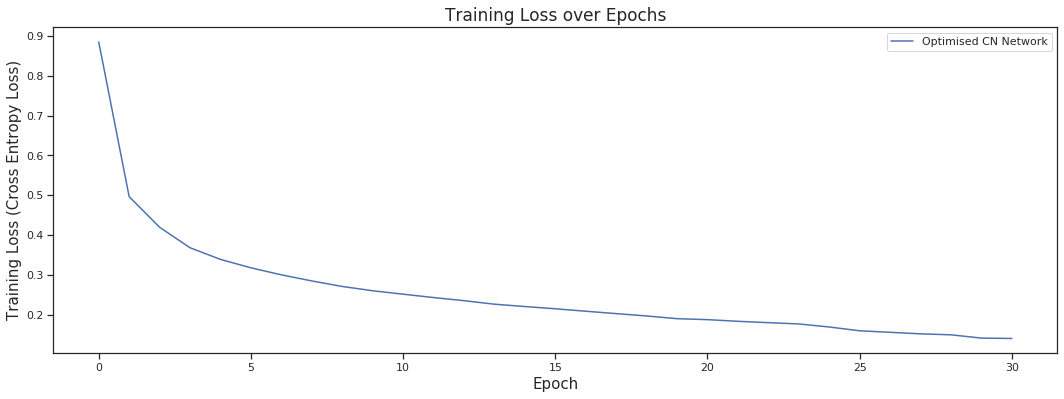

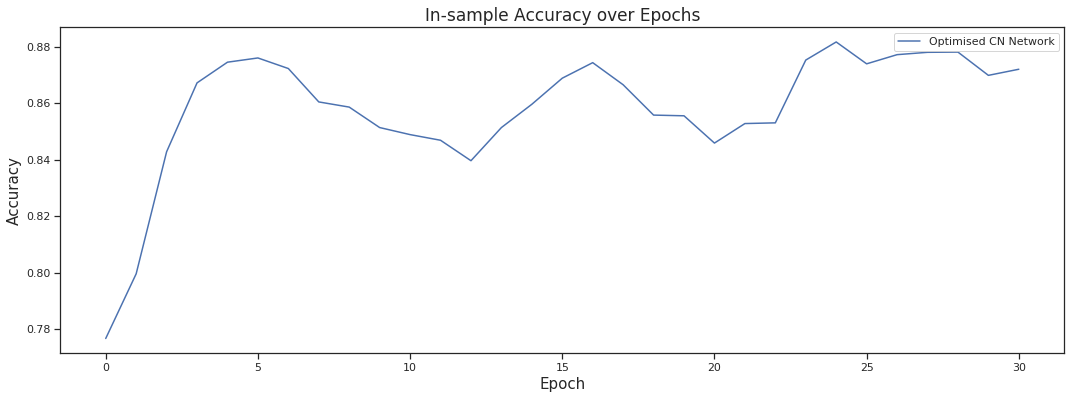

In [33]:
# Plot training loss
plot_stats([loss_cnn_5], ['Optimised CN Network'], 'Training Loss over Epochs', 'Training Loss (Cross Entropy Loss)')

# Plot in-sample accuracy
plot_stats([accuracies_cnn_5], ['Optimised CN Network'], 'In-sample Accuracy over Epochs', 'Accuracy')

The training over the 30 epochs is much more impressive than what was seen in our base CNN. The convergence is exceptionally fast with the training loss dropping very quickly in the first three epochs. In sample accuracy also reaches high values in this time, with some improvement in the later epochs.

Finally, we compute the accuracy of the optimised CNN using 5-Fold cross validation on the training data.

In [34]:
%%time
# Calculate accuracy of CNN5 using 5-fold CV on the training set
cnn_7_acc = neural_network_accuracy_cv(CNN5(), cv, descriptors = descriptors_train_n, conv_net = True, criterion = loss_fct_cep, optimiser_fct = optimiser_adam)

CPU times: user 4min 7s, sys: 6.36 s, total: 4min 13s
Wall time: 4min 15s


In [36]:
print('Final CNN Accuracy using 5-fold CV: %.3f' %(cnn_7_acc))

Final CNN Accuracy using 5-fold CV: 0.918


The use of batch-norm layers has increased the accuracy of the CNN to around 92%, a slight improvement on our previous best score, and a remarkable improvement from our base CNN.

Batch-norm in this case also decreased computational cost, taking just over four minutes to run the cross-validation instead of just over five minutes for the CNNs without batch-norm.

##### Use of Final CNN on the Test Set

We close this task by trying out our optimised CNN on the test set. The final CNN model achieved a cross-validated in-sample accuracy of 92%, so now it's time to verify the generalisability of the model.

In [37]:
%%time
# Get classification report and accuracy scores
test_loader_cnn_final = get_test_loader_from_arrays(batch_size, descriptors_test_n, target_test)
y_pred_cnn_final, _ = neural_network_predict(network_cnn_5, test_loader_cnn_final, conv_net = True)
class_report_cnn_final = classification_report(y_true = target_test, y_pred = y_pred_cnn_final, target_names = target_names)
conf_matrix_cnn_final = confusion_matrix(y_true = target_test, y_pred = y_pred_cnn_final)

CPU times: user 184 ms, sys: 10.9 ms, total: 195 ms
Wall time: 211 ms


In [38]:
print('-- Classification Report: Convolutional Neural Network --')
print(class_report_cnn_final)

-- Classification Report: Convolutional Neural Network --
              precision    recall  f1-score   support

         Top       0.73      0.90      0.81      1000
    Trousers       0.97      0.98      0.98      1000
    Pullover       0.72      0.88      0.80      1000
       Dress       0.94      0.86      0.90      1000
        Coat       0.84      0.73      0.78      1000
      Sandal       0.94      0.99      0.96      1000
       Shirt       0.76      0.54      0.63      1000
     Sneaker       0.97      0.91      0.94      1000
         Bag       0.95      0.97      0.96      1000
 Ankle Boots       0.96      0.96      0.96      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



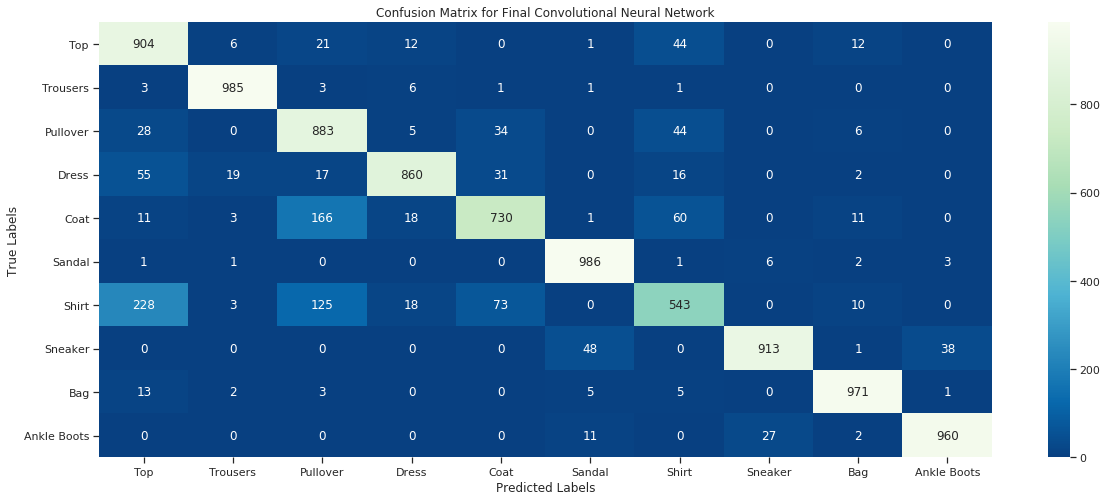

In [42]:
# Plot confusion matrix of Final Convolutional Neural Network
conf_matrix_heatmap(conf_matrix_cnn_final, 'Confusion Matrix for Final Convolutional Neural Network', target_names = target_names)

Overall, the final CNN is a huge improvement on all previous classifiers in this project - the **final CNN has an overall F1 Score 61% higher than the KNN**, the next best classifier.

This **model performs near-perfectly for four of the ten classes with F1 Scores of over 96%**, with two more classes having F1 Scores of over 90%. Three more classes have scores of over 78%, with only one class obtaining a relatively low score of 63%.

In summary, the **model performs exceptionally for classifying 9 of the 10 classes**, indicating **reliable generalisability to out of sample data**.

There are two cases where the F1 scores are being brought down by certain metrics.
* The **model struggles to find all of the shirts in the dataset**, with a recall rate of 54%. This is comparitively very poor compared to the rest of the model.
* Despite identifying 90% of the tops in the dataset, the model has a relatively low precision of 73% for this class. This also true to a lesser extent for pullovers. This is due to the model **overlabelling tops and pullovers as shirts**.

Despite very high performance overall in cross-validation on training data, the model is struggling to be generalised to out-of-sample images of shirts. This indicates **overfitting on shirts in the training data**.

Finally, there are a couple of noteworthy cases of excellence in the final model:
* The **model is extremely precise at labelling sneakers with a precision of 97%**.
* The **model is remarkably good at finding all of the sandals in the dataset, with a recall of 99%**.

In these two cases in particular, the model has successfully optimised performance and prevented overfitting.

##### Further Considerations

**Initial tests revealed that adding additional fully connected layers was not beneficial**, but the number of channels in each convolution and the number of inputs and outputs for the fully connected layers could be tested.

To gain more insight into the dependence of our changes to the neural network architecture I would run a grid-search testing all combinations of the activation functions, optimisers, loss functions, and use of batch-norm that we implemented above. Grid Searching was prohibitively computationally expensive in this case as each combination of parameters required 5-6 minutes for a cross-validation to complete.

I would also observe how learning rates and use of drop out in the fully connected layers would increase accuracy.

# Task 4: Dimensionality reduction of images (Mastery)

This task is concerned with using dimensionality reduction in an unsupervised manner to find classes and groupings within the fashion item dataset. We do this in three ways: Principal Component Analysis (PCA), Non-Negative Matrix Factorisation (NMF), and Latent Dirichlet Allocation (LDA).

## Task 4.1 Comparing PCA and NMF dimensionality reduction

First we consider two different methods for dimensionality reduction: PCA and NMF. Both work similarly by producing a given number of components that can be linearly combined to produce points in the data set, but with very different kinds of components.

We approach this by simply visualising the components of each trained model and how closely they're related to the classes of the data quantitatively. Afterwards this will be followed by a comparison and analysis at the end.

### PCA

We use PCA to get the features of the data that can tell us the most about the images - the principle components that can be combined to produce the rest. As we have 10 different fashion items defining the classes, we assume that we should have 10 principle components.

We use the built-in PCA functionality in SK-Learn to visualise the 10 components that PCA gives us.

In [0]:
# Fit PCA model
pca = PCA(n_components = 10, random_state = seed).fit(descriptors_train)

In [0]:
# Get PCA components
components_pca = [component.reshape(28, 28) for component in pca.components_]

In the following plot I don't include axis labels or colour bars for clarity. The plot is visualising 28 by 28 pixel images.

Instead of using our previous greyscale we use a red-white-blue colour scale - this is because in PCA negative values are also permitted. Blue corresponds to negative values, and red to positive values, with white at 0.

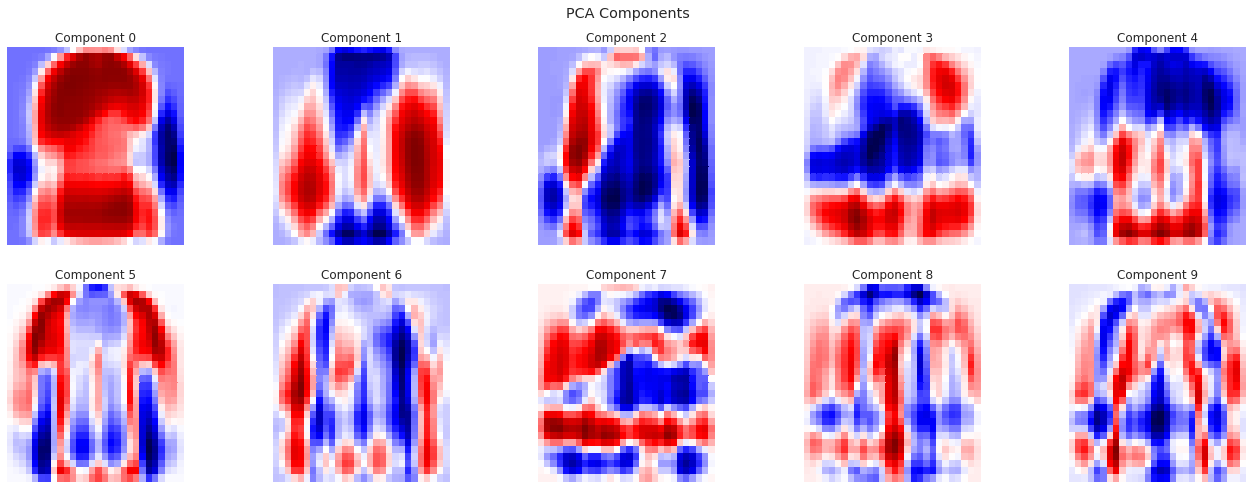

In [0]:
# Plot PCA components
plot_components(components_pca, 'PCA Components', 'Component', cmap = 'seismic')

There 10 components aren't intuitive representations of each class. We can see some features within the components that correspond to parts of the clothing items.

For example, in dark blue in Component 3 we see some semblance of the outline of a sneaker.

We can also consider the variances in the principal components.

In [0]:
# Get variance of components
pca_var = pca.explained_variance_

In [0]:
# Bar plot for variance of PCA components
def plot_dr_var(var, title = 'Variance Explained of PCA Components', num = 10, align = 'center'):
    plt.bar(range(num), var)
    fig = plt.gcf()
    fig.set_size_inches(12, 8)

    # Labelling
    plt.xticks(range(num))
    plt.xlabel('Components')
    plt.ylabel('Variance')
    plt.title(title)
    plt.show()

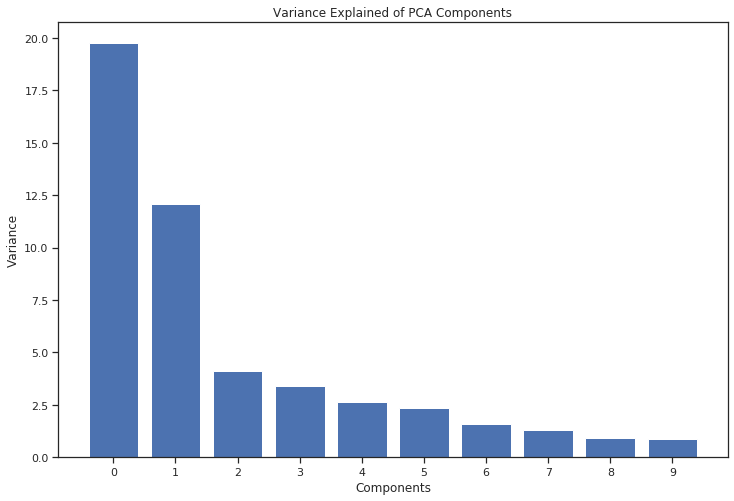

In [0]:
# Plot explained variance
plot_dr_var(pca_var)

The variance in the plot above is the ratio of the variance of that component and the total variance. PCA works by maximising this explained variance for some of the principal components. The plot shows that over 30% of the variance is in the first two components.

Now we can use the PCA model to reduce the dimensionality of the data - namely, the images that are formed of 28*28 are now being represented by just 10 dimensions.

In [0]:
# Transform the training data into the 10 components.
x_pca = pca.transform(descriptors_train)

In [0]:
# Move the data into a dataframe
df_pca = pd.DataFrame(x_pca)

# Add the class on the end
df_pca['class'] = target_train

In [0]:
# Observe the data set
df_pca

0         1         2  ...         8         9  class
0      3.685716  4.960884 -0.050659  ...  1.119003  0.777965      2
1     -4.376524  3.860244 -1.948038  ... -1.419258 -0.976637      9
2      7.265114  1.568878  2.315163  ...  0.431010 -0.092631      6
3      3.227989 -2.325147 -0.649676  ...  0.046432 -0.620557      0
4      4.146636 -4.038755 -1.515419  ...  2.031812 -0.349346      3
...         ...       ...       ...  ...       ...       ...    ...
59995  0.017376  5.188526 -5.056262  ...  0.546828  0.398646      9
59996 -3.114743 -5.211896 -0.105400  ... -0.596811  0.020473      1
59997  2.181717  0.451601 -0.556137  ...  0.079824  0.079642      8
59998  1.469507  6.063589 -0.624424  ...  0.103274  1.327332      8
59999 -3.572735  4.771599 -0.265233  ... -0.732401  0.107408      7

[60000 rows x 11 columns]

For any given row, the higher the absolute value for a certain dimension (or weight), the more susceptible an image is to that dimension.

We will study quantitatively how the dimensions are related to the ten classes by taking averages of all the dimensions for each true class label 0 to 9, and observing trends in the values for each component

In [0]:
# Given a dimensionaly reduced dataset, this gives a summary dataframe of the averages for each dimension
def averages_df(df):
    summary_df = pd.DataFrame()
    for i in range(10):
        # Get column name
        column = target_names[i]

        # Get the mean value for each dimension for each class
        summary_df[column] = df.loc[df['class'] == i].mean().drop('class')
    summary_df.index.name = 'Component'
    return summary_df

In [0]:
# Get averages of values for each dimension across the whole dataset
df_avg_pca = averages_df(df_pca)

In [0]:
# General function for a confusion matrix heatmap
def plot_averages_heatmap(df, title, cmap = 'GnBu', vmin = None, vmax = None):
    plt.figure(figsize = (20, 8))
    plt.title(title)
    sns.heatmap(df, annot = True, cmap = cmap, vmin = vmin, vmax = vmax)
    plt.xlabel('Class')
    plt.ylabel('Component')
    plt.show()

In [0]:
# Plot a heatmap of the averages
plot_averages_heatmap(df_avg_pca, 'PCA: Average Values for Reduced Training Data across True Class Labels', 'seismic', -6, 6)

Negative values correspond to the negative weighting given to the component for a particular class, and positive values correspond to the positive weighting.

This above visualisation gives us some information on how the components are related to each class. There is no strong quantitative evidence for links between components and the classes, as otherwise we would see more obvious patterns for each column.

There are some key examples where there is a link between components and the fashion items.

* Component 1 has a very large negative average value for the class Trousers. The visualisation supports this, as the shape of trousers is visible in blue. This is strong evidence that the first component relates to the trouser class, as the reduced dimensionality of data points in this class gave a very high negative weighting to this class. Dresses also have a large average negative value for this class, showing that the PCA dimensionality reduction is relating the trousers and dresses together in this dimension.
* Component 1 also gives a very high positive value for the class Ankle Boot. 
* Component 2 has a high positive value for the class Pullover, indicating that images that corresponded to a Pullover generally had the highest weight given to the second component. This is reflected in the component visualisation as the long sleeves of a top can be seen in red pixels. The other positive values for component 2 are assigned to Coats and Shirts, which is expected as these three classes share many similarities.
* Component 2 has a high negative value for the class Ankle Boot. The shape of an ankle boot can be seen in bluer pixels in the visualisation, indicating that this dimension was slightly effective at capturing the information for this class.

However in general there is not obvious quantitative evidence linking class to component. It was not expected that this would be the case PCA does not produce individualised intuitive components for its basis components, or 'eigen-clothes'.

### NMF Dimensionality Reduction

We repeat the above, but instead we use non-negative matrix factorisation (NMF) to reduce the dimensionality of the Fashion-MNIST dataset to the top 10 components.

NMF has the same goal as PCA, but has different restrictions on the matrices used to encode the basis components which we'll analyse at the end of this section.

We follow the same process as above to visualise the principal components produced by a fitted NMF model.

In [0]:
# Fit NMF model
nmf = NMF(n_components = 10, random_state = seed).fit(descriptors_train)

In [0]:
# Get nmf components
components_nmf = [component.reshape(28, 28) for component in nmf.components_]

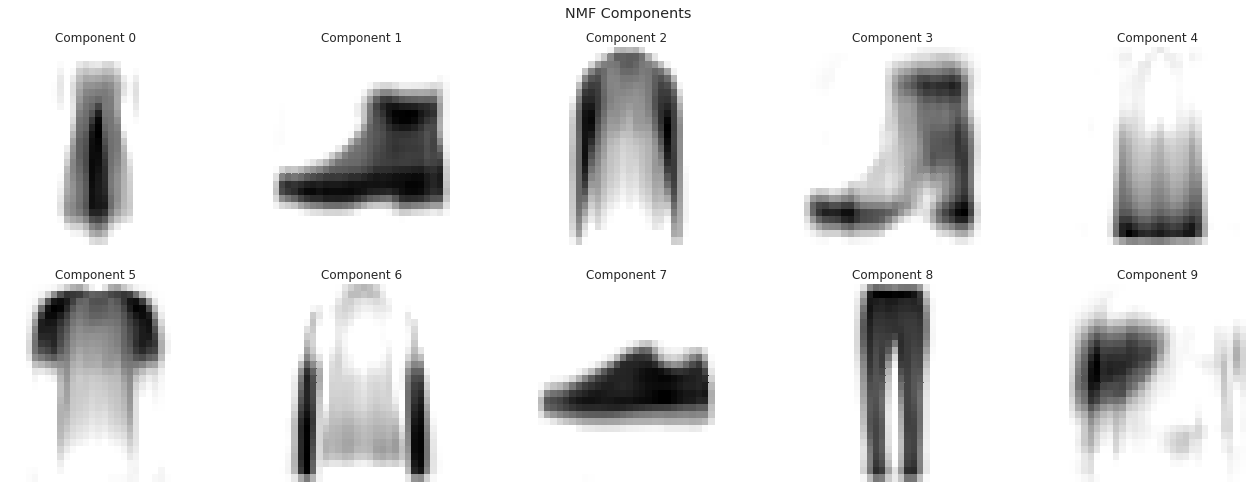

In [0]:
# Plot NMF components
plot_components(components_nmf, 'NMF Components', 'Component')

This visualisation returns to the monochrome scale used before as NMF does not allow negative values.

The visualisation of the 10 components is much clearer.

We clearly see three seperate components for sandals, ankle boots and sneakers, and a completely seperated defined class for trousers.

This visualisation reveals the workings of the model - Component 6 doesn't represent a class, but clearly sleeves that can be attached to Component 5 to make a long-sleeve top. Similarly Component 2 and Component 0 come together to form a top or a coat.

We explore this further at the end of this section.

Now we use the NMF model to transform our images into data with 10 dimensions to reveal relationships between these components and the classes.

In [0]:
# Transform the training data into the 10 components.
x_nmf = nmf.transform(descriptors_train)

In [0]:
# Move the data into a dataframe
df_nmf = pd.DataFrame(x_nmf)

# Add the class on the end
df_nmf['class'] = target_train

As before, we study how the dimensions are related to the true class labelling by taking averages of the component weights across each class.

In [0]:
# Get averages of values for each dimension across the whole dataset
df_avg_nmf = averages_df(df_nmf)

In [0]:
# Plot a heatmap of the averages
plot_averages_heatmap(df_avg_nmf, 'NMF: Average Values for Reduced Training Data across True Class Labels', 'afmhot', 0, 0.5)

Here 0 is the lowest possible value, corresponding to no weight being given to that component for the given class.

There are two components that are quantitatively very closely related to classes - Component 8 and Component 7. These dimensions have been completely allocated to encoding trousers and sneakers respectively. Instead of giving localised parts of clothes, the NMF model has clearly related these dimensions to the entire clothing item.

Components 4 and 5 are quantitatively linked to the top class. In this case, judging by the visualisation, these components represent the top and bottom of a top respectively.

Component 6, which looks like the sleeves of a top, is linked to pullovers, coats, and shirts, which is intuitive as they would make up a section of these classes.

### Analysis and Comparison

Both PCA and NMF attempt to reduce the dimensionality by learning the key components that make up the entire dataset - both methods produce components for which all images in the dataset are linear combinations of. However, they produce different results.

PCA finds components which are like eigenvectors, or 'eigen-clothes', with some of the centroids resembling distortions of the classes [3]. This method of finding 'eigen-clothes' is usually more effective for a smaller variety in classes - for example, by trying to dimensionally reduce representations of faces to 'eigen-faces'. [3]

NMF finds parts representing certain parts of the whole representation, which can be combined linearly to get different classes [4]. For example, Component 6 doesn't represent an item of clothing, but sleeves which can be linearly added to Component 5 (a t-shirt) to get a long-sleeved top. Essentially, NMF splits up the items into localised features.

These differences in outcome come from constraints on the matrices that encode the images.

PCA allows negativity and has orthonormality constraints in the matrices that encode the images, leading to components that can be used in linear combinations to get coherent images, but its difficult to see intuition in visualisations of the components. Not only having additive combinations leads to strange components as we saw above that seem to encode one article of clothing by negative values and another by positive values, or components that seem to have elements of a large variety of possible options. [4]

NMF doesn't allow negativity, with only additive combinations being allowed. This enforces the components to intuitively correspond to parts that can be combined into a whole representation. [4]

The localised features generated by NMF are therefore sparse, and only describe certain local characteristics, with variability in final outcomes being generated by the combination of these spare components. Meanwhile PCA has a fully distributed non-sparse encoding. [5]

## Task 4.2 Latent Dirichlet Allocation (LDA) applied to images

### Introduction

LDA is a method similar to the dimensionality reduction methods above, often used in Natural Language Processing to analyse and group text documents into seperate topics. I'll explain briefly how LDA works in this context. Afterwards, I will follow an analogy to apply this to the fashion images dataset.

The data used by LDA is as follows [6]:

* Words: Smallest form of data, usually characterised as a single item in some vocabulary.
* Document: A sequence of N words.
* Corpus: A collection of M documents.

More concretely, LDA assumes that documents are made up of topics, and each topic is characterised by a distribution over words [6]. What sets LDA apart is that it assumes the topics are distributed unevenly - the algorithm assumes that each document will cover a low amount of topics, with each topic being made up of a small set of words that occur very frequently.

The goal is given a corpus, find a probability model that gives high probabilities to members of the corpus but also to other similar documents.

LDA assumes that the topics are distributed through a sparse Dirichlet distribution, ensuring that each document has a small collection of topics which use a small collection of words frequently.


The key idea is that the words that have similarly high probabilities of appearing in a given topic are related, and so can be grouped together.

#### Analogy to Images and Pixels

Now, we can reinterpret this for the images in the fashion dataset. We simply consider our collection of images as the corpus, images as documents, and pixels as words. Topics in this case will be the classes that different images fall into, with each class of clothing item being characteristed by a distribution over the pixels. The types of clothing item, or 'topics', are distributed unevenly, with each image being described by a small number of clothing items and each clothing item encoded by a small set of pixel values that occur often in each image of that clothing item.

For example, let us consider an image of a bag. Ideally, LDA would collect all images of bags under the topic 'bag' by analysing the probabilities that pixels occur in the places expected - for example, through describing the images under this 'topic' by the few pixels defining the shape of a handle.

To complete the analogy, LDA applied to images will assume that pixel value distributions that have similarly high probabilities of appearing in a given class can be grouped together. The topics that we form will be the 'centroids' that we found previously by reducing the dimensionality of the dataset or through unsupervised clustering.



### Prediction

Applications of LDA usually include many different but closely related topics, so enforcing 10 very distinct classes is contrary to its previous uses.

The large 'vocabularly' size of pixel values may create sparsity problems [6, p. 1006]. Each new image may contain pixel values that didn't appear previously in the images used for training beforehand. Sparsity can be tackled by applying smoothing the some of the probability distribution parameters by giving positive probabilities to pixels despite the fact that they may not occur in the images used during training.

However, LDA may work effectively on this dataset and be generalisable to non-text data.

There is a precedent for LDA to be used as a dimensionality reduction technique [6, p. 1014], so we could view this process in the exact same way as for Task 4.1.

LDA can bring together different words with the same semantic meaning to identify meaning and provide lower-dimensional representation of text [7], so we may expect that we should be able to reduce the multi-dimensional dataset of 60,000 images into key components that represent the rest of the data.

### Applying LDA to the Fashion Dataset

Now that we understand how LDA works, we'll apply it to the fashion images dataset. LDA will work by training on the images to find the ten most essential 'topics', in this case the type of fashion item.

In [0]:
# Fit LDA
lda = LatentDirichletAllocation(n_components = 10, random_state = seed, n_jobs = -1, verbose = 2).fit(descriptors_train)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.1min finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


iteration: 1 of max_iter: 10


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   51.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   51.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


iteration: 2 of max_iter: 10


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   45.2s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   45.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


iteration: 3 of max_iter: 10


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   43.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   43.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


iteration: 4 of max_iter: 10


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   41.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   41.9s remaining:    0.0s


iteration: 5 of max_iter: 10


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   40.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   40.9s remaining:    0.0s


iteration: 6 of max_iter: 10


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   40.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   40.9s remaining:    0.0s


iteration: 7 of max_iter: 10


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   40.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   40.0s remaining:    0.0s


iteration: 8 of max_iter: 10


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   39.9s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   39.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


iteration: 9 of max_iter: 10


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   39.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   39.3s finished


iteration: 10 of max_iter: 10


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   36.6s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   36.6s remaining:    0.0s


Now that the LDA has been fitted to the dataset, it has calculated 10 'topics' corresponding to groups of images that display high similarities to each other. We visualise these 'topics' below.

In [0]:
# Get 10 main topics
topics_lda = [topic.reshape(28, 28) for topic in lda.components_]

In [0]:
# Visualise LDA topics
plot_components(topics_lda, 'LDA Topics', 'Topic')

The above shows us the key 10 components, or 'topics', that the LDA model found.

LDA produced very individualised 'topics' for some of the classes. For example, Top 0 clearly encapsulates the images that are related to trousers. This would mean that the LDA has defined a topic where the probability distribution of pixel values accurately aligns with the visual shape of trousers.

The outline of trousers also seems to be present in Topic 1 and Topic 7.

As before, we apply LDA to the dataset to reduce dimensionality to see how the dataset is quantitatively linked to these 'topics'.

In [0]:
# Transform the training data into the 10 topics.
x_lda = lda.transform(descriptors_train)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   37.4s finished
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   37.4s remaining:    0.0s


In [0]:
# Move the data into a dataframe
df_lda = pd.DataFrame(x_lda)

# Add the class on the end
df_lda['class'] = target_train

In [0]:
# Get averages of values for each dimension across the whole dataset
df_avg_lda = averages_df(df_lda)

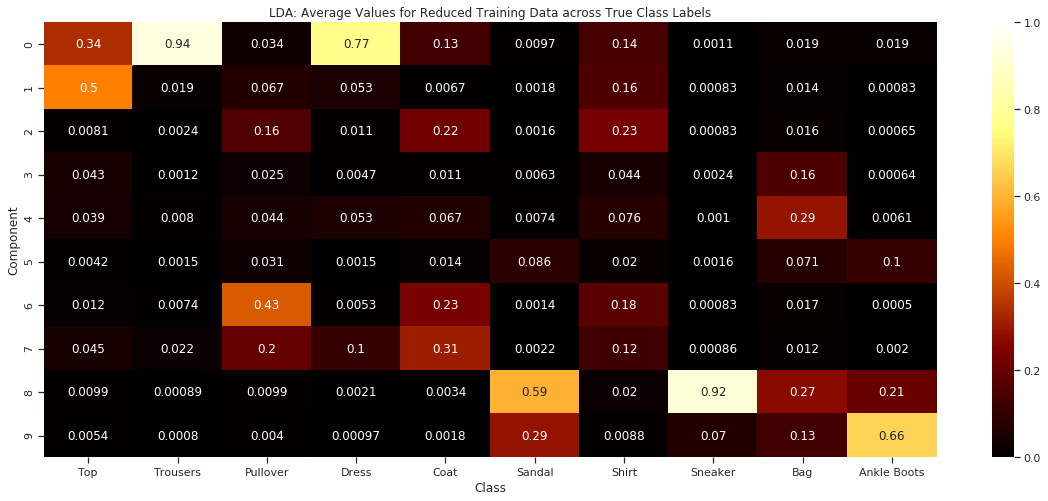

In [0]:
# Plot a heatmap of the averages
plot_averages_heatmap(df_avg_lda, 'LDA: Average Values for Reduced Training Data across True Class Labels', 'afmhot', 0, 1)

As expected, there is strong quantitative evidence for three of the components being related to classes: trousers, dresses, sneakers. To a lesser extent this is true for ankle boots.

Topic 0 is strongly linked to both trousers and dresses. Considering that LDA assigns these 'topics' based on the probability that certain features will arise, this is intuitive - trousers and dresses all share the characteristic of long and rectangular shapes, as well as the obvious fact that they are the only two classes that are worn on legs.

### Comparison to NMF and PCA

LDA produced very different results to NMF. LDA wont find sparse localised components in the same way that NMF does, and so we don't see clear visual parts like sleeves seen in Component 6 in any of the 'topics' produced by LDA.

LDA seems to show some of the same characteristics as PCA, for example with topics being quantitatively and visually related to more than one class. For example, 'topic' 1 seems to relate to both tops and trousers.

All three seemed to effectively reduce to a single dimension to represent trousers, with all three having one component visually representative of this class and quantitatively related through the averaging of values across true class labellings.

### Comparison to Centroids from K-Means Clustering

The centroids from K-Means clustering and LDA both seemed to produce four distinct groupings for the classes tops, coats, pullovers and shirts. However, LDA has much clearer visual distinction between the four groups with 'Topics' 1, 2, 6, and 7. Despite their differences in approach, namely dimensionality reduction and unsupervised clustering, both are being looked at in an unsupervised way in this context and attempt to find groups without information about true groupings. As above, both have clearly defined components for trousers.

Given that K-Means clustering is a constrained version of PCA through the more general linear algebra problem of matrix factorisation [8], the comparison here is similar to what we've discussed above.

### Final Remarks

LDA produced some similar outcomes to the other three techniques due to its effectiveness at dimensionality reduction [7], however as it's most common use is for text classification it works very differently as a generative statistical model, whereas linear algebra oriented approaches of NMF, PCA (and by extension K-Means clustering) are much more suitable and more frequently used for image analysis.

# References

1. Clauset, A., Newman, E. K., Moore, C. Finding community structure in very large networks. *Phys. Rev. E*; 2004.

2. Santurkar, S. et al. How does batch normalization help optimisation? *32nd Conference on Neural Information Processing Systems*. 2018

2. Turk M., Pentland A. Eigenfaces for recognition. *J. Cogn. Neurosci.* 1991; **6**: 559-601

3. Lee D., Seung H. Learning the parts of objects by non-negative matrix factorisation. *Nature* [online] 1999; **401**: 788–791

4. Field D. J. What is the goal of sensory coding? *Neural Comput.* 1994; 6: 559-601

5. Blei D. M., Ng A. Y., Jordan M. I. Latent Dirichlet Allocation. *Journal of Machine Learning Research.* 2003; 993-1022

6. Crain S. P. et al. Dimensionality Reduction and Topic Modelling: From Latent Semantic Indexing to Latent Dirichlet Allocation and Beyond. Mining Text Data. 2012; p. 129-61

7. Ding, C., He, X. K-means Clustering via Principal Component Analysis. *Proceedings of the 21st International Conference on Machine Learning*. 2004.